In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Table of contents
* [Algorithme non distribué 2 taches 2 classes](#Algorithme-non-distribué-2-taches-2-classes)
     * [1ère étape: Calcul des moyennes empiriques](#1ère-étape)
     * [2ème étape: Estimation de $c$ et de $\mathcal{M}$](#2ème-étape)
     * [3ème étape: Calcul des labels optimaux](#3ème-étape)
     * [4ème étape: Estimation des $m_{tj}$](#4ème-étape)
     * [5ème étape: Calcul de $V$](#5ème-étape)
     * [6ème étape: Evaluation et calcul d'erreur](#6ème-étape)
* [2-class Gaussian mixture transfer](#2-class-Gaussian-mixture-transfer-(c.f.-Figure-2))
* [Adding Tasks](#Adding-tasks)
* [Algorithme distribué 2-tâches 2-classes](#Algorithme-distribué-2-tâches-2-classes)
     * [Serveur isolé](#Serveur-isolé)
* [Distributively adding tasks](#Distributively-adding-tasks)
     * [Working with real data](#Real-Data)
* [Optimalité](#Optimalité)
* [Algorithme distribué k-tâches 2-classes](#Algorithme-distribué-k-tâches-m-classes)
     

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [3]:
def mean_matrix(p, beta=None, k=2, m=2,starting=1):
    """
    Crée des vecteurs de moyennes en respectant les conditions de non trivialité 
    retourne un tableau contenant k tableaux de m moyennes.
    beta est le paramètre de task relatedness. Si beta n'est pas précisé, il est tiré au hasard uniformément sur [0,1] pour chaque t.
    k=2, m=2 par défaut
    if starting==1 la premiere moyenne sera les vecteurs canoniques e1 et ep
    """
    mu = np.zeros((p,1))
    mu[0]= 1
    mu_ortho = np.zeros((p,1))
    mu_ortho[-1] = 1
    
    M = []
    classes = []
    if starting==1:
        for l in range(m):
            classes.append((-1)**l*mu)
        M.append(classes)
    
    for t in range(starting,k):          
        mu_t = beta*mu+np.sqrt(1-beta**2)*mu_ortho
        classes = []
        for l in range(m):
            classes.append((-1)**l*mu_t)
        M.append(classes)
    return M

In [4]:
def gaussian_synthetic_data(n, p, m, t, n_t, M):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    X = []
    tmp = []
    y_test = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
            X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
#             print( n_t[task][k])
            for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
                mean = np.reshape(M[task][k], p)
                X_k[j] = np.random.multivariate_normal(mean, np.identity(p))
                y_test.append(k)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X, y_test

## 1ère étape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

In [5]:
def empirical_mean(nb_tasks, nb_classes, X, p, n_t, display=False):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    
    M = np.empty((nb_tasks*nb_classes, nb_tasks*nb_classes)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(n_t[i][j]/2)
#                         print("DEBUG diagonal")
#                         print(f"i = {i}, j = {j}")
#                         print(i*nb_classes+j, i*nb_classes+j)
#                         print("moitie : ", moitie)
                        
                        M[i*nb_classes+j][i*nb_classes+j] = np.ones((moitie, 1)).T@X[i][j].T[:moitie]@X[i][j].T[moitie:].T@np.ones((moitie))
                        M[i*nb_classes+j][i*nb_classes+j] /= moitie**2
                    else:
#                         print(i*nb_classes+j, k*nb_classes+l)
#                         print(i, j, k, l)
                        M[i*nb_classes+j][k*nb_classes+l] = np.ones((n_t[i][j], 1)).T@X[i][j].T@X[k][l]@np.ones((n_t[k][l]))
                        M[i*nb_classes+j][k*nb_classes+l] /= n_t[i][j]*n_t[k][l]
    
    if display:
        for t in range(nb_tasks):
            for l in range(nb_classes):
                print(f"class {t*nb_classes+l} empirical mean = {np.mean(M[t*nb_classes+l])}")
                
    return M

In [6]:
def true_mean(M, p, nb_tasks, nb_classes):
    """
    Retourne un ndarray contenant les vraies moyennes avec lequel on peut travailler
    """
    true_M = np.empty((nb_tasks*nb_classes, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            mean = np.reshape(M[t][l], (p,))
            true_M[t*nb_classes+l] = mean

    return np.transpose(true_M)

In [7]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [8]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    """
    Estime le vecteur c en divisant n_t[nb_tasks][nb_classes]/n
    """
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_classes+m]=n_t[task][m]/n
            
    return c

In [9]:
def compute_M_cal(n,p,Dc,MM, k=2, display=False):
    """
    renvoie la matrice M cursive estimée.
    O(2*k)
    """
    c0 = p/n
    correlation_matrix = 1/c0*np.power(Dc, 1/2)@MM@np.power(Dc, 1/2)
    if display==True:
        plt.imshow(correlation_matrix)
        plt.show()
    return correlation_matrix

## 3ème étape
Let's compute optimal labels

In [10]:
# a revoir ?

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated, c0, task_target=None):
    """
    Evalue le label y pour une tache t pour 2 classes
    task_target=None par défaut, permet de choisir la tâche target en cas d'algo distribué.
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    # 0(16*k^3)
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # O(2*k)
    y = np.zeros((nb_tasks*nb_classes, 1))
    e3_e4 = np.zeros((nb_tasks*nb_classes,1))
    if task_target is not None:
        e3_e4[2*task_target] = 1
        e3_e4[2*task_target+1] = -1
    else:
        e3_e4[-2] = 1
        e3_e4[-1] = -1
    tilde_y=np.linalg.solve((Dc+Dc@M_estimated@Dc*1/c0),(Dc*1/c0@M_estimated@(e3_e4)))
    # O(8*k^3)
    return tilde_y
#malik's formula:
#tilde_y=(diag(c)*MM*diag(c)/co+diag(c))\((e3-e4)'*MM*diag(c))';

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [11]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j, c0=1/21):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_classes+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = np.sqrt(c0)*y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [12]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [13]:
def create_J(nb_classes, nb_tasks, n, n_t):
    # enlever paramètre n
    left = 0
    beg = 0
    for i in range(nb_tasks):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_classes))
    #matprint(J)
    for t in range(nb_tasks):
        for j in range(nb_classes):
            for i in range(beg, beg+n_t[t][j]):
                J[i][t*nb_classes+j] = 1
            beg += n_t[t][j]
    return J

In [14]:
def compute_V_old(y_tilde, X, J):
    """
    Utilise la formule explicite de V pour la classification binaire
    """
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

def compute_V(y, X, J, n):
    """
    Recalcule V (calcul vecteur propre)
    Vstar dans le fichier matlab
    Division par p, si les X pas normalisé ?
    wtf is wrong with V? 
    """
    #X*J*(tilde_y*tilde_y')*J'*X'/n
    #print(X.shape)
    eigenvalue, V = np.linalg.eig(X.dot(J).dot((y).dot(y.T)).dot(J.T).dot(X.T)/(n))
    maximum = eigenvalue[0]
    idx_larg = 0
    # retrieve the index of the largest eigenvalue
    for idx, value in enumerate(eigenvalue):
        if value > maximum:
            maximum = value
            idx_larg = idx
    
    largest_eigenvalue = np.sort(eigenvalue.real)[-1]
    return V.T[idx_larg].real

## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [15]:
def create_mt(t, m, y, Dc, correlation_matrix, c0):
    m_t = []
    for k in range(t):
        m_tj = []
        for l in range(m):
            m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l, c0))
        m_t.append(m_tj)

    return m_t

In [16]:
def compute_score(V, x, m_t, rho1=0.5, rho2=0.5):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
#     print(f"m_t[0], m_t[1] = {m_t[0]}, {m_t[1]}")
    average_mean = 1/2*(m_t[0] + m_t[1]) - 1/(m_t[0]-m_t[1])*np.log(rho1/rho2)
#     print(f"avg : {average_mean}")
    return (1 if x_projection > average_mean else -1) 

In [17]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [18]:
def error_rate(nb_tasks, nb_classes, Dc, M_cur, c0, task_target=1):
    e3 = np.zeros((nb_tasks*nb_classes, 1))
    e3[2*task_target] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    inv = np.linalg.inv(M_cur+np.identity(nb_tasks*nb_classes))
    print("arg q-func : ")
    print(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3))
    return qfunc(np.sqrt(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3)))
    #return qfunc(1/2*np.sqrt(et_trans.dot(power_dc).dot(M_cur).dot(inv).dot(M_cur).dot(power_dc).dot(et1_et2)))
#erfc(sqrt(e3'*MM*diag(c)*inv((diag(c)*MM*diag(c)+diag(co*c/k)))*diag(c)*MM*e3)/(sqrt(2)))/2;

In [19]:
def plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur):
    plt.scatter(1, emp_rate, label="empirical error")
    plt.scatter(1, [error_rate(m_t[1], nb_tasks, nb_classes, Dc, M_cur)], label="theoritical error")
    plt.grid()
    plt.ylim((0,1))
    plt.xlim((-0.5, 0.5))
    plt.legend()
    plt.title(f"Classification error rate per task")
    plt.show()

In [20]:
def compute_error_rate(X_test, V, m_t, nb_classes, n_t, Dc, c0, task_target=1, rho1=0.5, rho2=0.5, debug=False):
    """
    Compute and plot classification error rate on test set
    """
#     print("mt1= \n", m_t[1])
    error = 0
    eps1,eps2=0,0
    ni = sum(n_t[0])
    for l in range(nb_classes):
        for i in range(n_t[0][l]):
            # on prend la transposée pour pouvoir travailler avec les colonnes
            if i==0:
                print(f"rho1, rho2 = {rho1}, {rho2} in function")
            score = compute_score(V, X_test[0][l].T[i].T, m_t[task_target], rho1, rho2)
            # misclassifaction of class 0 in class 2
            if (score == -1 and l == 0):
                error +=1
                eps1+=1
            #missclassification of class 2 in class 1
            elif (score == 1 and l == 1):
                error +=1
                eps2+=1
                    
    erreur_emp = error/ni
    
    if erreur_emp > 0.5:
        erreur_emp=1-erreur_emp
#     emp_rate.append(erreur_emp)
    print("Epsilon 1 et 2 : ")
    if debug:
        print(eps1/n_t[0][0])
        print(eps2/n_t[0][1])
        print(erreur_emp)
        print(eps1/n_t[0][0]*rho1+eps2/n_t[0][1]*rho2)
        eps1=eps1/n_t[0][0]
        eps2=eps2/n_t[0][1]
        if eps1>0.5:
            eps1=1-eps1
        if eps2>0.5:
            eps2=1-eps2
        print(f"erreur empirirque = {erreur_emp}")
        return erreur_emp, eps1, eps2
    return erreur_emp

In [26]:
def debug_histogram(V, X_test, n_t):
    """
    Trace l'histogramme de V^T*x_1 et V^T*x_2.
    """
#     print(X1[0][0])
#     print(n_t[0][0])
    alpha = 0.5
    bins = 20
    plt.hist(V.T.dot(X_test.T[:n_t[0][0]].T), bins = bins, alpha=alpha, label=r"$C_1$", density=True)
    plt.hist(V.T.dot(X_test.T[n_t[0][0]:].T), bins = bins, alpha=alpha, label=r"$C_2$", density=True)
    plt.grid()
    plt.title(r"Histogramme des données de tests projetées sur $V$ : $V^Tx_j$")
    plt.legend()
    plt.show()

# 2-class Gaussian mixture transfer (c.f. Figure 2)

In [22]:
from time import time
from scipy.stats import norm 
plt.style.use('seaborn-dark-palette')

In [23]:
def optimal_rate(xx, rho1, rho2):
    """
    Renvoie l'optimum bayésien.
    """
    return 1-(rho1*qfunc(xx/2+1/xx*np.log(rho1/rho2))+rho2*qfunc(xx/2-1/xx*np.log(rho1/rho2)))

In [140]:
# %%prun -s cumulative
# profiling
%matplotlib inline
p = 100
m = 2
t = 2
beta = np.linspace(0,1,10)
# n_t = [[50, 50], [10, 10]]
n_t = [[800, 200], [80, 20]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
# n_t_test = [[1000, 1000]]
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

temps_MM = []
temps_estim = []
temps_inference = []
moyennes = []
e1, e2 = [], []
R1, R2 = [], []
for idx, b in enumerate(beta):
    print(f"beta = {b}")
    M = mean_matrix(p, b, t)
    c = estimate_c(n_t, n, t, m)
    #     print("c : ")
    #     print(c)
    c0 = p/n
    Dc = np.diag(c)
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    
    # erreur théorique optimale
    moyennes.append(optimal_rate(xx, rho1, rho2))
# #     err = []
# #     epsilon1, epsilon2 = [], []
#     for l in range(10):
#         X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M)
#         X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]])

#         MM = empirical_mean(t, m, X, p, n_t)
#         print("MM : \n")
#         correlation_matrix = compute_M_cal(n, p, Dc, MM, display=False)
    #     matprint(correlation_matrix)
#         y = label_evaluation(t,m,Dc,MM, c0)
    #     print("correlation matrix true : ")
    #     matprint(correlation_matrix_true)
    #     print("c0 : ", c0)
    #     diff = np.abs(correlation_matrix-correlation_matrix_true)
    #     print("erreur relative M cursive")
    #     matprint(diff/np.abs(correlation_matrix_true))
#         
#         X_train_aggregated = aggregate_array(X, p, n, t, m)
#         X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)

#         J = create_J(m, t, n, n_t)
#         V = compute_V_old(y, X_train_aggregated, J)
#         V = np.reshape(V, p)
#         V_true = compute_V_old(y_true, X_train_aggregated, J)
#         V_true = np.reshape(V_true, p)

#         m_t = create_mt(t, m, y, Dc, correlation_matrix, c0)
#         print(f"m_t = {1/2*(m_t[1][0]+m_t[1][1])}")
        
#         print(f"rho1, rho2 = {rho1}, {rho2}")
#         erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
        
#         err.append(erreur_empirique)
#         epsilon1.append(eps1)
#         epsilon2.append(eps2)
        
#     x = np.linspace(-3,3, 500)
#     plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
#     plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     emp_rate.append(np.mean(err))
#     e1.append(np.mean(epsilon1))
#     e2.append(np.mean(epsilon2))
#     var.append(np.std(err))
    
%matplotlib qt
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, moyennes, '-^', label='erreur optimal')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()


beta = 0.0
beta = 0.1111111111111111
beta = 0.2222222222222222
beta = 0.3333333333333333
beta = 0.4444444444444444
beta = 0.5555555555555556
beta = 0.6666666666666666
beta = 0.7777777777777777
beta = 0.8888888888888888
beta = 1.0


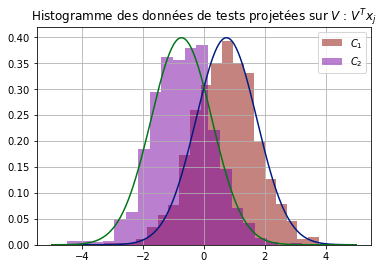

(100,)
(100, 2000)
-0.3208736574474463
0.7591086580652291
qfunc((m1-m2)/2) = 0.705398434812235
0.30369999999999997
xx =  -1.0799823155126753
m1 =  -0.3208736574474463
m2 =  0.7591086580652291
eps
0.25
qfuncs
0.7338745433285422
0.6755923662008608
0.6285999999999999 0.6573
e1, e2, e3, e4 = 0.30369999999999997, 0.35705, 0.2952665452352985, 0.29460156518776504
[]


In [28]:
%matplotlib inline
x = np.linspace(-5,5, 500)
plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
debug_histogram(V, X_test_aggregated, n_t_test)
emp_rate.append(np.mean(err))
var.append(np.std(err))
print(V.shape)
print(X_test_aggregated.shape)
m2 = np.mean(V.T@X_test_aggregated.T[:400].T)
m1 = np.mean(V.T@X_test_aggregated.T[600:].T)
print(m1)
print(m2)
print(f"qfunc((m1-m2)/2) = {qfunc((m1-m2)/2)}")
print(np.mean(err))
xx = m1-m2
print("xx = ", xx)
print("m1 = ", m1)
print("m2 = ", m2)
#print(1-(rho1*qfunc(xx/2+1/xx*np.log(rho1/rho2))+rho2*qfunc(xx/2-1/xx*np.log(rho1/rho2))))
e4 = 1-(rho1*qfunc(xx/2+1/xx*np.log(rho1/rho2))+rho2*qfunc(xx/2-1/xx*np.log(rho1/rho2)))
print("eps")
print(rho1*0.15+rho2*0.35)
print("qfuncs")
print(1-qfunc(np.mean(err)-m1))
print(qfunc(np.mean(err)-m2))
print(1-e1[0], 1-e2[0])
e3 = 1-(rho1*qfunc(m1-np.mean(err))+rho2*qfunc(np.mean(err)-m2))
print(f"e1, e2, e3, e4 = {np.mean(err)}, {(rho1*e1[0]+rho2*e2[0])}, {e3}, {e4}")
print(th_rate)

In [60]:
# x = np.linspace(-10,10, 500)
m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true, c0)
print(m_t_true[1][0])
# plt.plot(x, 1*norm.pdf(x, m_t[1][0], 1))
# plt.plot(x, 1*norm.pdf(x, m_t[1][1], 1))
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
print(m_t)
print(qfunc(1/2*(m_t_true[1][1]-m_t_true[1][0])))
plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.plot(beta, th_rate, '-v', label='theoritical rate')
# plt.plot(beta, R2, '-^', label='optimal rate')
plt.plot(beta, moyennes, '-^', label='optimal rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.scatter(0, lower[0], 'o', label='std-low')
# plt.scatter(0, upper[0], 'o', label='std-up')
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

0.7071067811865475
[[0.03809653410913311, -0.033077735382288934], [0.8224336201687215, -0.8181541254818973]]
0.7602499389065233


In [132]:
from datetime import datetime
now = datetime.now()
date = now.strftime("%Y-%m-%d %H:%M:%S")
with open("log.txt", "a") as log:
    log.write(f"Courbe pour added tasks (D) tracé le {date}\n\nEmpirique:\n\n")
    for i,j in enumerate(t):
        log.write(f"({j}, {emp_rate[i]})")
    log.write("\n\nThéorique:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {th_rate[i]})")
    log.write("\n\nLower:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {lower[i]})")
    log.write("\n\nUpper:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {upper[i]})")    
        
#     for i,j in enumerate(t): 
#         log.write(f"({j}, {data_sent[i]})")
#     for i,j in enumerate(t): 
#         log.write(f"({j}, {data_sent_nd[i]})")
    log.write("\n-----------------\n")

In [68]:
# erreur_relative_prec = 0.054
# erreur_relative_moy = np.mean(relative_error_rate)
# print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations et {nt} données de test : {round(erreur_relative_moy, 3)}")

# print(f"En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur {(1/(erreur_relative_prec/erreur_relative_moy))}")


# print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {round(np.mean(temps_MM), 5)} s, {round(np.mean(temps_estim), 5)} s, {round(np.mean(temps_inference), 5)} s.\nLe temps total moyen est ainsi de {round(np.mean(temps_estim) + np.mean(temps_MM) , 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.plot(beta, moyennes, '-^', label='optimal rate')
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Adding tasks

In [115]:
###### %%prun -s cumulative
# profiling
%matplotlib inline
p = 100
m = 2
# on ajoute des tâches 2 par 2
nb_tasks = 20
t = list(range(2,2*nb_tasks, 2))
to_add = [100, 100], [20, 20]
n_t = []
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []
task_target = 1

betat = np.random.uniform(low=0.4, high=0.8, size=(len(2*t)))
# betat = [0.29405,
#    0.40548,
#    0.37921,
#    0.38012]  

beta = 0
X = []
X_test = []
M = []
# on choisit des données de test
print(f"beta = {betat[task_target]}")
mean = mean_matrix(p, beta=betat[task_target], k=2)
M.append(mean[0])
M.append(mean[1])
# print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")
# X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]])
# X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
# vec1 = np.zeros((p,1))
# vec1[0] = 1

# M_true= np.concatenate((vec1, -vec1), axis=1)
# M_true= np.append(M_true, np.concatenate((vec2, -vec2), axis=1), axis=1)
# vec2, vec3,vec4, vec5 = np.zeros((p,1)), np.zeros((p,1)), np.zeros((p,1)), np.zeros((p,1))
# vec2[0], vec2[1] = 0.29405, 0.95579
# vec3[0], vec3[1] = 0.40548, 0.91410
# vec4[0], vec4[1] = 0.37921, 0.92531
# vec5[0], vec5[1] = 0.40548, 0.91410

n=0
for b in (t):
    print(b)
#     err=[]
    n_t.append(to_add[0])
    n_t.append(to_add[1])
#     if b==4:
#         M_true= np.append(M_true, np.concatenate((vec3, -vec3), axis=1), axis=1)
#         M_true= np.append(M_true, np.concatenate((vec4, -vec4), axis=1), axis=1)
#     elif b==6:
#         M_true= np.append(M_true, np.concatenate((vec5, -vec5), axis=1), axis=1)
#         M_true= np.append(M_true, np.concatenate((vec4, -vec4), axis=1), axis=1)
        
        
#     print(b)
#     print(n_t)
    n += sum(to_add[0])+sum(to_add[1])
#     print(n)
    # on crée les données synthétiques 
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    Dc = np.diag(c)
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc,MM_true, c0, 1)
    matprint(y_true)
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    J = create_J(m, b, n, n_t)
    for l in range(5):
        for i in range(2):
#             print(f"beta = {betat[beta]}")
            mean = mean_matrix(p, beta=betat[beta], k=1, starting=0)
            M.append(mean[0])
#             print(f"Verif beta = {M[b-2+i][0][0]}, {M[b-2+i][0][1]}")
#             print(f"Generating synth data with M[{beta}]")

#             synth = gaussian_synthetic_data(sum(to_add[i]), p, m, 1, [n_t[i]], [M[beta]])[0]
#             if l==0:
#                 X.append(synth[0][:])
#             else:
#                 X[b-2+i] = synth[0][:]
            beta+=1
        beta-=2
    #     print(M)
#         print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")

    # DEBUG
        #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
        # On calcule les moyennes empiriques
#         MM = empirical_mean(b, m, X, p, n_t, True)
#         correlation_matrix = compute_M_cal(n, p, Dc, MM, display=False)
#         y = label_evaluation(b,m,Dc,MM, c0, task_target=task_target)
        
#         X_train_aggregated = aggregate_array(X, p, n, b, m)
#         V = compute_V(y, X_train_aggregated, J, n)
#         V_true = compute_V(y_true, X_train_aggregated, J, n)
#         m_t = create_mt(b, m, y, Dc, correlation_matrix, c0)
#         erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
#         err.append(erreur_empirique)
#     beta+=2
    # On time le temps d'inférence 
    
#     x = np.linspace(-3,3, 500)
#     plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
#     plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
#     VTX = V.T@X_test_aggregated
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     var.append(np.var(VTX))
    print(rho1, rho2)
    erreur_th = optimal_rate(xx, rho1, rho2)
#     emp_rate.append(np.mean(err))
#     var.append(np.std(err))
    th_rate.append(erreur_th)
#     relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
# erreur_relative_moy = np.mean(relative_error_rate)
# print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")


%matplotlib qt
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(t, emp_rate, '-o', label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
# plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

beta = 0.5278066077073518
2
 0.637009  
-0.637009  
  2.94826  
 -2.94826  
0.5 0.5
4
 0.49346  
-0.49346  
 2.39653  
-2.39653  
 2.38293  
-2.38293  
 2.39653  
-2.39653  
0.5 0.5
6
 0.441631  
-0.441631  
  2.25606  
 -2.25606  
  2.24286  
 -2.24286  
  2.25606  
 -2.25606  
  2.24286  
 -2.24286  
  2.25606  
 -2.25606  
0.5 0.5
8
 0.406843  
-0.406843  
    2.192  
   -2.192  
  2.17879  
 -2.17879  
    2.192  
   -2.192  
  2.17879  
 -2.17879  
    2.192  
   -2.192  
  2.17879  
 -2.17879  
    2.192  
   -2.192  
0.5 0.5
10
 0.378184  
-0.378184  
  2.15542  
 -2.15542  
  2.14205  
 -2.14205  
  2.15542  
 -2.15542  
  2.14205  
 -2.14205  
  2.15542  
 -2.15542  
  2.14205  
 -2.14205  
  2.15542  
 -2.15542  
  2.14205  
 -2.14205  
  2.15542  
 -2.15542  
0.5 0.5
12
 0.352421  
-0.352421  
  2.13181  
 -2.13181  
  2.11821  
 -2.11821  
  2.13181  
 -2.13181  
  2.11821  
 -2.11821  
  2.13181  
 -2.13181  
  2.11821  
 -2.11821  
  2.13181  
 -2.13181  
  2.11821  
 -2.

In [118]:
print(M_true.shape)
print(Dc.shape)
print(y_true)
print(M_true[:1])

(100, 8)
(8, 8)
[[-0.08458442]
 [ 0.08458442]
 [ 4.01853101]
 [-4.01853101]
 [ 3.66970556]
 [-3.66970556]
 [ 4.01853101]
 [-4.01853101]]
[[ 1.         -1.          0.73116226 -0.73116226  0.78095511 -0.78095511
   0.73116226 -0.73116226]]


In [49]:
print(X_test_aggregated.shape)
for i in range(0, len(M)):
    print("new task")
    for j in range(2):
        print(M[i][j][0])
matprint(M_true.T@M_true)
print(n_t)

(2000, 200)
new task
[1.]
[-1.]
new task
[0.02592623]
[-0.02592623]
new task
[0.4359949]
[-0.4359949]
new task
[0.02592623]
[-0.02592623]
         1          -1   0.0259262  -0.0259262  
        -1           1  -0.0259262   0.0259262  
 0.0259262  -0.0259262           1          -1  
-0.0259262   0.0259262          -1           1  
[[50, 50], [6, 6]]


In [56]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(range(len(emp_rate)), emp_rate, '-o', label='empirical rate')
plt.plot(range(len(emp_rate)), th_rate, '-o', label='theoritical rate')
plt.fill_between(range(len(emp_rate)), lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Algorithme distribué k tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.

### k serveurs 
#### Federated Learning 2 classes k taches
Imaginons 1 Serveur central et k clients. L'un cherche à classifier un certain type d'images, l'autre un deuxième type d'images. Les deux clients sont confrontés un problème de classification binaire sur des images sensiblement similaire (quantifié par le paramètre $\beta$), et peuvent donc s'aider du training de l'autre pour affiner leur classification.

Le premier client entraîne son modèle de classification sur son jeu de données locales. Il espère obtenir de meilleures performances à l'aide du transfer Learning. Les deux clients envoient alors les moyennes empiriques calculées sur leurs donnée locales, au serveur central. Le serveur peut alors calculé la matrice de corrélation $\mathcal{M}$ et les labels optimaux $\tilde{y}$. Les clients recoivent les labels optimaux, et peuvent maintenant recalculer le vecteur propre $V$ de $\displaystyle\frac{X_ty_ty_t^TX_t^T}{np}$ et inférer sur de nouvelles données $x$.

Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

Chaque client calcule en local les moyennes empiriques des données et les envoie au serveur central.

De la même façcon que précédemment les données de chaque client (=chaque tâche) devront respecter les conditions de non-trivialité.

In [113]:
def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data 
    retourne la matrice M de taille px(2*k) et un vecteur contenant les coefficients diagonaux
    nb_classes=2 (toujours)
    
    Complexité : 
    -------------
    O(k*p*n_tl) = O(n*p)
    """
    M = np.empty((nb_classes*nb_tasks, p))
    diag = []
    for t in range(nb_tasks):
        # O(k)
        for l in range(nb_classes):
            # O(2)
            M[t*nb_classes+l] = X[t][l].dot(np.ones((n_t[t][l])))
            # O(p*n_tl)
            M[t*nb_classes+l] /= n_t[t][l]
            # O(1)
            
            moitie = int(n_t[t][l]/2)
            print(f" moitie = {moitie}")
#             print("shape X : ", X[t][l].T[:moitie].T.shape)
            mu1 = X[t][l].T[:moitie].T@np.ones((moitie))
            mu2 = X[t][l].T[moitie:].T@np.ones((moitie))
#             print("mu shapes before : ")
#             print(mu1.shape)
#             print(mu2.shape)
            # O(p*n_tl)
            mu1, mu2 = np.reshape(mu1, (p, 1)), np.reshape(mu2, (p, 1))
#             print("mu shapes : ")
#             print(mu1.shape)
#             print(mu2.shape)
            diag.append(mu1.T@mu2/moitie**2)
            # O(1)
    
    return M.T, diag

# diag1 = [mu1]
#diag_means = [[mu1], [mu2]]

def gather_empirical_mean(nb_tasks, nb_classes, emp_means, diag_means, p, n_t):
    """
    emp_means est un vecteur contenant les moyennes empiriques de chaque tache de chaque classe.
    Chaque vecteur de moyennes et de taille px1
    Renvoie la matrice M des, produits scalaires entre moyennes empiriques de chaque client
    """
    M = np.empty((nb_classes*nb_tasks, nb_classes*nb_tasks)) # ici 4x4
    for i in range(nb_tasks):
        # O(k)
        for j in range(nb_classes):
            # O(2)
            for k in range(nb_tasks):
                # O(k)
                for l in range(nb_classes):
                    # O(2)
                    if i == k and j == l:
                        #print(f"i = {i}, j = {j}")
#                         print(i*nb_tasks+j, i*nb_tasks+j)
#                         print(moitie)
#                         print(np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).shape)
#                         print(emp_means[i*nb_tasks+j][:moitie].T.shape)
                        M[i*nb_classes+j][i*nb_classes+j] = diag_means[i*nb_classes+j]
                    else:
#                         print(i*nb_tasks+j, k*nb_tasks+l)
#                         print(emp_means[i*nb_tasks+j].T.shape)
#                         print(emp_means[k*nb_tasks+l].shape)
                        M[i*nb_classes+j][k*nb_classes+l] = emp_means[i*nb_classes+j].T@emp_means[k*nb_classes+l]
                    # O(p)
#                         print(M[i*nb_tasks+j][k*nb_tasks+l].shape)
                
    return M

In [127]:
def merging_center(MM, diag, t, m, p, n, n_t, task_target=None, display=False):
    """
    Recoit les moyennes empiriques des k clients, calcule la matrice de corrélation, les labels optimaux et renvoie le vecteur V
    Renvoie y un vecteur de labels optimaux adapté à chaque client. (à changer?)
    """
    # MM = [[MM11, MM12], [MM21, MM22], [MM31, MM32], ...]
    emp_means = []
    diagonal = []
    
    for i in range(len(MM)):
        for l in range(m):
            emp_means.append(np.reshape(MM[i].T[l], (p, 1)))
            diagonal.append(diag[i][l])
    #diag = [diag1[0], diag1[1], etc.]
    #emp_means = [MM11, MM12, MM21, MM22, MM31, ...]
    MM_gathered = gather_empirical_mean(t, m, emp_means, diagonal, p, n_t)
    MM_gathered /= np.linalg.norm(MM_gathered)
    if display:
        print("MM_gathered : ")
        matprint(MM_gathered)
    
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM_gathered, display=display)
    y = label_evaluation(t,m,Dc,MM_gathered, c0, task_target=task_target)
    if display:
        matprint(y)
    
    # le serveur calcule aussi V
    V = np.zeros((p,1))
    for i in range(t):
        for j in range(m):
            V += n_t[i][j]*emp_means[i*m+j]*y[i*m+j]
    V /= np.linalg.norm(V)
    V = np.reshape(V, (p))
    
    return V, y, correlation_matrix, Dc, c0

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.206
0.244
0.225
0.22499999999999998
erreur empirirque = 0.225
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.294
0.212
0.253
0.253
erreur empirirque = 0.253
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.332
0.244
0.288
0.28800000000000003
erreur empirirque = 0.288
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.252
0.248
0.25
0.25
erreur empirirque = 0.25
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.222
0.286
0.254
0.254
erreur empirirque = 0.254


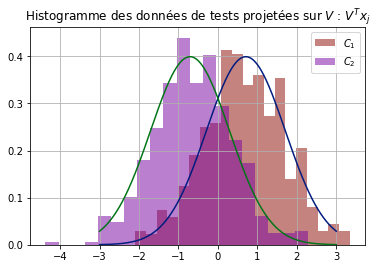

[0.254] [0.23975006109347674]
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.192
0.268
0.23
0.23
erreur empirirque = 0.23
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.248
0.214
0.231
0.23099999999999998
erreur empirirque = 0.231
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.236
0.252
0.244
0.244
erreur empirirque = 0.244
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.242
0.206
0.224
0.22399999999999998
erreur empirirque = 0.224
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.208
0.256
0.232
0.23199999999999998
erreur empirirque = 0.232


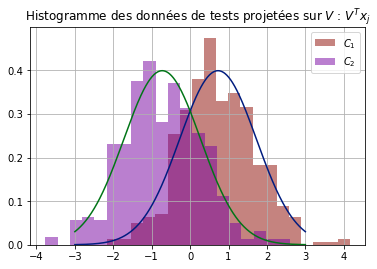

[0.254, 0.23220000000000002] [0.23975006109347674, 0.23373859215337522]
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.198
0.186
0.192
0.192
erreur empirirque = 0.192
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.2
0.252
0.226
0.226
erreur empirirque = 0.226
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.206
0.19
0.198
0.198
erreur empirirque = 0.198
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.17
0.244
0.207
0.20700000000000002
erreur empirirque = 0.207
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.176
0.248
0.212
0.212
erreur empirirque = 0.212


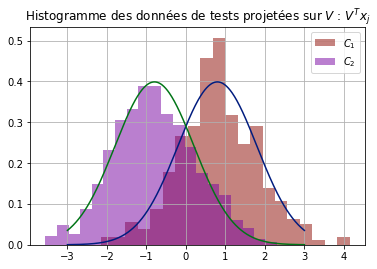

[0.254, 0.23220000000000002, 0.20700000000000002] [0.23975006109347674, 0.23373859215337522, 0.21290430759527834]
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.224
0.12
0.172
0.172
erreur empirirque = 0.172
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.116
0.234
0.175
0.17500000000000002
erreur empirirque = 0.175
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.216
0.106
0.161
0.161
erreur empirirque = 0.161
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.178
0.158
0.168
0.16799999999999998
erreur empirirque = 0.168
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.216
0.158
0.187
0.187
erreur empirirque = 0.187


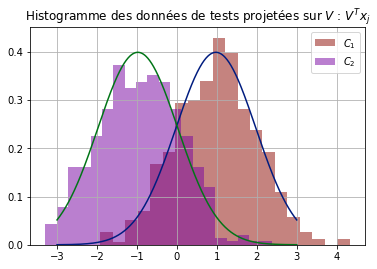

[0.254, 0.23220000000000002, 0.20700000000000002, 0.1726] [0.23975006109347674, 0.23373859215337522, 0.21290430759527834, 0.1642824917195984]


In [78]:
%matplotlib inline
n1 = 2000
n2 = 100
n = n1+n2
p = 100
m = 2
t = 2
ni = [n1, n2]
beta = np.linspace(0,1,4)
n_t = [[1000,1000], [50, 50]]
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
emp_rate, th_rate, var = [], [], []

task_target = 1
for b in beta:
    err = []
    # on crée les données synthétiques
    M = mean_matrix(p, b, t)
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    # erreur théorique optimale
    th_rate.append(optimal_rate(xx, rho1, rho2))
    for l in range(5):
        X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M)
        X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]])
        MM = []
        diag = []        
        # On calcule les moyennes empiriques sur les données locales
        # diag1 = [diag1[0], diag1[1]]
        for i in range(t):
            MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
            MM.append(MM1)
            diag.append(diag1)

    # CENTRAL SERVER
        # sending empirical means to central server
        # y est un vecteur de vecteurs de labels optimaux
        V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target)

    # END CENTRAL SERVER

        # Sending back optimal labels to clients
#         aggregated = []
#         for i in range(t):
#             aggregated.append(aggregate_array([X[i]], p, ni[i], 1, m))
        m_t = create_mt(t, m, y, Dc, correlation_matrix, c0)
        X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
        erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
        err.append(erreur_empirique)
#         epsilon1.append(eps1)
#         epsilon2.append(eps2)
        
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
    plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
    debug_histogram(V, X_test_aggregated, n_t_test)
    emp_rate.append(np.mean(err))
#     e1.append(np.mean(epsilon1))
#     e2.append(np.mean(epsilon2))
    var.append(np.std(err))
    print(emp_rate, th_rate)

%matplotlib qt

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [79]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Distributively adding tasks

boucle = 2
2
[[50, 50], [10, 10]]
n =  120
c0 :  1.6666666666666667
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
0.0978358  -0.152136   0.196472  -0.360372  
-0.152136   0.113515  -0.252747   0.144345  
 0.196472  -0.252747   0.531015  -0.208935  
-0.360372   0.144345  -0.208935   0.235785  


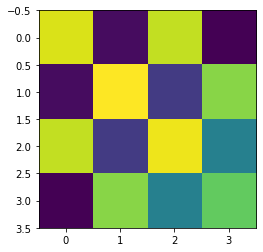

 0.310395  
-0.213684  
   0.4022  
-0.224311  
c0 :  1.6666666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.264
0.278
0.271
0.271
erreur empirirque = 0.271
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.143438  -0.0981023    0.182477   -0.198779  
-0.0981023      0.1199  -0.0281519   0.0935852  
  0.182477  -0.0281519    0.844946  -0.0196634  
 -0.198779   0.0935852  -0.0196634   -0.257626  


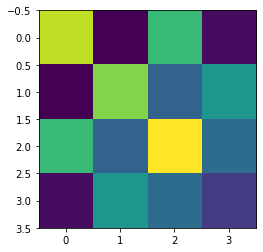

  0.216491  
-0.0658105  
  0.487966  
  0.157585  
c0 :  1.6666666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.366
0.335
0.3505
0.35050000000000003
erreur empirirque = 0.3505
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.148147  -0.297046  -0.0379597   -0.39016  
 -0.297046   0.248975   -0.108555   0.244425  
-0.0379597  -0.108555   -0.492624  -0.138662  
  -0.39016   0.244425   -0.138662  0.0898481  


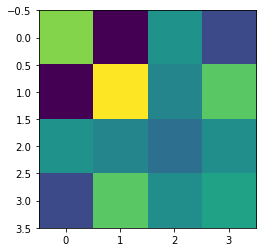

 0.187999  
-0.186121  
-0.221861  
-0.108446  
c0 :  1.6666666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.287
0.365
0.326
0.32599999999999996
erreur empirirque = 0.326
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.263481    -0.23935    0.521888  -0.113225  
 -0.23935  -0.0531612  -0.0633136    0.20223  
 0.521888  -0.0633136   0.0881023  -0.268183  
-0.113225     0.20223   -0.268183  0.0371964  


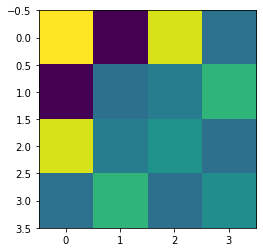

 0.344873  
-0.138352  
 0.163665  
-0.163971  
c0 :  1.6666666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.3
0.281
0.2905
0.2905
erreur empirirque = 0.2905
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.246881   -0.214987    0.169169  -0.339313  
-0.214987    0.171593  0.00851262   0.044206  
 0.169169  0.00851262   0.0130936   0.175361  
-0.339313    0.044206    0.175361   0.681129  


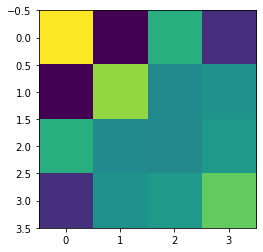

   0.283635  
-0.00530345  
  -0.106914  
  -0.269235  
c0 :  1.6666666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.298
0.379
0.3385
0.3385
erreur empirirque = 0.3385
[[ 1.         -1.          0.87810366 -0.87810366]
 [-1.          1.         -0.87810366  0.87810366]
 [ 0.87810366 -0.87810366  1.         -1.        ]
 [-0.87810366  0.87810366 -1.          1.        ]]


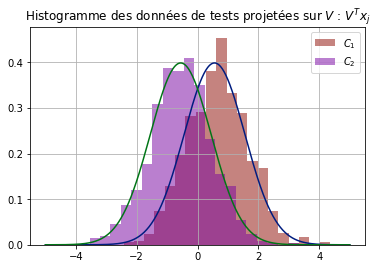

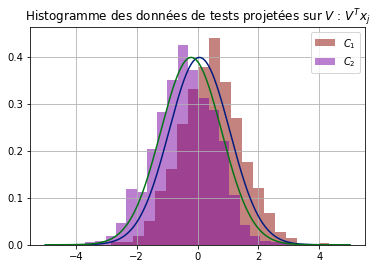

boucle = 2
4
[[50, 50], [10, 10], [50, 50], [10, 10]]
n =  240
c0 :  0.8333333333333334
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.0260759   -0.097037    0.141637  -0.0822768    0.137273  -0.0635348   0.0698631    -0.186108  
 -0.097037    0.116977   -0.204375    0.148344   -0.118985    0.074053  -0.0738972     0.232004  
  0.141637   -0.204375   0.0153974   -0.192383   -0.026039  -0.0198108   0.0226501     0.025419  
-0.0822768    0.148344   -0.192383  -0.0519137   -0.145921   0.0103116   -0.138109    0.0895293  
  0.137273   -0.118985   -0.026039   -0.145921    0.207049  -0.0624509   0.0422286    -0.181059  
-0.0635348    0.074053  -0.0198108   0.0103116  -0.0624509   0.0872784    -0.23131     0.190313  
 0.0698631  -0.0738972   0.0226501   -0.138109   0.0422286    -0.23131    0.131793     0.012574  
 -0.186108    0.232004    0.025419   0.0895293   -0.181059    0.190313    0.012574  0.000382944  


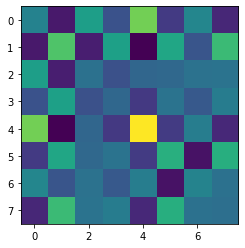

  0.250055  
  -0.39741  
   0.21915  
 -0.141289  
  0.115713  
 -0.019905  
  0.176464  
-0.0358195  
c0 :  0.8333333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.265
0.299
0.282
0.28200000000000003
erreur empirirque = 0.282
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.039651  -0.0891432   0.0990208    -0.219373     0.120947   -0.104718   0.0439389   0.0250624  
-0.0891432  0.00433883  -0.0972483     0.110408   -0.0885252    0.065741  -0.0293405    0.112845  
 0.0990208  -0.0972483    0.256744    0.0313642      0.11335   -0.128149   0.0705004    0.360143  
 -0.219373    0.110408   0.0313642     0.146457  -0.00557481   0.0408861   0.0880795  -0.0463453  
  0.120947  -0.0885252     0.11335  -0.00557481  -0.00911842   -0.103296   0.0285774   0.0111932  
 -0.104718    0.065741   -0.128149    0.0408861    -0.103296  0.00046365   -0.157138   0.0291692  
 0.0439389  

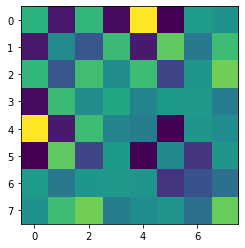

  0.361845  
 -0.236171  
  0.235019  
 -0.108002  
   0.12044  
 -0.185589  
-0.0330852  
  0.480263  
c0 :  0.8333333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.275
0.317
0.296
0.29600000000000004
erreur empirirque = 0.296
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.148236  -0.0912775  -0.0260222  -0.166167    0.0444693  -0.0714672    0.179514    -0.114458  
-0.0912775  -0.0181649   -0.036518  0.0929679   -0.0573819   0.0634103   -0.121598     0.033481  
-0.0260222   -0.036518   -0.133938  0.0511009    0.0197976   -0.138012   -0.234261    -0.125613  
 -0.166167   0.0929679   0.0511009  -0.289027    -0.169488    0.207422   0.0504915    0.0551387  
 0.0444693  -0.0573819   0.0197976  -0.169488   -0.0718451   -0.130701  -0.0263507  0.000681273  
-0.0714672   0.0634103   -0.138012   0.207422    -0.130701     0.14608   -0.190304     0.132505  
  0.179514   -0.12

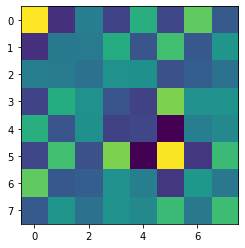

 0.155233  
 -0.14761  
-0.245587  
 0.456544  
 0.217884  
-0.396473  
-0.373886  
 -0.19968  
c0 :  0.8333333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.283
0.337
0.31
0.31
erreur empirirque = 0.31
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.0942819   -0.162533   0.0448982  -0.0414768    0.108897  -0.0620213    0.106431  -0.0594465  
 -0.162533    0.215553  -0.0143002    0.144483    -0.13985    0.105615   -0.165786   0.0725887  
 0.0448982  -0.0143002    0.125033   -0.167007     0.14932   0.0352709   0.0034252  -0.0392897  
-0.0414768    0.144483   -0.167007    0.228025   -0.175016  -0.0482069   -0.112093    0.207859  
  0.108897    -0.13985     0.14932   -0.175016   0.0960942  -0.0616984    0.123304  -0.0967161  
-0.0620213    0.105615   0.0352709  -0.0482069  -0.0616984     0.10636  -0.0993816  -0.0440269  
  0.106431   -0.165786   0.0034252   -0.112093   

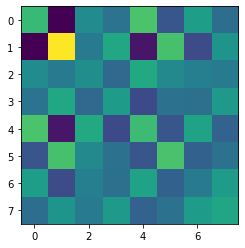

0.0836468  
-0.162985  
 0.328056  
-0.438716  
 0.365724  
 0.106937  
 0.121891  
-0.274384  
c0 :  0.8333333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.247
0.298
0.2725
0.27249999999999996
erreur empirirque = 0.2725
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.158414    -0.11396    0.137603  -0.0309507    0.169587   -0.149804     0.15094   -0.080689  
  -0.11396   0.0228631   -0.100296    0.109777  -0.0992619    0.119009  -0.0945698    0.220716  
  0.137603   -0.100296   0.0700363   0.0307984    0.133955  0.00958998  -0.0790932  -0.0449237  
-0.0309507    0.109777   0.0307984    -0.14009  -0.0561537    0.207092   0.0341973    0.086347  
  0.169587  -0.0992619    0.133955  -0.0561537   0.0591402   -0.132504   0.0660845  -0.0199433  
 -0.149804    0.119009  0.00958998    0.207092   -0.132504    0.152271    -0.12704    0.092845  
   0.15094  -0.0945698  -0.079

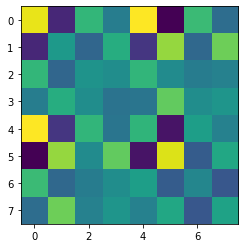

 0.172909  
-0.234785  
0.0274723  
 0.229114  
  0.20578  
-0.211444  
-0.160758  
-0.137468  
c0 :  0.8333333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.243
0.264
0.2535
0.2535
erreur empirirque = 0.2535
[[ 1.         -1.          0.87810366 -0.87810366  0.96973522 -0.96973522
   0.87810366 -0.87810366]
 [-1.          1.         -0.87810366  0.87810366 -0.96973522  0.96973522
  -0.87810366  0.87810366]
 [ 0.87810366 -0.87810366  1.         -1.          0.9683509  -0.9683509
   1.         -1.        ]
 [-0.87810366  0.87810366 -1.          1.         -0.9683509   0.9683509
  -1.          1.        ]
 [ 0.96973522 -0.96973522  0.9683509  -0.9683509   1.         -1.
   0.9683509  -0.9683509 ]
 [-0.96973522  0.96973522 -0.9683509   0.9683509  -1.          1.
  -0.9683509   0.9683509 ]
 [ 0.87810366 -0.87810366  1.         -1.          0.9683509  -0.9683509
   1.         -1.        ]
 [-0.87810366  0.87810366 -1.          1.         -0

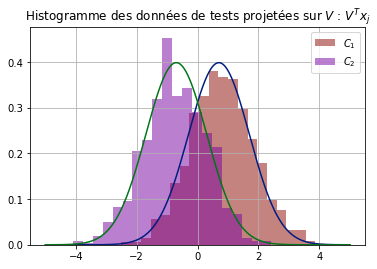

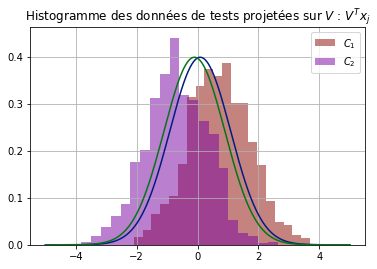

boucle = 4
8
[[50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10]]
n =  480
c0 :  0.4166666666666667
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.0597422   -0.0486348   0.0798865   -0.0651074    0.0409308  -0.0725505   0.0552476   -0.0442738   0.0581814  -0.0383512   0.0445907   -0.0775093   0.0272286  -0.0701797    0.0363559   -0.0719756  
-0.0486348    0.0616952  -0.0662897    0.0736567   -0.0606185   0.0589729  -0.0123436    0.0889328  -0.0355662   0.0345439  -0.0439596    0.0449409  -0.0486205   0.0444106  -0.00406827    0.0810441  
 0.0798865   -0.0662897   -0.216839    -0.157689    0.0159138  -0.0296533  -0.0890092   -0.0377094   0.0740934  -0.0694546   0.0590574   -0.0422601   0.0394379  -0.0453298   -0.0285275    0.0677802  
-0.0651074    0.0736567   -0.157689     0.105314   -0.036

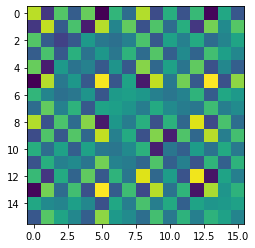

  0.322462  
 -0.310857  
 -0.180188  
 -0.594864  
  0.105059  
-0.0733351  
-0.0614443  
 -0.341009  
  0.267162  
 -0.336256  
   0.45118  
-0.0506866  
  0.204869  
 -0.242888  
 -0.209979  
  0.240767  
c0 :  0.4166666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.211
0.238
0.2245
0.22449999999999998
erreur empirirque = 0.2245
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.00191262   -0.0354724   0.00767009    -0.063912    0.042811  -0.0460485    0.0647896  -0.00699092   0.0472623   -0.013659   -0.0101459  -0.00749476    0.033048   -0.0560775   0.0831771  -0.0873679  
 -0.0354724    0.0814674   -0.0138532  -0.00514217   -0.042007   0.0308456   -0.0159491    0.0443126  -0.0541837   0.0624609   -0.0310099  -0.00269898  -0.0518981    0.0289179  -0.0330609   0.028895

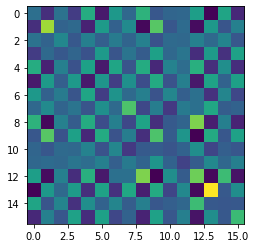

    0.15566  
-0.00440825  
   0.347386  
 -0.0653052  
   0.136202  
  -0.191507  
    0.27174  
  -0.114557  
   0.106768  
  -0.258762  
  0.0035718  
 -0.0871218  
   0.237814  
  -0.153088  
   0.583976  
  -0.545572  
c0 :  0.4166666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.188
0.237
0.2125
0.2125
erreur empirirque = 0.2125
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.0261918   -0.0597547    0.0799503  -0.0369934   0.0511007   -0.0539461   0.0624876   -0.0281138   0.0618865  -0.0389881    0.057343   -0.0701446    0.0202037     -0.04947  -0.00939694   -0.0386412  
 -0.0597547    0.0488111   -0.0756104   0.0670533  -0.0718703    0.0608087  -0.0877185    0.0299681  -0.0453909    0.047221  -0.0598721    0.0376246  -0.00127787    0.0441876   -0.0505157    0.0

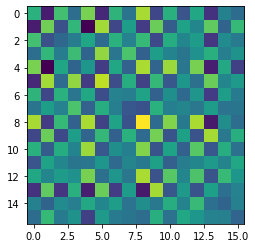

 0.253233  
-0.311181  
-0.205171  
-0.434709  
 0.189587  
-0.372019  
 0.414684  
 -0.48347  
 0.266266  
-0.253832  
 0.270533  
 0.149089  
0.0195614  
-0.365958  
0.0870861  
-0.153215  
c0 :  0.4166666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.2
0.218
0.209
0.20900000000000002
erreur empirirque = 0.209
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.0334513  -0.0464976   0.0576361  -0.0676922     0.05167   -0.0451395     0.044082   -0.0175363    0.0179768   -0.0296362    0.0157383  9.34911e-05   0.0131306   -0.0537608    0.0882675  -0.0625521  
 -0.0464976   0.0687562   -0.101468   0.0629651  -0.0367524    0.0507055   -0.0319531     0.024573   -0.0616135    0.0246641   -0.0740115    0.0417055  -0.0474692    0.0285142   -0.0676445    0.101628  
  0.0576361   

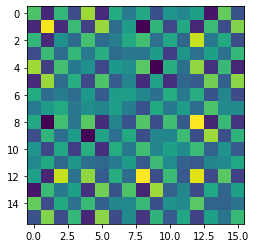

  0.279906  
 -0.363445  
  0.189227  
 -0.464847  
  0.185425  
 -0.168431  
 0.0783737  
  0.342752  
  0.190574  
 -0.112853  
  0.610368  
 -0.294545  
  0.357372  
-0.0925876  
  0.335082  
 -0.627351  
c0 :  0.4166666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.232
0.228
0.23
0.23
erreur empirirque = 0.23
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.0869796    -0.0200266    0.0237858  0.000381631    0.0374152   -0.0554005    0.0245572  -0.0746798    0.0531513  -0.0378211   0.0688292   -0.0496272   0.0375773  -0.0517941    0.0425709    -0.0337747  
 -0.0200266     0.0749738   -0.0263787    0.0255654   -0.0284905    0.0361296   -0.0310165   0.0157321   -0.0372927   0.0443202  -0.0211935    0.0369643  -0.0424593  0.00852462   -0.0498137  -0.000627675  
  0.023

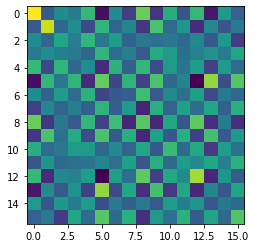

 0.0425851  
 -0.114487  
  0.266925  
 0.0543218  
  0.248508  
 -0.187622  
  0.325637  
 -0.170077  
 0.0792611  
 -0.180151  
 -0.280126  
-0.0294829  
0.00941092  
 -0.172274  
  0.199365  
  -0.71068  
c0 :  0.4166666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.222
0.252
0.237
0.237
erreur empirirque = 0.237
[[ 1.         -1.          0.87810366 -0.87810366  0.96973522 -0.96973522
   0.87810366 -0.87810366  0.89795307 -0.89795307  0.9550989  -0.9550989
   0.80026025 -0.80026025  0.86482606 -0.86482606]
 [-1.          1.         -0.87810366  0.87810366 -0.96973522  0.96973522
  -0.87810366  0.87810366 -0.89795307  0.89795307 -0.9550989   0.9550989
  -0.80026025  0.80026025 -0.86482606  0.86482606]
 [ 0.87810366 -0.87810366  1.         -1.          0.9683509  -0.9683509
   1.         -1.          0.99906652 -0.99906652  0.98044049 -0.98044049
   0.98962762 -0.98962762  0.99963335 -0.99963335]
 [-0.87810366  0.87810366 -1.        

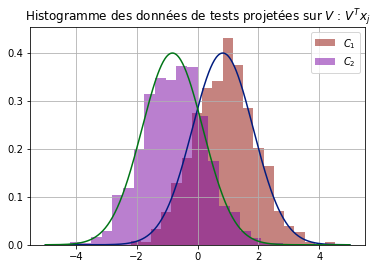

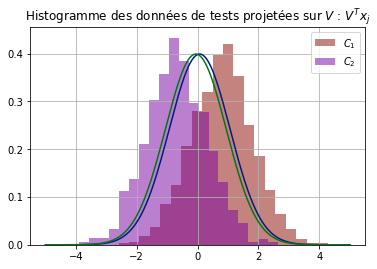

boucle = 8
16
[[50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10]]
n =  960
c0 :  0.20833333333333334
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
   0.0130678   -0.0144532  -0.000572455   -0.0190582   0.00807826  -0.00747331    0.0182226   -0.0299935   0.00996895  -0.00658005      0.034928    -0.0224197   0.0116975    -0.021072   0.0411175  -0.00418192     0.019689   -0.0179628     0.026471   -0.0117978   0.0134041   -0.0141161     0.0235565  -0.00568207    0.0138272  -0.0166948    0.0288764  -0.0191926    0.0120004

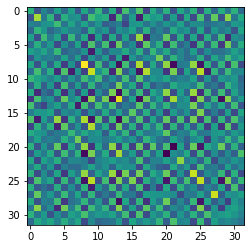

 0.0808011  
 -0.185023  
-0.0568148  
  0.365838  
  0.198183  
 -0.105379  
  0.247265  
-0.0479028  
  0.200075  
 -0.181869  
  0.131877  
 -0.377045  
 0.0610719  
-0.0450119  
 -0.450855  
-0.0866397  
  0.141187  
 -0.184541  
   0.28088  
-0.0733676  
  0.138278  
 -0.151409  
  0.185588  
 -0.301197  
  0.140838  
-0.0775464  
  0.140258  
 -0.209142  
 0.0209278  
-0.0930682  
  0.493298  
 -0.128384  
c0 :  0.20833333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.183
0.217
0.2
0.2
erreur empirirque = 0.2
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.0277406  

 -0.0184604    0.0205816    -0.0435443     0.014003  -0.00688357    0.0200053   -0.0231902    0.0341133  -0.00913435    0.0232319    -0.019875    0.0363637   -0.0165411     0.017038   -0.0331404    0.0482919   -0.0174202     0.020999      -0.04648    0.0249643   -0.00973526     0.0352299  -0.000280143     0.0312829   -0.0182302    0.0193175   -0.0123267    0.0246948   -0.0185349    0.0133821   -0.0441668   0.00562859  
 0.00567197   -0.0131592     0.0367247   0.00229762    0.0258711   -0.0227737   0.00611626    0.0240008    0.0195306   -0.0116476    0.0398286   0.00490863    0.0324725   -0.0330576    -0.023984    -0.050727     0.014453   0.00293542     0.0026363    -0.027036     0.0165599  -0.000280143     0.0037226   -0.00174606     0.022547   -0.0421367   0.00564306   -0.0045982  -0.00523146   -0.0324461   -0.0247547   -0.0405482  
 -0.0225308    0.0308042     0.0222489     0.106721   -0.0108032    0.0295539   0.00292235    0.0350235   -0.0416937    0.0252431   -0.0493393    0.068496

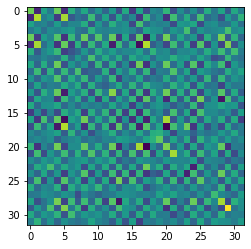

   0.137512  
 -0.0604432  
   0.162577  
  -0.228645  
  0.0796127  
  -0.120845  
  -0.178497  
   0.149491  
   0.227877  
  -0.348244  
   0.101187  
  -0.146213  
   0.134626  
-0.00515201  
 -0.0240619  
  -0.438911  
   0.346417  
  -0.199391  
 -0.0884843  
  -0.121371  
  0.0704676  
  -0.261368  
   0.149972  
  -0.375021  
   0.239035  
  -0.260174  
   0.047015  
  0.0732936  
  -0.121272  
  -0.291243  
   0.120008  
  -0.310015  
c0 :  0.20833333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.203
0.208
0.2055
0.20550000000000002
erreur empirirque = 0.2055
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 2

-0.00979742    0.017347   -0.0477373     0.019468   -0.0154418     0.025459    -0.0459478    0.0378978   -0.0268739   0.0255614   0.00248795    0.0376508   -0.0200961   0.0167243   -0.0337661    0.0365176    -0.0168021    0.0114594  -0.000441717    0.00902848  -0.0342296     0.0294773   -0.0310576    0.0171225   -0.0141918    0.0246662   -0.0230387    0.0278011   -0.0173751     0.0131324     -0.032412    0.0478415  
  0.0278417   -0.052854    0.0836423   -0.0187641    0.0214748   -0.0239535      0.119924   -0.0050294    0.0408368  -0.0498758    0.0660848   -0.0411523    0.0319872  -0.0565722    0.0607882   0.00896114     0.0154287   -0.0192858     0.0183559    -0.0801355   0.0239089    -0.0310576    0.0460581   -0.0806816    0.0196196   -0.0271173  -0.00800788   -0.0673921    0.0144569    -0.0138313     0.0539714   -0.0283289  
 -0.0282184   0.0123513    -0.040775    0.0394815   -0.0285783    0.0258213    -0.0494128     0.053803   -0.0178782   0.0287954   -0.0667029   -0.0108784   -0.0

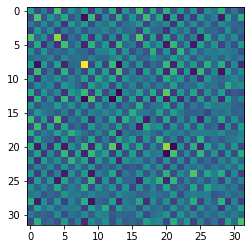

  0.195361  
 -0.235545  
   0.42346  
 -0.408133  
  0.263299  
 -0.227488  
  0.500344  
 -0.163125  
  0.258645  
 -0.143154  
   0.14889  
 -0.173377  
  0.191706  
 -0.204224  
 0.0192707  
  0.102025  
  0.342244  
 -0.358119  
  0.154774  
 0.0572118  
  0.302268  
 -0.298372  
  0.454938  
 -0.357874  
  0.261917  
 -0.231944  
  0.277995  
 -0.172773  
  0.203969  
 -0.110589  
 0.0806894  
-0.0916608  
c0 :  0.20833333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.2
0.194
0.197
0.197
erreur empirirque = 0.197
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
  0.04193

  0.0261118   -0.0119711     0.0358957   -0.0295131    0.0233105    -0.0223146     0.0392986  -0.0186175     0.0147848  -0.0399215     0.0327645   -0.0252441    0.0169872   -0.0310662    0.0355323   -0.0364943     0.0165589    -0.0281884     0.0416122   -0.0467319    0.0298042  -0.0357118      0.064698      0.015311    0.0245366   -0.0343302   0.00838841     0.0226551   0.0389847   -0.0328085   0.0535247   -0.0260544  
 -0.0127795   0.00723752    -0.0299945    0.0099732   -0.0213816     0.0248402    -0.0239733   0.0342857    -0.0129423   0.0280481     -0.026311    0.0189876   -0.0267547    0.0110761    -0.031623    0.0169241    -0.0149519     0.0156081    -0.0358937    0.0223196   -0.0215261   0.0182943   -0.00902533    0.00563434   -0.0179466    0.0272429   -0.0125493    0.00607171  -0.0328085   0.00120047  -0.0305365  0.000183404  
  0.0672797   -0.0408549     -0.017276   -0.0501971    0.0368748    -0.0431004     0.0109992  -0.0305942     0.0557824  -0.0387994     0.0564439     0.016

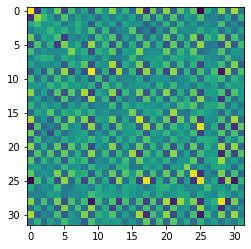

   0.11481  
   0.13978  
-0.0583567  
 -0.251072  
 0.0486941  
 -0.191644  
 0.0591907  
 0.0470037  
 0.0268088  
 -0.358792  
   0.50773  
 -0.351119  
  0.208975  
-0.0855012  
  0.236696  
 -0.466223  
  0.161604  
-0.0899279  
  0.590076  
 -0.196154  
  0.232309  
 -0.295168  
   0.35525  
 -0.159611  
 0.0405477  
  -0.19686  
 0.0463672  
 -0.280493  
  0.289053  
 -0.174965  
  0.117041  
 -0.400221  
c0 :  0.20833333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.168
0.189
0.1785
0.1785
erreur empirirque = 0.1785
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
MM_gathered : 
 0.0

-0.0153924  0.00946359   -0.0246342    0.0206291    -0.0220868   0.00483123    -0.0432184   -0.0122362   -0.0176146      0.02139    -0.049619     0.0291197   -0.0282659    0.0228953    -0.0031164   0.0012659   7.1001e-05    0.0215653   -0.0249498  -0.000721723    -0.011945     0.0194281   0.00780471    0.0576877  -0.0194512    0.0163558    -0.0289836   0.0338804    -0.0251215      0.043104   -0.0104347   0.00291366  
 0.0287085  -0.0342794   0.00992167    0.0142939     0.0317639  -0.00977104    -0.0223231   0.00462022   0.00516139    -0.035816    0.0638369    -0.0482978    0.0269613   -0.0389825     0.0270865  -0.0341258   0.00576311   -0.0219058   0.00415979    -0.0251553      0.03272    -0.0131592   0.00162096   -0.0413348   0.0318949   0.00218291     0.0308478  -0.0285806    0.00102216    -0.0104347    0.0994526   -0.0861882  
-0.0358553   0.0111833   0.00947747    0.0438331    -0.0111326   -0.0035873    -0.0048319    0.0147866  0.000898935   -0.0012524    -0.041449   -0.00492296  -

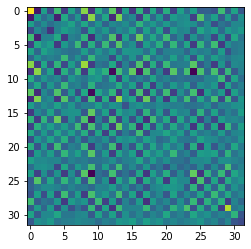

  0.327219  
-0.0921856  
  0.269165  
  0.527932  
-0.0261689  
-0.0614902  
  0.189579  
-0.0777164  
  0.328789  
 -0.205051  
  0.215857  
 -0.474801  
 0.0952175  
-0.0408534  
  0.142394  
 -0.459436  
  0.343388  
 -0.116043  
  0.400769  
 -0.389574  
  0.295752  
 -0.156194  
 0.0664606  
 0.0963824  
  0.207234  
 -0.256309  
0.00183576  
 -0.718752  
 0.0210479  
 -0.202937  
-0.0384752  
 -0.158977  
c0 :  0.20833333333333334
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.179
0.211
0.195
0.195
erreur empirirque = 0.195
[[ 1.         -1.          0.87810366 ... -0.83683291  0.97725561
  -0.97725561]
 [-1.          1.         -0.87810366 ...  0.83683291 -0.97725561
   0.97725561]
 [ 0.87810366 -0.87810366  1.         ... -0.99676869  0.95959846
  -0.95959846]
 ...
 [-0.83683291  0.83683291 -0.99676869 ...  1.         -0.9338963
   0.9338963 ]
 [ 0.97725561 -0.97725561  0.95959846 ... -0.9338963   1.
  -1.        ]
 [-0.97725561  0.9772

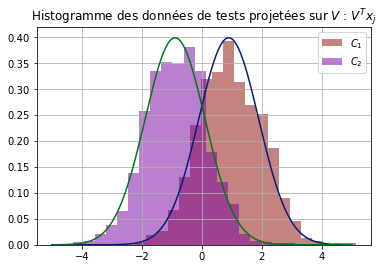

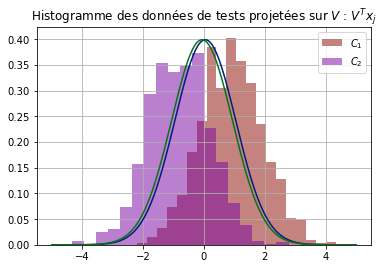

boucle = 16
32
[[50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10]]
n =  1920
c0 :  0.10416666666666667
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 m

  -0.0125692    0.0114818    -0.0153815    0.0190782   -0.0147745     0.0118507   -0.0208139    0.0266152    -0.0183294    0.0154889   -0.0305563     0.0111416   -0.0131304     0.0108572    -0.0246655    0.00132272   -0.00983173    0.0144717   -0.00209209    0.0155714    -0.0138531    0.0153352   -0.0285524     0.0146655   -0.0146586     0.0130532    -0.0277402    0.00369036   -0.0149618    0.0195741    -0.0221467    0.0163134  -0.00931222    0.0145592    -0.021432     0.0154059   -0.0127749    0.00863792    -0.0215777     0.0155571   -0.0179605    0.0123352    -0.0149945     0.0117042    -0.0103609     0.0136269     -0.016581    0.0199695   -0.0110086    0.0150151    0.00301936    0.00959676   -0.0119437     0.0123831   -0.0137367    0.0239981   -0.0133476    0.00978696   -0.00210619     0.0120327    -0.0110139    0.00785082   -0.00234693   -0.00279662  
  0.00937324   -0.0146919    0.00834117  -0.00914566     0.011217    -0.0218581  -0.00981611  -0.00847973     0.0109802   -0.0305563

 -0.00584559   0.00945528   -0.00423395     0.013584   -0.0154866    0.00774035   -0.0211308    0.0152484   -0.00849479    0.0130532  -0.00404259     0.0146473   -0.0116336     0.0122814  -0.000837663     0.0181321     -0.015589    0.0115662    -0.0120273    0.0128867    -0.0168127    0.0156045    -0.004673    0.00951402   -0.0157327    0.00613561    -0.0184362    0.00161751  -0.00916932    0.0197204   -0.00804717     0.029524  -0.00963036    0.0143271   0.00658844     0.0162828   -0.0142226     0.0161711      0.006066     0.0171165  -0.00560239    0.0200738    -0.0128459   0.000742537    -0.0105541     0.0107168   -0.00907837   -0.0059906   -0.0124687    0.0138844   -0.00492364     0.0132596   -0.0108183     0.0117965  -0.00501285   0.00236524   -0.0190009       0.01271    -0.0118057     0.0113722    -0.0141645     0.0114808   -0.00940154     0.0202902  
   0.0158141   -0.0104139     0.0298924   0.00935179    0.0167389    -0.0102584    0.0177604   -0.0190882    0.00367661   -0.0277402

 0.000711766   -0.0179183     0.0260389    0.0257573   0.00447748    -0.0131025       0.0075   0.00718638     0.0132328   -0.0149945    0.0309872   -0.00376169  0.000364048     -0.011267     0.0171321   0.000304962  -0.000374679    0.0112148    -0.0175033   -0.0297895     0.0172939    0.0123447    0.0223832    -0.0218241    0.0208647    -0.0128459     0.0314308    -0.0200377    0.0203263  -0.00582522     0.0139369    0.0110655   0.00767421   -0.0275036  -0.00523223     0.0164369    0.0112574    -0.0177481   -0.00194656   -0.00962897    0.0179847   -0.0190891     0.0119093   0.000788743     0.0251582  -0.000660115    -0.0215102   -0.0265821    0.0020288  -0.00470613     0.0064897   -0.00775752    0.0134252    -0.0206764   0.00841505   0.00567549    0.0167362    -0.0136162    -0.0128721    -0.0148557     0.0115833     -0.019339    -0.0425025   0.000131536  
 -0.00469862    0.0140297    -0.0246423    0.0013542   0.00925574     0.0132469    0.0102985  -0.00854292    -0.0187609    0.0117042

  -0.0243142     0.020643   -0.00460001    0.0217384   -0.0106429    0.00099131    0.0127858    0.0110876    -0.0242344    0.0120327   -0.0147387    0.00609389  -0.00943573     0.0138232    -0.0125464      0.018713   -0.00682557    0.0147638    0.00373705    0.0149284   -0.00966134   0.00996577   -0.0288209      0.024917   -0.0241926     0.0113722    0.00556761     0.0177942  -0.00154148   0.00684859    -0.0139835    0.0312319   -0.0133515    0.0114254  -0.00572727      0.039966   -0.0150029    0.00642289     0.0122767  -0.000400207  -0.00707862    0.0188182    -0.0148557     0.0214037  -0.000541517     0.0125836    -0.0285502  -0.00587109  -0.00730571   0.00133858    -0.0500383    -0.0147497  -0.00296618    0.00428801   -0.0261545  -0.00621132   -0.0102342   0.000547087   -0.00481636    -0.0133188   -0.00845121   0.000950364    -0.0113561  -0.000869784  
    0.012514  -0.00829529    0.00883712  -0.00806878    0.0108364   -0.00738023    0.0124756   -0.0287435    0.00935595   -0.0110139

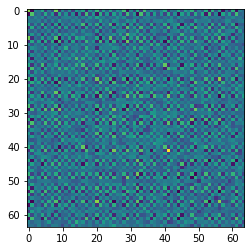

  0.0661692  
 -0.0462331  
   0.170065  
  -0.144009  
   0.202969  
  -0.217152  
   0.293051  
  -0.330611  
  0.0749055  
  -0.312489  
   0.151348  
   0.151771  
    0.12129  
 -0.0906908  
   0.140459  
   -0.39157  
    0.18343  
  -0.127667  
   0.351441  
 -0.0142455  
   0.302875  
  -0.189319  
   0.199922  
  -0.220122  
   0.118596  
   -0.15302  
   0.183449  
   0.120547  
   0.172919  
  -0.252675  
  -0.235844  
  -0.320086  
   0.216002  
  -0.142437  
   0.194766  
-0.00797944  
   0.108725  
 -0.0439177  
  -0.278577  
  -0.382708  
  0.0367794  
  -0.168662  
 -0.0102142  
  -0.238089  
   0.244151  
 -0.0491707  
   0.284754  
   0.127481  
   0.197681  
  -0.245946  
    -0.2189  
 -0.0457644  
  0.0499353  
  -0.153283  
   0.298336  
 0.00622121  
  0.0990083  
 -0.0997121  
  -0.135644  
  -0.240206  
   0.148925  
 0.00782071  
 -0.0520828  
  -0.259452  
c0 :  0.10416666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 

-0.00890677   0.00765861   -0.00415275     0.0138334   -0.0164142   0.00796163    -0.0101344     0.0137892    -0.0094381   0.00574473   -0.0221788   0.00802517  -0.00813068    0.00914552    -0.0042535     0.0128548   -0.00479201     0.0104321   -0.0155338    0.00706785  -0.00627129    0.0100238   -0.0150851    0.00718069   -0.0114241     0.006137    -0.0167077     0.012895   -0.00956889   0.00993155   -0.0150824    0.00902313    -0.0118809    0.00629011    -0.0145031      0.01206  -0.00882712     0.0128899  -0.00689566     0.0104234   -0.00326214   0.00471394    0.00594327    0.00913494    -0.0103524    0.00826272   -0.00818878     0.0097297   -0.00968359     0.0150005   -0.0115399    0.0241172   -0.0182141    0.0110099  -0.00375124     0.018711   -0.0144086    0.00706638    -0.0123623   -0.00122737    -0.0105474      0.009504   -0.00997409     0.0116877  
 0.00893697   -0.0079368    0.00463938   -0.00789725    0.0191596   -0.0125103     0.0200125    -0.0195514     0.0120524   -0.02217

 -0.0120096   0.00906845     -0.019088     0.0219202    -0.014735   0.00643121     0.0011336     0.0266127    -0.0104132    0.0100238  0.000447554  0.000764245   -0.0142136     0.0152749    -0.0156891    0.00848892    -0.0158417     0.0127572   -0.0172075    0.00353163  -0.00903716    0.0185399   -0.0161186    0.00544357   -0.0142071    0.0177446   -0.00581049   0.00710692    -0.0127888    0.0141709  -0.00323597    0.00556441    -0.0175099    0.00559889    -0.0140776    0.0298355   -0.0148799     0.0121343   -0.0219549     0.0135746    -0.0135427    0.0120037    -0.0160978     0.0188576    -0.0192078      0.013184    -0.0170219     0.0261253    -0.0122592     0.0111058    -0.020305   0.00908037   -0.0103472   0.00531558   -0.0141766   0.00792312   -0.0150296     0.0082756    -0.0054861     0.0146477    -0.0198649     0.0127265   -0.00840997     0.0240998  
  0.0189932   -0.0145154    0.00318922    -0.0038455    0.0143745  -0.00801921     0.0119257    -0.0115048     0.0111921   -0.01508

 -0.0130158    0.0169239   -0.00946122     0.0165899    -0.013814   0.00940554  -0.000618165     0.0252473     -0.014819    0.0128899   -0.0101613   0.00437991   -0.0114809    0.00751444     -0.011984     0.0131048    -0.0144031     0.0107079   -0.0106605     0.0147483  -0.00982117    0.0121343   -0.0220322    0.00354434   -0.0107595   0.00866792    -0.0106676    0.0114654    -0.0118517    0.0119986  -0.00400317     0.0142003   -0.00844994     0.0121109    -0.0136081   0.00717187  -0.00824814   -0.00489528   -0.0178663      0.032978    -0.0141338   0.00525609   -0.00868592     0.0147099    -0.0179671     0.0133306   -0.00829534     0.0109036    -0.0177733     0.0128471    -0.014277   0.00789651   -0.0182864   0.00947756   -0.0243991  -0.00288546  -0.00985672    0.00909377    -0.0101982     0.0029141    -0.0135835     0.0101539      -0.01445     0.0185792  
 0.00167687  -0.00726856    0.00791919    -0.0415772    0.0169111    -0.014987    0.00964494   -0.00177843     0.0182302  -0.006895

-0.00487242    0.0169377    -0.0270348    0.00199889  -0.00827522    0.0216409    -0.0165379    -0.0150501    -0.0110368    0.0241172  -0.00483484   -0.0042409  -0.00952908    0.00783471     0.0106581     0.0315484    0.00238936   -0.00538211   -0.0219729     0.0393255  -0.00317668   0.00908037   -0.0219893     0.0296896   -0.0300838    0.0176468     -0.036926    0.0143684    -0.0198361  -0.00577929   -0.0200317     0.0134968    -0.0103341    0.00602413    -0.0116971    0.0217136   -0.0237905    0.00789651   -0.0346362     0.0170249   -0.00474498    0.0100836    -0.0200089     0.0032373    -0.0115966     0.0194281   -0.00115882   -0.00487819     -0.012185      0.018833  -0.00690354   -0.0288562   -0.0144036     0.011494   -0.0181679  0.000671085   -0.0142546    0.00179598    -0.0215074     0.0509976   -0.00702241     0.0119058   -0.00577171     0.0133202  
  0.0129911   -0.0121597      0.014263   -0.00790143    0.0122841   -0.0100345    0.00600843    -0.0241367    0.00678561   -0.01821

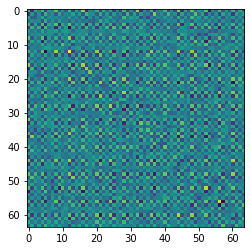

  0.173204  
 -0.210473  
 -0.364812  
-0.0602266  
  0.354976  
 -0.296786  
  0.300997  
 -0.131175  
 0.0981734  
 -0.152576  
 0.0927636  
-0.0101178  
  0.233359  
-0.0994464  
  0.278726  
 -0.305994  
  0.160262  
 -0.224469  
  0.395316  
  0.031486  
 0.0693117  
 -0.366813  
 0.0354059  
 -0.191656  
  0.229198  
-0.0997341  
  0.107906  
 -0.379945  
  0.236158  
-0.0512151  
  0.224205  
 0.0607214  
  0.184689  
 -0.319279  
 0.0195757  
 -0.672711  
    0.1702  
 -0.226465  
  0.441759  
-0.0744357  
  0.133937  
 -0.109184  
   0.19204  
 -0.382119  
  0.367138  
 -0.256393  
  0.385945  
 -0.280081  
  0.362565  
-0.0840201  
  0.268305  
  -0.25564  
  0.188101  
 -0.162367  
  0.369586  
 -0.229381  
  0.289686  
 -0.240448  
   0.12853  
-0.0530986  
  0.276085  
 -0.165688  
  0.325593  
 -0.666219  
c0 :  0.10416666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.172
0.169
0.1705
0.17049999999999998
erreur empirirque

  0.00903377  -0.000871585     0.0137585    -0.0233947    0.0264597   -0.0233869     0.0440178    -0.0126674     0.0186752    0.00330667    0.0183072   0.00950361   0.00156646   -0.0207928      0.022041    0.00994781    0.0173681    -0.0101728     0.035911    -0.0100786    0.0175328   -0.00660591    0.0151996   0.00963887     0.0243769    0.00204706     0.0084291     -0.015595    0.00224646   -0.0233153    0.0117322  -1.21067e-05     0.0107113      0.011468     0.0223184    -0.0013474   0.00535829   -0.0195256   0.00431197   -0.0247674    0.0066844   -0.0167159    0.0143979    -0.0351906   0.00358288  -0.00617084  8.13841e-06  -0.00812884    0.00463848    -0.0097506     0.0284927    -0.0295662     0.0122883   -0.00313077   -0.00749713   -0.0147182    0.0020268  -0.000928493     0.0275028    0.0120012    0.00487041  -0.00938413     0.0120315    -0.033375  
  -0.0142122     0.0104956    -0.0376566    -0.0149202   -0.0150066     0.027089    -0.0271237    0.00673199    -0.0111996     0.021

   0.0154012   0.000756335   -0.00795911    0.00299475    0.0115101   -0.0203392     0.0202751    -0.0187317     0.0144268    -0.0185969   -0.0320391  -0.00441165    0.0101714   -0.0139733     0.0084291    0.00141039   0.00812586    -0.0169984  -0.00528812   -0.00984743   0.00886295   -0.00637155  -0.00523784   -0.0167315     0.0114778     -0.014369   -0.00390157    -0.0280442     0.0040646  -0.00934526  -0.00343455    -0.0390142      0.004602   -0.00230944    0.00833846     -0.016705    0.0102611  -0.00921564    0.0132925  -0.00205764     0.009842   -0.0102805  -0.00344192    -0.0308921    0.0157335   0.00138685   0.00150712   -0.0231753    0.00409291    -0.0216133     0.0233087  -0.000355564     0.0164191    -0.0154638  -0.000378589   0.00236746   0.00611363    -0.0161915     0.0120617   0.00365164    0.00774246  -0.00520003     0.0135176   -0.0125764  
   -0.014055     0.0169755    -0.0192149     0.0309499   -0.0194463     0.014978  -0.000846333     0.0250978    -0.0311861     0.013

  -0.0104111    0.00968151   -0.00117054    0.00847928   -0.0116469    0.0115557   -0.00981328   -0.00237793   -0.00733672     0.0121883   -0.0200043   0.00584386   -0.0205157    0.0185598    -0.0195256    0.00551247  -0.00719507     0.0142314   -0.0168373     0.0142943  -0.00527247     0.0137837   -0.0117758    0.0102292     -0.010498     0.0091835   -0.00921564    -0.0074675   -0.00771409   0.00975738  -0.00281929     0.0151945   -0.00891655      0.014291    -0.0134349     0.0114497   -0.0159125    0.0159537   0.00502102    0.0253555   -0.0101665    0.0134424   -0.0103656     0.0183373  -0.00601542   0.00788467  -0.00774706    0.0169953   0.000127812    0.00984002    -0.0155019     0.0052398    -0.0110729    0.00499763    -0.0101321    0.0162945    -0.010999     0.0167903    -0.0050141    0.0067986    -0.0164237    0.0154503   -0.00201259   0.00512921  
  0.00159841   -0.00892958     0.0035586   -0.00517113    0.0132024  -0.00926665   2.61358e-05   -0.00127634     0.0112858    -0.012

   0.0145178    -0.0196037    0.00680826    0.00444443   0.00396058   -0.0048657   0.000487321   -0.00469212     0.0172806    -0.0320905   0.00916152   -0.0297863    0.0143794   -0.0040648   -0.00749713   -0.00030951  0.000831051   0.000325661  -0.00664366    -0.0242352   -0.0116937    -0.0228203  -0.00434408    0.0246273     0.0175685    -0.0186256  -0.000378589    -0.0257203     0.0116107   -0.0111758   0.00935489    -0.0285495     0.0223646    -0.0255105    -0.0210338     0.0295252    0.0205252   -0.0101321    0.0278699  -0.00673679    0.0045334   -0.0105951   0.00903565    -0.0192138    0.0083065  -0.00799845    0.0209227    0.0274267     0.0134701    -0.0167552     0.0213291   -0.00897005     0.0153608    -0.0187688     0.0131286   -0.0174361    0.0099746    -0.0157976    -0.0389851   -0.0506296     0.0141849  -0.00590055    0.00542162    0.0177461  
 -0.00266088    0.00370401    -0.0155781     0.0239545   -0.0206512   0.00324466     0.0100697   -0.00501479    0.00226042    0.0010

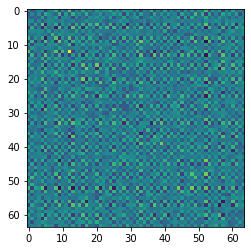

  -0.147859  
  -0.202555  
  0.0872014  
  -0.459824  
   0.345821  
  -0.169848  
 -0.0331671  
  -0.133778  
   0.130704  
  -0.278432  
 -0.0174985  
   0.214848  
  0.0440912  
  -0.276677  
   0.343116  
  -0.203436  
 -0.0361227  
  -0.237976  
   0.214408  
  0.0695117  
   0.123497  
 -0.0944343  
      0.313  
   0.163594  
   0.226741  
  -0.190211  
  -0.116592  
  -0.461556  
   0.175436  
  -0.221126  
   0.206922  
   0.229582  
   0.221036  
  -0.207594  
  -0.190528  
   0.219005  
   0.178397  
 -0.0797699  
  0.0653194  
 -0.0374642  
   0.020471  
  -0.193236  
  -0.132105  
  0.0339725  
   0.260048  
  -0.268326  
   0.503114  
  -0.505081  
   0.243057  
 -0.0950382  
-0.00671496  
   0.202278  
  0.0748774  
 -0.0921398  
 0.00671795  
  -0.364532  
  0.0849378  
  0.0783932  
  -0.254701  
  -0.335261  
 -0.0908903  
  -0.137909  
  -0.031368  
  -0.240738  
c0 :  0.10416666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 

 0.00663609    -0.0122394    0.0197677     0.0062751    0.00879865    -0.0124729     0.0130625   -0.00298154   0.00943008  -0.00891969     0.0133006   -0.00739117    0.0187733     -0.014703    0.0159694   -0.00654799    0.00906948   -0.0109392   0.00953846   -0.0236018   0.00689145   -0.00973572   0.00790933   -0.0192684    0.0134713  -0.00994842  -0.00377267   -0.0160884   0.00741958   -0.0110644    0.0109791   -0.00046958     0.0111352   -0.0130246     0.0195834    -0.0177076    0.0074728   -0.00947585   0.000784448  -0.00433258     0.0123576    -0.0129715     0.0072462   -0.00912132    0.0115765    -0.007279    0.0147249    0.00809235    0.0097652    -0.0101107    0.00647267   -0.0137257     0.0140519   -0.00966741    0.0294137   -0.0197537     0.0110068   -0.0119522     0.0167022   0.000623463    0.0147007   -0.00886601     0.0144924   -0.00311966  
-0.00389604     0.0101464   -0.0199158     0.0140205   -0.00394731    0.00174262    -0.0212507    0.00797076  -0.00891969    0.0114662

 -0.0149424     0.0106031    -0.006649     0.0364158    -0.0147618     0.0136876     -0.009545    0.00712736   -0.0192684   0.00313352    -0.0283995    -0.0196189  -0.00750244     0.0110836   -0.0378772    0.00860478   0.000710011    0.0215897  -0.00415157    0.0192409    -0.023662     0.0156836  -0.00356575    0.0201967  -0.00641447    0.0249506    0.0231355      0.04861   -0.0162597    0.0168254   -0.0205356    -0.0155582   -0.00738194   0.00422807     -0.012221     0.0181045   -0.0050219    0.00516041    -0.0281376  0.000167488    0.00431646    0.00786082    -0.0149678    0.00890681   -0.0148122  0.000348831  -0.00148012   -0.00355921   0.00659863     0.0235243       0.00451    0.0281272    -0.0167601     0.0192055   -0.0383875  -0.00207839    -0.0241681    0.0325778    -0.0254783     0.0247935   -0.0261048     0.0147627   -0.00699736     0.0230502  
  0.0119101   -0.00383841    0.0113572     0.0109459     0.0147091   -0.00945596    0.00610736    -0.0119339    0.0134713  -0.00688524

  0.0114186   -0.00619732    0.0163542    0.00120002    0.00385824    -0.0127999    0.00526581   -0.00522692    0.0123576  0.000384605     0.0177943  -0.000748244   0.00953138     -0.012459  -0.00168598   -0.00179092     0.0128869  -0.00517522   -0.0051342  -0.00996891    0.0113119   -0.00467063   0.00236495   0.00431646    0.0103788  -0.00947813    0.0107243   -0.0089734    0.0119841  -0.00795046    0.0131622    0.00215495     0.0153535  -0.00900758   0.000614395    -0.0118851   0.00492707   -0.00205642   -0.00757743  -0.00206706     0.0127776    -0.0141462     0.0138707     -0.017162    0.0148794   -0.0132731   0.00101881     -0.011427   0.00463628   -0.00212553    0.00264501   -0.0144108     0.0122004   -0.00609408    0.0161873  -0.00853132     0.0113249  -0.00640821      0.013486   -0.00764941   0.00648982    -0.0171272     0.0160076   -0.00604393  
-0.00792203     0.0111097  -0.00638015      0.018027   -0.00655226     0.0173969     -0.012391    0.00240323   -0.0129715   0.00783291

 -0.0131719     0.0168222   -0.0118023    0.00781874    -0.0137972    0.00874191    -0.0168256     0.0186019   -0.0119522    0.0107828   -0.00659728   -0.00283306   -0.0147572     0.0125316   -0.0102785    0.00855108    -0.0064462   0.00916937   -0.0166047    0.0182487   -0.0123343     0.0105802   0.00267343    0.0325778  -0.00440636    0.0155892  -0.00637048    0.0297532   -0.0105111   0.00961513  -0.00754516    0.00349204    -0.0150021   0.00590734    -0.0220786     0.0128873   -0.0114725    0.00492893    -0.0220938    0.0124895   -0.00640821    0.00828179   -0.00740575    0.00678017   -0.0161689   0.00862608   -0.0210615    0.00731685  -0.00792275     0.0125233   -0.00754841    0.0197914   -0.00564586     0.0113724  -0.00885972    0.0135994    -0.0158683    0.0209368   -0.00973989     0.0206681   -0.0157361     0.0174762   -0.00991656   -0.00306242  
  0.0192492    -0.0111515    0.0289562    -0.0142202  -2.89307e-05    -0.0205577    -0.0141416    -0.0123973    0.0167022   -0.0172711

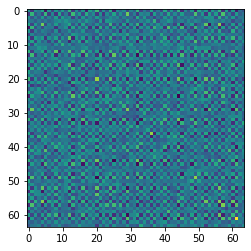

 0.0854172  
 -0.111996  
  0.343221  
  -0.25442  
  0.223422  
 -0.177372  
  0.285351  
  -0.13071  
  0.110786  
 -0.309114  
  0.312888  
 -0.323023  
 0.0331474  
 -0.215778  
  0.135533  
 -0.699125  
  0.167253  
 -0.269029  
 0.0630821  
 -0.127831  
  0.300147  
 -0.188863  
   0.24742  
 -0.390466  
-0.0146059  
-0.0192195  
  0.234144  
 -0.242494  
  0.150107  
 -0.202922  
  0.116874  
 -0.325733  
  0.326066  
 -0.136793  
  0.403837  
 -0.540539  
 0.0345783  
  -0.47714  
  0.295518  
 -0.349808  
  0.131427  
 -0.215685  
  0.117248  
 -0.121881  
  0.117892  
-0.0915584  
  0.241392  
 -0.265534  
  0.119362  
 -0.183364  
-0.0644379  
  0.095933  
  0.191178  
 0.0143402  
 0.0693313  
 -0.424044  
  0.306268  
 -0.167988  
  0.396078  
 -0.272198  
  0.334101  
 -0.100106  
  0.176771  
 -0.100741  
c0 :  0.10416666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.181
0.175
0.178
0.178
erreur empirirque = 0.178
 moiti

-0.00476976    0.00629783    -0.0305502     0.0204226   -0.00134559   0.00539546  -0.00292466   0.00921027   -0.00510166   0.00506711  -0.00775581    0.00969845   -0.0135905    0.0125985    0.00598738    -0.0158536  -0.00810472   0.00162392     -0.024534  -0.00820056   -0.0046496    0.0161191   -0.00565188     0.0243743  -0.00296907    0.00352535  -0.00739523      0.01209   -0.0149102   -0.00167069   -0.0149085  -0.00393352   -0.0233134  0.000534048    -0.0239122    0.0301951   -0.0241543  -0.00067414    -0.0258932    0.0209989   0.000355201    0.0128746   -0.0112296    0.00145466  -0.00419686     0.0022817     -0.013429    0.0118663   -0.00515644    0.0160966    -0.0202971   -0.00205491   -0.0154749   0.00569562   -0.0165747    -0.0279737  -0.000422707    0.0090976    0.00786826    0.00582423   -0.0138874    0.0150759   0.00213785     0.0215921  
  0.0123867    -0.0112584   -0.00170329    -0.0122025     0.0075578   -0.0136298    0.0218594   -0.0188941     0.0130749  -0.00950917    0.0

 0.00198543     0.0181767     0.0055969     0.0188415   -0.00172008   0.00976652  -0.00183408    0.0281521    -0.0159779    0.0236734   0.00227912     0.0183295  -0.00751028   0.00466184    0.00148897       0.01209  -0.00158824   0.00726408    -0.0158482    0.0120581  -0.00308604    0.0282634     0.0196319     0.0084815   -0.0150405     0.0117112    0.0290757    0.0291952   -0.0107246     0.0088604   -0.0364863    0.0269973   -0.0184265   0.00838888    0.00787048    0.0344883   -0.0108185   0.00723548   3.68339e-05   0.00463944    -0.0168738   0.00128129  -0.00953732    0.00508492   -0.0102732     0.0126097    0.00672447    -0.022221   -0.00309533    0.0194202     0.0330321     0.0165061   0.00399943  -0.00500285  -0.00804283    0.00344863   -0.00049156  -0.00294957   -0.00133088    -0.0106598   -0.0141744   0.00889719  -0.00917137     0.0139783  
  0.0101982    -0.0070393     0.0116703   -0.00875305     0.0046858  -0.00928771  -0.00323649   -0.0069814     0.0145698   -0.0122866   0.00

-0.00507007     0.0073555   -0.00628852     0.0111608   -0.00637785   0.00741151   0.00253725   0.00630756    -0.0159216   0.00836718   -0.0154628    0.00641882   -0.0130784     0.018366    -0.0214767   -0.00067414   -0.0152099    0.0159833   -0.00945866    0.0142676   -0.0140712   0.00711061    -0.0199707     0.0243424  -0.00769065    0.00871737   -0.0162092   0.00723548  -0.00583673     0.0117853   -0.0187643    0.0072975   -0.0127099    0.0100867    -0.0111387     0.007486   -0.0130965   0.00645099    -0.0158368     0.010416   -0.00979974   0.00990712   -0.0168048   -0.00238613   -0.0151505     0.0147809    0.00294084   0.00980122    -0.0136733    0.0128192    -0.0180531     0.0152401  -0.00765799   0.00578079   -0.0300841     0.0308755   -0.00657549   0.00933683    -0.0113101   -0.00202997   -0.0159856    0.0064659  -0.00553481     0.0127937  
  0.0127897    -0.0107141     0.0164371    -0.0198088     0.0120676   0.00170003  0.000256944  -0.00821832    0.00733393   -0.0180593     0.

 -0.0121306     0.0135617    -0.0224355    0.00172313   -0.00645181    0.0121484  -0.00638448    0.0157856    -0.0232215     0.017014  -0.00241087     0.0054457   -0.0137234    0.0175342   -0.00728562     0.0160966   -0.0155804    0.0115808     -0.009929    0.0171336  -0.00994283    0.0137612    -0.0200727     0.0162884   -0.0190924     0.0134865   -0.0135199    0.0194202   -0.0169272     0.0148135    -0.012035    0.0158446   -0.0187427    0.0122675   -0.00453763    0.0138112   -0.0163119    0.0128192    -0.0171481    0.0173176    -0.0112877     0.015255   -0.0180793     0.0221021   -0.0163345     0.0134441   -0.00719391    0.0230441    -0.0180046     0.014951    -0.0276537    0.00840833   -0.0112278    0.0127575   -0.0145096    0.00287539    -0.0138043     0.013213    -0.0112477   -0.00105016   -0.0197406    0.0158687  -0.00498093     0.0286717  
0.000266039   -0.00455328     0.0102542    -0.0123887    0.00683099   -0.0153161    0.0163525   0.00395036     0.0199103  -0.00166442   0.00

 -0.0107401      0.013029      -0.01671    0.00499237   -0.00896905    0.0114216   -0.0178198     0.013263    -0.0118857    0.0161639   -0.0190784    0.00867894   -0.0108184    0.0101906    -0.0233509     0.0150759   -0.0143546    0.0161128    -0.0100196    0.0110621   -0.0153607    0.0111783    -0.0240796     0.0191915   -0.0120912    0.00616531   -0.0246701   0.00889719   -0.0149099     0.0107123  -0.00644677    0.0154185   -0.0157722    0.0137904    -0.0207506  0.000687416   -0.0081952    0.0064659    -0.0239614      0.02487   -0.00855094   0.00913711    -0.026525    0.00418666    -0.015608     0.0108595    -0.0118189   0.00785351    -0.0114943    0.0158687    -0.0171194    0.00830055  -0.00453444    0.0149817   -0.0102803     0.0125209    -0.0162684    0.0113991    0.00264743    0.00078393   -0.0118759    0.0114671  -0.00259792     0.0102037  
 0.00231787    0.00637135      0.026884     0.0234125    0.00136568   -0.0145646    0.0187248    0.0150936     0.0211157   -0.0122031  -0.00

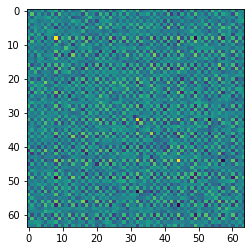

 0.0798695  
 -0.259724  
  0.154357  
  0.217793  
 0.0307049  
 0.0662737  
  0.443638  
 -0.584238  
 0.0717615  
 -0.171853  
  0.140978  
 -0.112015  
  0.191977  
 -0.390522  
  -0.43621  
 -0.473372  
  0.078776  
 -0.263072  
  0.847811  
  0.033871  
  0.220961  
-0.0913106  
  0.275796  
 -0.543052  
  0.227719  
-0.0700244  
  0.260176  
 -0.111482  
  0.177148  
 -0.224431  
  0.247222  
 -0.306794  
   0.23099  
 -0.200449  
  0.169293  
 -0.286908  
  0.134836  
 -0.148343  
  0.323287  
 -0.423302  
  0.229425  
 -0.233212  
  0.541867  
  0.130532  
  0.191224  
 -0.196689  
  0.177157  
 0.0971156  
  0.197445  
 -0.205812  
  0.196771  
 -0.285645  
   0.13643  
  -0.27738  
 0.0581728  
 0.0553236  
   0.27804  
  -0.15583  
  0.211708  
 0.0158548  
  0.178256  
 -0.185708  
 0.0204938  
 -0.366674  
c0 :  0.10416666666666667
rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
0.157
0.184
0.1705
0.17049999999999998
erreur empirirque

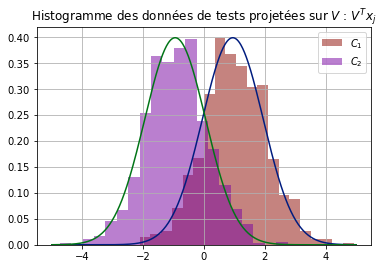

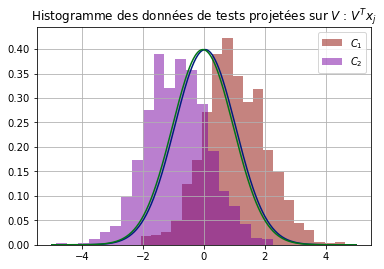

boucle = 32
64
[[50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10], [50, 50], [10, 10]]
n =  3840
c0 :  0.052083333333333336
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie = 25
 moitie = 25
 moitie = 5
 moitie = 5
 moitie

  0.00813342   -0.00523252    0.00511012   -0.00512313    0.00611018   -0.00496478     0.0019534    -0.0164633    0.00168092   -0.00577448    0.00760856    0.00931047    0.0111616   -0.00623208    0.00599952   -0.00315861    0.00883923   -0.00712938    0.00913565    -0.0243329    0.00398778    0.00221023    0.00344762   4.92223e-05    0.00371558   -0.00555577   -0.00191851    -0.0190461   -0.00149844   -0.00229184    0.0167195    -0.0111906    0.00545386   -0.00711612    0.00378679   -0.00284794    0.00724385    0.00254939     0.0258523   -0.00810772    0.00388769   -0.00892405   -0.00507059    0.00790307   -0.00212399   -0.00773559     0.0108755    -0.0141214    0.00851721   -0.00619097      0.016628    0.00505679    0.00290495   -0.00221755    0.00272926    -0.0180607    0.00811359  -0.00904902    -0.0139006   -0.00997687    0.00158583   -0.00714434     0.0135247  -0.000198135    0.00545822   -0.00589767    0.00472409    -0.0136223    0.00719524   -0.00715756    0.00388613   -0.00966

 -0.00500105    0.00592199   -0.00401239     0.0106005   -0.00640982    0.00497397   -0.00623208    0.00823895   -0.00817889    0.00391808   -0.00723997    0.00750738    -0.006654  -0.000159284   -0.00506663    0.00602165    -0.0123753    0.00555139   -0.00443008      0.003861   -0.00753621    0.00578144   -0.00354427    0.00946977   -0.00815144    0.00713839   -0.00459338    0.00475032   -0.00937649    0.00631059  -0.00359227    0.00683224   -0.00812406    0.00684032    -0.0060763    0.00372683   -0.00446783    0.00701597   -0.00568033    0.00560658   -0.00256021    0.00635842   -0.00710826    0.00867226   -0.00541168    0.00726298   -0.00725149    0.00756808   -0.00740005    0.00378171   -0.00768037     0.0141843   -0.00459418    0.00796183   -0.00753266     0.0133295   -0.00774646   0.00524112   -0.00950036    0.00680225   -0.00629024    0.00469692   -0.00139896    0.00925298   -0.00575326    0.00650518   -0.00820157   -0.00187965   -0.00463822     0.0056617   -0.00440667    0.00238

  0.00047663     0.0036913     -0.015955  -0.000759197   -0.00660676      0.013447    -0.0243329    0.00825541   -0.00153433   0.000619355    -0.0128097    0.00744649  -0.00437091      0.003861    -0.0106831      0.014515   -0.00461791      0.011943    0.00966893    0.00374517  -0.000800345    0.00159144    0.00286697  -0.000550754   -0.00760506    0.00399295   -0.00745547     0.0178732   -0.00229653    0.00881923    -0.011353   -0.00252258   0.000373134    0.00326126    -0.0131632     -0.010644  -0.000667311    0.00350957    0.00655065   -0.00877766   -0.00582866   0.000892384    0.00911453    0.00973336    0.00611011    0.00181348   -0.00588222    0.00305712   0.000178861    0.00392443   -0.00730434    -0.0115229   0.000449353    0.00158967    -0.0152831  -0.000911528   -0.00281889   0.00914399   -0.00620813   -0.00296695   -0.00501997    0.00351268    0.00301389   -0.00695547  -6.16354e-05    0.00200837     0.0172405   -0.00843115    -0.0116571    0.00341189    -0.0115054   -0.00491

  0.00723034   -0.00431916   -0.00494649    -0.0144002     0.0122977    0.00181658   -0.00191851    -0.0185028    0.00333425   -0.00199969     0.0126994    0.00143047   0.00598816   -0.00459338    0.00632194     0.0038442     0.0107231    -0.0048725     0.0100717   -0.00745547    0.00926177   -0.00434444    0.00493733   -0.00988415    0.00209165   -0.00694716    -0.0344377    -0.0144267     0.0134466   -0.00617303  -0.00806517   -0.00120094    0.00565474  -0.000822676    0.00832394   -0.00544641  -0.000845305   -0.00247417   -0.00495991    -0.0120808   0.000533388   -0.00382602   -0.00172446    0.00912747    0.00552561   -0.00454733    0.00509735   -0.00224648    0.00498046   -0.00126185     0.0141554   -0.00670831     0.0017737   -0.00245213     0.0079299    -0.0117815    0.00470071  -0.00900462    0.00187123    0.00438384    0.00329405   -0.00760859    0.00533466    -0.0133626    0.00713965   -0.00395508   -0.00236888  -0.000324388     0.0051587   0.000595933     0.0131259    -0.0166

  0.00629898   -0.00455584   0.000599602   -0.00946321    0.00812905   -0.00354123    0.00545386   -0.00434779    0.00549058   -0.00759708    0.00206804    -0.0142927   0.00879818   -0.00812406     0.0053956   -0.00500422    0.00568355   -0.00739692     0.0100496   0.000373134    0.00728238   -0.00446763   0.000205854   -0.00447674    0.00467493     -0.005136    0.00565474   -0.00587631    0.00573612    -0.0033039   0.00165092   -0.00472227    0.00315976   -0.00788471    0.00579039   -0.00618956    0.00901363   -0.00462313   0.000708601    -0.0139629    0.00268947   -0.00178234    0.00263253   -0.00243897    0.00422142   -0.00722377    0.00690422    -0.0115505    0.00675556   -0.00138139    0.00450176   -0.00592704    0.00467634   -0.00241604    0.00849917   -0.00691244     0.0043322  -0.00479375     0.0087316   -0.00748422    0.00719214   -0.00490027   0.000902746   -0.00696519    0.00355477   -0.00736503  -0.000815118   -0.00730334    0.00632203   -0.00609265    0.00776676   -0.00733

 -0.00322236     0.0020136  -9.84137e-05   -0.00506481    0.00571229   -0.00174544     0.0258523     -0.017725    0.00274379   -0.00500052      0.011685   -0.00478518   0.00651558   -0.00568033     0.0138201   -0.00155757    0.00369916    0.00406369    0.00855423    0.00655065    0.00330161   -0.00046826      0.013387    0.00944535    0.00562852   -0.00890362   -0.00495991   -0.00291915    0.00917095   -0.00426137    0.0135166    0.00356054   0.000708601   -0.00311187   -0.00222005   -0.00309803     0.0111991   -0.00382814     0.0190388   -0.00467879   -0.00520918   -0.00974759   -0.00231269    0.00306698    0.00902007   -0.00310049    -0.0039013   0.000400902   -0.00332714   -0.00393283     0.0116888    -0.0135278  -0.000200404   -0.00383984    0.00537729    -0.0164229    0.00581591   -0.0100944    -0.0172732    -0.0206561    0.00714492  -0.000405055     0.0149518   0.000369236    0.00285485   -0.00707966     0.0290824   -0.00735168    0.00733724   -0.00760125     0.0160336     -0.009

  0.00381633   -0.00631411  -0.000936062    -0.0082069    0.00451471   -0.00421799   -0.00212399   -0.00258092    0.00611268   -0.00272543    0.00535696   -0.00275238   0.00592878   -0.00541168   -0.00199797   -0.00236091    0.00490403   -0.00537213     0.0105749    0.00611011    0.00759738   -0.00826222   -0.00185816   -0.00469037    0.00336234   -0.00773651    0.00552561   -0.00555751    0.00689206   -0.00216942    -0.003678     0.0037386    0.00422142   -0.00398422    0.00154665   -0.00666479    0.00601877   -0.00556654    0.00902007   -0.00898912    0.00517836   -0.00410711    0.00719135   -0.00675726    0.00592719   -0.00869447    0.00422922   -0.00400194    0.00873145   -0.00356059     0.0106218   -0.00823177    0.00348507   -0.00526512    0.00598933   -9.1745e-05    0.00627829  -0.00657023    0.00321367   -0.00861179    0.00306275   -0.00249506    0.00513607    -0.0169416    0.00483109   -0.00373797    0.00406872  -0.000185128    0.00276992   -0.00269432    0.00828308   -0.00262

 -0.00454104     0.0066824  -0.000783643     0.0128858   -0.00818929    0.00387529    0.00505679     0.0133404   -0.00410211    0.00571907    -0.0152011    0.00628387   -0.0103469     0.0141843    -0.0102536     0.0171034   -0.00919633    0.00304248   -0.00211226    -0.0115229    -0.0110558    0.00841093   -0.00879503     0.0131273     -0.010668     0.0148013   -0.00670831   -0.00460829   -0.00774641    0.00786448   -0.0030265     -0.001256   -0.00592704    0.00540672   -0.00851107     0.0220681   -0.00858675    0.00576051    -0.0135278    0.00622618   -0.00339909    0.00464374   -0.00844449     0.0169873   -0.00823177     0.0121834    0.00179182    0.00578489   -0.00618564    0.00483303   -0.00735042    -0.0211777   -0.00855465     0.0122811   -0.00360693     0.0104506   -0.00464193    0.0070568   -0.00019795    0.00610465   -0.00553864    0.00525501   -0.00228404    0.00451134   -0.00319776    0.00919494    -0.0217128    0.00146962   -0.00495968    0.00340272   -0.00210011     0.0144

   0.0077412    -0.0141437     0.0135112   -0.00890925    0.00283099   -0.00676204    -0.0139006   -0.00362035     0.0100928    -0.0116312     0.0129214     -0.019569   0.00529746   -0.00950036   -0.00419517    0.00659643    0.00598538    -0.0104093  -0.000645114   -0.00620813    0.00181801   -0.00372154    0.00994807   -0.00613744    0.00316297   -0.00426481    0.00187123   -0.00346526      0.010552   -0.00857311   0.00910658   -0.00496536     0.0087316   -0.00363024    0.00957361   -0.00724241    0.00281721   -0.00810307    -0.0172732    0.00694862     0.0094383   -0.00692485   -0.00993595    -0.0137155    0.00321367   -0.00666073    0.00403181   -0.00949012    0.00160711   -0.00464186     0.0132225   -0.00019795    0.00785865    0.00342679     0.0068254    0.00714257    0.00653275  -0.00254185     0.0344585   -0.00133072    0.00648915   -0.00146024    0.00508432   -0.00138005    0.00558875    -0.0105829   -0.00326699    -0.0122387    0.00931199   -0.00584123    0.00234684   -0.00608

  0.00395317   -0.00713875   -0.00377295   -0.00914944    0.00821127   -0.00812715    0.00472409    -0.0144972    0.00372851   -0.00693223      0.016415   -0.00810179   0.00678489   -0.00820157     0.0108784    0.00905426     0.0117374   -0.00515236     0.0162768     0.0172405    0.00673811   -0.00628437     0.0223998    -0.0170932    0.00755982    -0.0127402   -0.00236888   0.000129399     0.0138744   -0.00820811   0.00220046    -0.0086663  -0.000815118   -0.00325406    0.00430642   -0.00181395   -0.00460363   -0.00257633     0.0290824   -0.00397264    0.00552974    -0.0122576     0.0137745    -0.0202864    0.00406872   -0.00820445   -0.00520548     0.0114562    0.00610026   -0.00239991    0.00756253    -0.0217128    0.00870826    -0.0105443    0.00292366    -0.0285942     0.0128527  -0.00436852   -0.00326699   -0.00345088  -0.000800626    0.00234662      0.015439    -0.0147529    0.00653931   -0.00572854   0.000205484   -0.00962344    0.00341351   -0.00234391   -0.00120871   -0.00469

  0.00250465     -0.008324     0.0120446   -0.00998257     0.0072246   -0.00349946      0.011529    -0.0200488    0.00887676   -0.00308242    0.00588619   -0.00799495   0.00502365   -0.00472765    0.00354456    -0.0007147    0.00324926   -0.00459019    0.00439902    0.00200808    0.00999228   -0.00903262   -0.00150249    -0.0129968    0.00726069    -0.0121069     0.0125658   -0.00839142    0.00451406    -0.0029564    0.0112147   -0.00716481    0.00368173    -0.0120664     0.0162844    -0.0166455     0.0108597   -0.00682883     0.0162949  -7.13485e-05    0.00403577   -0.00750717    0.00409507   -0.00589768    0.00775782    -0.0155302     0.0155579   -0.00830691   0.000558744   -0.00517611     0.0103215    -0.0106355    0.00343052   -0.00591977   1.83429e-05    -0.0122035    0.00950414  -0.00932193   0.000865905    -0.0274677    0.00513681   -0.00356085   -0.00468302    -0.0231788   -0.00250275   -0.00550224     0.0171675  -0.000609225    0.00797641   -0.00807108     0.0082167   -0.00225

 0.000803106     -0.005348    -0.0011787    -0.0143071    0.00507791   -0.00596536  -0.000836354    -0.0139493    0.00887209   -0.00585848    0.00928607   -0.00207015   0.00737582   -0.00680289    0.00807145   -0.00465323    0.00508204   -0.00567444    0.00857236   -0.00488635    0.00699981   -0.00717416    0.00745098   -0.00959095    0.00532095   -0.00704632    0.00821197    0.00347213    0.00378841    -0.0051385    0.0074542   -0.00583485    0.00235883   -0.00510416    0.00937742   -0.00101712    0.00789448    -0.0064616     0.0099877    -0.0129323    0.00275231   -0.00381498      0.003001    0.00125905    0.00782384   -0.00646991    0.00944049   -0.00616998    0.00624045    -0.0028677    0.00672295   -0.00949786    0.00338205   -0.00417716     0.0073691   -0.00434318    0.00540943  -0.00443351    0.00345894   -0.00688539    0.00562042   -0.00112179    0.00494565    -0.0114302    0.00479407   -0.00712007    0.00707915   -0.00427059    0.00359809   -0.00295064    0.00490711   -0.00523

  0.00302625   -0.00243547    0.00633202     0.0107054   0.000267566  -0.000869304  -0.000887837    0.00280031    0.00631698    0.00812304   -0.00224123   -0.00895878  -0.00643344    0.00237086   -0.00670977    0.00206309   -0.00219212    0.00149428   0.000635886   -0.00985604    -0.0019149  -0.000349151   -0.00904287  -0.000224076    -0.0035622    0.00686288   -0.00782668  -0.000135476   -0.00923754    0.00503193    0.0141566    0.00737901   -0.00358598    0.00708594    -0.0122231   0.000309948  -0.000127618    0.00163939   -0.00789661     0.0105587    0.00269219  -0.000982937    0.00536007  -0.000470154   -0.00584562    0.00380431   -0.00520379   -0.00996334    -0.0034074    0.00831685  -0.000660219     0.0180369   -0.00272272   0.000892819     0.0103255     0.0112386  -0.000523888   0.00545847   -0.00214115    -0.0100343    0.00423342    0.00125612   -0.00612657      0.010624   -0.00154678   -0.00218357    -0.0141551   -0.00204152    0.00575948    0.00048372   -0.00917072     0.0187

 -0.00903538     0.0046859   -0.00644597       0.01651   -0.00379963    0.00657511   -0.00258643    0.00891984   -0.00545122    0.00520138    -0.0082319    0.00697058  -0.00633659    0.00902843    -0.0116573    0.00458127   -0.00769989    0.00917071   -0.00724724    0.00402599   -0.00606756    0.00745407    -0.0074335    0.00667135   -0.00701256    0.00599904   -0.00475261     0.0020387   -0.00789494    0.00834258  -0.00841452     0.0042394   -0.00537704    0.00773761    -0.0130901    0.00457966   -0.00644858    0.00747314   -0.00681466     0.0102566    -0.0035717    0.00538871   -0.00132801     0.0116583   -0.00620284    0.00838567   -0.00536553    0.00315575   -0.00861465    0.00452253   -0.00701455    0.00663257   -0.00524609    0.00676582   -0.00944341    0.00970094   -0.00735129   0.00530704   -0.00324008    0.00642972   -0.00838137    0.00163693   -0.00793494     0.0119815   -0.00753969    0.00632179   -0.00707627   -0.00140752   -0.00409772    0.00543632   -0.00842622    0.00717

  0.00663876   -0.00573025    0.00783526   -0.00789725    0.00404484   -0.00704691    0.00385115    -0.0139136      0.004783   -0.00694076     0.0113595   -0.00502388   0.00623352   -0.00831125    0.00765881   -0.00297836    0.00654298   -0.00645016    0.00915078    0.00148403    0.00910721   -0.00501187    0.00563877   -0.00283445    0.00711686   -0.00519432    0.00479624  -0.000568884    0.00506892   -0.00480002   0.00618659    -0.0045447    0.00489829   -0.00700436    0.00887562   -0.00705254    0.00341086   -0.00836904    0.00386216    -0.0134163    0.00750484   -0.00635673     -0.002966    0.00043421    0.00785127    -0.0057913    0.00737404   0.000185605    0.00583254   -0.00309098    0.00699576   -0.00887597    0.00591007   -0.00827037    0.00348441   -0.00675632    0.00587394   -0.0065175    0.00847375   -0.00731836    0.00432788   -0.00303362    0.00911613   -0.00497635    0.00531848   -0.00712557     0.0102171   -0.00558435    0.00648081   -0.00509275    0.00463735   -0.00650

  0.00292084   -0.00787331     0.0026283    -0.0122287    0.00781877   -0.00973897    0.00710819    -0.0129791     0.0086514   -0.00754415    0.00331899   -0.00112264   0.00994894   -0.00670379    0.00541958   -0.00226271    0.00492663   -0.00453807   -0.00123601   1.57982e-05    0.00446818   -0.00461951    0.00815447   -0.00334631    0.00863435     -0.004167   0.000264113    -0.0106708    0.00830351   -0.00557052   0.00526769   -0.00219929     0.0079689   -0.00657382    0.00939437    -0.0121283    0.00681666   -0.00666777     0.0109904   -0.00830598    0.00665876   -0.00921444    0.00406394   -0.00507305    0.00529853   -0.00839405    0.00207223    -0.0205116    0.00435583   -0.00594769    0.00672886    -0.0153238    0.00750176   -0.00796842     0.0101495   -0.00949203    0.00412605  -0.00513544     0.0119116    -0.0104799    0.00799038   -0.00248807     0.0129366   -0.00157584    0.00737334   -0.00834187    0.00408614   -0.00446256    0.00746887   -0.00366975    0.00958654   -0.00347

  0.00135389    0.00579808   -0.00639307     0.0144025   -0.00288709    0.00917436    -0.0181539     0.0244486   -0.00822732    0.00750598    -0.0156113    0.00468668  -0.00679829    0.00806461    0.00618756    0.00919741   -0.00859239    0.00350424    -0.0197453    0.00851035   -0.00805644    0.00530012   -0.00397974     0.0098577   -0.00357889     0.0024012   -0.00251186    -0.0105103   -0.00425517    0.00490563  -0.00672977   0.000636037   -0.00747767    0.00154917   -0.00999328     0.0103222   -0.00394544    0.00919371   -0.00726073    0.00788971    0.00201935     0.0061814  -0.000154709   -0.00417712   -0.00282404    0.00994169    0.00167316     0.0167942    -0.0116166     0.0129425    -0.0190003  -0.000446476   -0.00161891    0.00509581    -0.0143983     0.0116762   -0.00438207   0.00356232    0.00297827    0.00641872   -0.00298925    0.00428221    -0.0120791     0.0100653   -0.00731913    0.00585958   -0.00793212     0.0155795   -0.00614939    0.00847545    0.00292335    0.00775

  0.00804449   -0.00367159    0.00190763    0.00300282     0.0035785    -0.0115597    0.00753453    -0.0134215    0.00844117   -0.00650934     0.0186257  -0.000987056   0.00985664    0.00416152    0.00337811   -0.00398532    0.00298558   -0.00521439    0.00590749   -0.00703209     0.0116938   -0.00420455     0.0224354   -0.00303894    0.00110076   -0.00111571     0.0176609   -0.00172919  -0.000794089   -0.00180011    0.0096449    -0.0121557    0.00550207   -0.00736382   -0.00781871   -0.00941272     0.0050506   -0.00196703    0.00365743   -0.00328097    0.00410564   -0.00757506    0.00423238    -0.0164421    0.00494009   -0.00267615   -0.00201932   -0.00859283     0.0037598   -0.00462631    0.00125872   -0.00162625    0.00664246  -0.000156776     0.0259584    -0.0150803     0.0144447   -0.0115333     0.0112167   -0.00198934    0.00558257    -0.0005567     0.0152635     0.0013252    0.00221538   -0.00786132     0.0228227    -0.0107972     0.0137619    -0.0051058     0.0143314   -0.00536

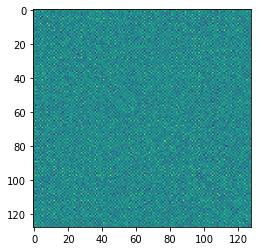

   0.330561  
  -0.263136  
  0.0498553  
  -0.106773  
   0.119402  
  -0.307518  
   0.172838  
  -0.527264  
   0.182255  
  -0.304912  
   0.621186  
  -0.490882  
   0.157286  
  -0.252649  
   0.161692  
  -0.185182  
   0.289602  
  -0.397649  
   0.490716  
  -0.275069  
    0.20757  
  -0.257536  
   -0.17573  
  -0.204364  
  0.0429942  
  -0.196929  
   0.162695  
  -0.288729  
   0.148272  
  -0.214981  
   0.299101  
  -0.443068  
   0.168482  
  -0.110911  
    0.29034  
  -0.286069  
   0.165951  
  -0.268958  
   0.075959  
-0.00887512  
   0.249113  
  -0.287712  
   0.177783  
  -0.318014  
   0.116883  
  -0.411934  
   0.617769  
  -0.184427  
   0.216077  
  -0.105529  
  0.0494244  
  -0.232087  
   0.173194  
  -0.257057  
   0.446631  
 0.00958828  
   0.265868  
  -0.173916  
   0.403726  
 -0.0934689  
   0.164762  
 -0.0704557  
   0.269617  
  0.0337494  
   0.198195  
  -0.306046  
  0.0776887  
 -0.0702732  
   0.192855  
    -0.1848  
   0.476441  
  -0.1

 -0.00608762     0.0039613  -3.74548e-05   0.00414988   -0.00298964    0.00541372   -0.00638207  -0.000124833   -0.00563806    0.00262919   -0.00579274    0.00239778   -0.00437104    0.00446179   -0.00337205    0.00606393   -0.00182245    0.00243411   -0.00372112    0.00728929   0.000424854    0.00545044   -0.00183959  -0.000437691   -0.00312252    0.00572467    0.00275488    0.00578455   -0.00408952   0.000600496    -0.0126113     0.0053704  -0.000558763   7.34866e-05    -0.0029423    0.00114529   -0.00472584    0.00247591   -0.00346632    0.00843116   -0.00846785   0.00067498   -0.00551924    0.00439156   -0.00342315   0.00586137   0.000392431    0.00168649   -0.00555508    0.00204654   -0.00774236     0.0055192   -0.00489471    0.00486525    0.00208056    0.00644227   -0.00533712    0.00223194   -0.00734393    0.00553053   -0.00404351     0.0026365   -0.00675015   -0.00341427    -0.0033614    0.00631005    -0.0152369    0.00833258   -0.00364717    0.00413498    0.00282388    0.00620

 -0.00683264    0.00709413   -0.00616268    0.0172312   -0.00618426    0.00446179  -0.000329871   -0.00481745   -0.00614502    0.00995607   -0.00106294     0.0050273   -0.00381329     0.0114478  -0.000122405    0.00517204   -0.00596603    0.00557141    0.00240462    0.00427708    -0.0068955    0.00526321   -0.00853435    0.00747909   -0.00753531    0.00450161   -0.00337814   -0.00346046   -0.00189839    0.00542484    -0.0123369   -0.00048289   -0.00975472    0.00169275   0.000339536    0.00193916    -0.0105985    0.00533313  -0.000361356     0.0100679   -0.00527651   0.00646406   -0.00811775     0.0106682   -0.00495047   0.00392652   -0.00756832   -0.00194267   -0.00710031    0.00734371   -0.00719726    0.00817895   -0.00728192    0.00907036  -0.000235695    0.00905518   -0.00393822    0.00561352     -0.003449    0.00173204   -0.00563149    0.00768774    -0.0120838    0.00559104   -0.00875558    0.00775499   -0.00311882    0.00448333   -0.00643005    0.00719744   0.000373484    0.00496

  0.00602137   -0.00727269    0.00734298   -0.0081575    0.00790385   0.000424854    0.00913042   -0.00020983    0.00228101    -0.0103452     0.0073622   -0.00911989    0.00306302    -0.0068955    0.00780025     -0.004335     0.0062926   -0.00239459   0.000212366   -0.00161924    0.00907872   -0.00559294    0.00827903   0.000116933    0.00275423    -0.0006568    0.00437193    0.00217392    0.00558899   -0.00392696    0.00475427   -0.00344657     0.0059079   -0.00506103    0.00121988   -0.00516726    0.00844108   -0.00588222    0.00136509   -0.00293676    0.00545513  -0.00816001    0.00883641   -0.00888605    0.00382812  -0.00544484    0.00931066    -0.0129509    0.00631324   -0.00344397    0.00958785   0.000387695    0.00393327   -0.00379902   -0.00233241   -0.00544294    0.00505412   -0.00921541     0.0113469   -0.00640019    0.00224227   -0.00486695     0.0154299   -0.00376085    0.00236486   -0.00795462    0.00706327   -0.00962771    0.00736021   -0.00359772   0.000954956    -0.0135

 -0.00250816    0.00736172    0.00143872  -0.00540283   -0.00325992    0.00578455   -0.00304311    0.00703153    -0.0018567    0.00379205     0.0059055  -0.000193629   0.000962599   -0.00346046   -0.00188985    0.00909603   -0.00111049    0.00244968     -0.010354   -0.00877518    0.00217392    0.00900489    0.00148935    0.00229207   -0.00460524    0.00563275    0.00575449    -0.0229992   -0.00616477   -0.00178433  -0.000231502    -0.0059439     0.0036664     0.0029979    0.00112032     0.0100175   -0.00646903   0.000471298     0.0102995   -0.00444288    -0.0067535  -0.00320533   -0.00422108    0.00462946   -0.00203314  -0.00158639    0.00597303    0.00312113  -0.000935984    0.00611501    -0.0175205      0.002573   -0.00401476   -0.00337993    0.00292322  -0.000948119     -0.010246    0.00191453    0.00107577    0.00986995    0.00158151    0.00360292    0.00028273   -0.00388227   -0.00957783     0.0060039    0.00163696   -0.00022146    0.00312666    0.00636096    -0.0158384     0.0172

 -0.00242072  -0.000917904     0.0180573   -0.0118999    0.00742215    -0.0029423   -0.00594533    -0.0139997    0.00820539    0.00499106    0.00360255    0.00692801      0.003216   0.000339536   -0.00158056   -0.00296104    0.00232444   -0.00463792    0.00248328   -0.00523982    0.00121988   0.000981923   -0.00582385    0.00957912    0.00106149    0.00216175     0.0157873    0.00112032   5.81503e-05   -0.00181076     0.0103834   -0.00572552    0.00239908    -0.0013092      -0.01396   -0.00117846    0.00651588   -0.00236378   -0.00675179    -0.0101526    0.00675552  -0.00793156     0.0120872    0.00123393   -0.00273871  -0.00912747     -0.015455   0.000491872    0.00128367    -0.0156422    0.00330595   -0.00682322   -0.00165551   -0.00536049      0.016588     -0.016522    0.00410102   6.51442e-05   0.000234154   -0.00737701    0.00667589   -0.00790492     0.0183545   -0.00153598    0.00191353    -0.0033733  -0.000775146      -0.02078   0.000908455  -3.59526e-05    0.00538312    -0.0101

  0.00417588   -0.00552057  -0.000893585   -0.0144019     0.0126335   -0.00551924     0.0144176     0.0155875     0.0100986   2.73103e-05    -0.0106025    -0.0014107    0.00678696   -0.00811775     0.0031181    0.00231246   0.000535662    -0.0102254    -0.0111173     -0.016248    0.00883641   -0.00705164     0.0157188    0.00775966    0.00686563   -0.00809334    0.00481567   -0.00422108     0.0072275    -0.0062956    0.00887797    0.00334923    0.00704818    0.00198926     0.0120872   -0.00192815    0.00768806   -0.00626559     0.0077463   -0.00491586    0.00955875  -0.00743201    0.00628986   0.000564874     0.0043347  -0.00243949    0.00535534     0.0022321    0.00735624   -0.00510639    0.00274349    -0.0196841    0.00258003   -0.00157086    0.00196978      -0.01636    0.00973968    -0.0109509     0.0107857   -0.00978425     0.0022283   -0.00871689   7.85778e-05   -0.00705825    0.00832032   -0.00606441     0.0138589   -0.00384671    0.00213327   -0.00759599    0.00189486  -0.000680

  0.00613204   -0.00770096     0.0123585  -0.00316238    0.00781383   -0.00774236    0.00061808    -0.0162584     0.0103753    -0.0130375    0.00927628    -0.0114419     0.0103888   -0.00719726    0.00664256    -0.0144385    0.00777652    -0.0115496   -0.00180741   -0.00761658    0.00958785   -0.00686767     0.0203641     0.0100777      0.004414  -0.000719402   -0.00346608    -0.0175205    0.00522516    0.00107238    0.00673598    -0.0118435    0.00698436   -0.00275339    0.00330595    -0.0120589    0.00756499   -0.00516424    0.00398086     0.0103606    0.00947912  -0.00709465    0.00274349   -0.00696355   0.000253742  -0.00443154     0.0102571   -0.00125111     0.0128281   -0.00572354    0.00625164   -0.00143065     0.0070825    -0.0064344    0.00276792    -0.0102177    0.00982302   -0.00585978     0.0255748    -0.0125021    0.00111292   -0.00571966   0.000691193   -0.00800113    0.00889713   -0.00801038     0.0181285   0.000640432     0.0111369   -0.00640282    -0.0107844   -0.00845

   0.0127227   -0.00984515      0.021194  -0.00820544    0.00893852   -0.00734393     0.0133401    -0.0101464     0.0054918   -0.00755604     0.0173653   -0.00344059     0.0093705     -0.003449     0.0063007    0.00196359     0.0162208    -0.0100665     0.0122473    -0.0203984     0.0113469    -0.0125958    0.00879269     -0.015127     0.0116165    -0.0141789    0.00685013    0.00107577    0.00958557   -0.00358305     -0.010661    -0.0165838     0.0124594   -0.00864218   0.000234154    -0.0169472      0.012781   -0.00629119   -0.00371284    -0.0176517     0.0156177  -0.00578798     0.0107857    -0.0138181   -0.00131983   -0.0165255   0.000920562      0.006272     0.0117657   -0.00314556     0.0255748    -0.0066256    0.00951135   -0.00949813     0.0128779    -0.0176334     0.0103411    -0.0120098     0.0019628    -0.0113426    0.00568192    -0.0107166     0.0186879   -0.00259326     0.0122485   -0.00985122     0.0181412   -0.00365573    0.00649863   -0.00883224    0.00971805   -0.00798

 -0.00422873    0.00607602    -0.0111626   0.00841669   -0.00839747    0.00631005    -0.0102745    0.00716251   -0.00393615    0.00591622   -0.00328263    0.00674462   -0.00572945    0.00775499   -0.00304603     0.0055224    -0.0055703    0.00385189   -0.00289624   -0.00117208   -0.00795462    0.00822622    -0.0148225     0.0100601   -0.00585198    0.00750196   -0.00684828     0.0060039   -0.00599915    0.00385771    -0.0154253   0.000205286   -0.00392822    0.00710822    -0.0033733    0.00781755   -0.00983163    0.00460273   -0.00603758    0.00591096   -0.00998323   0.00591999   -0.00606441    0.00669595   -0.00517955   0.00894028   -0.00382526     0.0145469   -0.00828151    0.00585441   -0.00801038     0.0032475   -0.00558279    0.00380045    0.00147821    0.00547946   -0.00643834    0.00442817   -0.00985122  -1.12014e-05   -0.00672513    0.00873786    -0.0156581    0.00122233   -0.00686254    0.00348891    -0.0127676    0.00632997   -0.00657685    0.00250702   -0.00141359    0.00306

  0.00535676  -0.000287485    0.00850564   -0.0120319    0.00619938   -0.00775193     0.0070331   -0.00958365    0.00364019   -0.00471591    0.00636185    0.00116118    0.00553894    -0.0067102    0.00506511    -0.0038816    0.00471178   -0.00301115    0.00235197   -0.00445693    0.00386483   -0.00440855    0.00413312   -0.00255522    0.00215362   -0.00340671    0.00940792   0.000904924    0.00373294    -0.0030285    0.00429887    0.00033431    0.00380087   -0.00539198    0.00491639   -0.00206559     0.0076609   -0.00228354   -0.00146242   -0.00510301    0.00435563  -0.00364005    0.00200497   -0.00474841    0.00163658   -0.0054306    0.00709925   -0.00756926     0.0049057   -0.00657771     0.0102422   -0.00778765    0.00765989   -0.00414774    0.00554696    -0.0154471    0.00312942   -0.00703454     0.0111543   -0.00719292    0.00418774   -0.00747208    0.00641079   -0.00260785    0.00620088   -0.00796322     0.0060753   -0.00604421    0.00454472   -0.00246125    0.00435915    -0.0129

 -0.00327227    0.00457999   -0.00245792   0.00789509    -0.0163087    -0.0011613    -0.0010828    0.00835632   -0.00592316   1.43213e-05   -0.00784014   -0.00366029   -0.00544246   -0.00349568    -0.0151344      0.020658   -0.00673516    0.00578018    -0.0014784   0.000584691   -0.00760857    0.00983233   -0.00176495   7.59306e-05   -0.00940186   0.000742502    -0.0103206  -0.000107403   -0.00119463    0.00506554   -0.00151829   0.000653898   -0.00151434    0.00757042    -0.0122988     0.0203242   -0.00369306    0.00667382    -0.0223095   -0.00283717   -0.00507537    0.0113201    -0.0161185   -0.00468734   -0.00318665   0.00616791   -0.00948475    0.00209536   -0.00622953    0.00487798    0.00921544    0.00200604    0.00486113  -0.000998942   -0.00464291     0.0126697     -0.001524    0.00687017   -0.00900761    0.00716118   -0.00535542    0.00740402     -0.014266   -0.00806557   -0.00368935    0.00244754    0.00948948    0.00826331   -0.00233736  -0.000349838    0.00361652   -0.00568

   0.0127127    -0.0048832      0.012903   0.00507446    0.00621375   -0.00998984     0.0079424    -0.0131785    0.00990755   -0.00807502     0.0205685   -0.00159971     0.0180392   -0.00444046      0.012277   -0.00403529    0.00189582   -0.00350245   -0.00895285     -0.011441   -0.00191332    -0.0140046   -0.00262381    -0.0175433    0.00345575    -0.0157485    0.00182911   -0.00396662     0.0122953   -0.00542872    0.00515645    -0.0188537    0.00869038   -0.00569273    0.00218952     0.0042521    0.00952787   -0.00269711   -0.00195533   -0.00677665     0.0126916  -0.00655985     0.0038713   -0.00295441   -0.00358811  -0.00983924    0.00960769    0.00266863    0.00373315    -0.0103929    0.00170893   -0.00404645    0.00544408   -0.00352759      0.010545   -0.00941112    0.00876934   -0.00122618     0.0289032    -0.0144359     0.0123265   -0.00862094     0.0140077    0.00627648     0.0076841   -0.00506823     0.0230209   -0.00946496    0.00414643    -0.0078173    0.00691454    0.00544

 -0.00352437    0.00834321   -0.00756387    0.0116847    -0.0047186    0.00383432   -0.00600125    0.00357054   -0.00563928    0.00808174   -0.00816491  -0.000479737   -0.00329595    0.00419121   -0.00212331    0.00694053   -0.00501758    0.00551146   -0.00392831    0.00428522   -0.00252786    0.00294584   -0.00237064    0.00161356    -0.0055215    0.00312333   -0.00714319   -0.00327021   -0.00230765    0.00267937   -0.00940416    0.00881558   -0.00779569    0.00600176   -0.00305072    0.00518218   -0.00549463    0.00337063   -0.00847488    0.00408698    -0.0102563   0.00732546   -0.00220423    0.00820307   -0.00651494   0.00511784    -0.0149453  -0.000832095   -0.00901738    0.00332732   -0.00634464   -0.00149543   -0.00473862    0.00422454   -0.00430587    0.00765622   -0.00654099    0.00482319   -0.00294347    0.00500178   -0.00605418    0.00677799   -0.00914932    0.00232519   -0.00446941    0.00453027   -0.00373804   0.000203923   -0.00299388    0.00494623   -0.00209163     0.0082

  0.00585321   -0.00918073     0.0124041  -0.00782421    0.00870171    -0.0068073    0.00817928    -0.0139054    0.00470714   -0.00765277    0.00950166   -0.00506782    0.00774683   -0.00871745   0.000401161   -0.00535057    0.00893916    -0.0087089    0.00354073     -0.010041    0.00857454   -0.00674197     0.0107612   -0.00624581    0.00426428   -0.00626884    0.00628092     -0.001592    0.00861864   -0.00682287     0.0153471   -0.00842038    0.00815773   -0.00796082    0.00145487   -0.00489495    0.00631607   -0.00377809    0.00567719    -0.0099748    0.00971955  -0.00863635    0.00673451   -0.00489772    0.00261613  -0.00698824     0.0015551    -0.0034356     0.0099142    -0.0063654     0.0126711   -0.00834164    0.00709663   -0.00788496  -0.000273215   -0.00683756    0.00718995   -0.00611304     0.0150651   -0.00693371    0.00551414   -0.00910367     0.0100217  -0.000353504    0.00685209   -0.00771981    0.00934803   -0.00809487    0.00924126   -0.00322708   -0.00353942    -0.0110

 -0.00470819    0.00445401    -0.0251438  -0.00982172    0.00254076    0.00778255    -0.0206891   0.000933501   -0.00527266    -0.0033904   -0.00692884   -0.00356794    0.00800186   -0.00184128    0.00268113    0.00573655  -0.000283868    0.00401913    0.00389963    0.00800299     0.0042826    0.00440402   -0.00589926  -0.000742233   -0.00104381    0.00579952   -0.00410092   -0.00673124   -0.00476416    0.00547601    0.00251909    0.00234572   -0.00121296    0.00645414    -0.0125628    -0.0127014    0.00317653   -0.00117018   -0.00708338     0.0122947  -0.000940244   0.00603309   -0.00335091    0.00227501    0.00281972  -0.00128257    0.00752391    0.00950265   -0.00556129     0.0117193    0.00586291    0.00231915    0.00349471    0.00256536    -0.0104291    0.00524017   -0.00498196  -0.000893844   -0.00988151     0.0117771    0.00225813    0.00821241   -0.00550642   0.000488389   -0.00425433    0.00298963   -0.00244867   -0.00408325    0.00120323    0.00180627    0.00912489  -0.000825

  0.00594148   -0.00353712    0.00337142   0.00157034    0.00762405   -0.00957836    0.00190745    -0.0023496      0.011346   -0.00679177    0.00411561     -0.015638      0.010697   -0.00518036     0.0104581   -0.00804884    0.00920293    -0.0110421     0.0102676   -0.00955587  -0.000179718    -0.0131329    0.00207884   -0.00202575    0.00297032    -0.0128882    0.00293883     -0.020156    0.00596787   -0.00243676    0.00866927    -0.0117659    0.00657263   -0.00904322    0.00675642    -0.0296286    0.00931014    0.00057668      0.011811    -0.0145815     0.0163768  -0.00367604    0.00468611   -0.00142463    0.00415556  -0.00995008    0.00575525    -0.0148009     0.0114587    -0.0115431     0.0174842   -0.00482883    0.00313592    -0.0103223   -0.00038656    -0.0137623    0.00709598    -0.0059854     0.0263603     -0.010073    0.00726876   -0.00696542    0.00746952     0.0141929     0.0133685   -0.00691733     0.0105854    -0.0173269    0.00777947    -0.0151605     0.0018229    -0.0144

 -0.00551722    0.00251094   -0.00601044   0.00765885   -0.00910093   6.10378e-05   -0.00634615    0.00554233   -0.00258769    0.00409276   -0.00538192    0.00503019   -0.00451845    0.00548197   -0.00599337    0.00509374   -0.00831102    0.00414844    0.00102268    0.00227124   -0.00599178    0.00321748   -0.00594493    0.00285715   -0.00222076    0.00845897   -0.00774731   -0.00669067   -0.00559552    0.00643908    -0.0038912    0.00070327   -0.00424993     0.0071634   -0.00500217  -0.000525414   -0.00508171    0.00327979    -0.0106114    0.00870633    -0.0063275   0.00630296   -0.00466643    0.00856068   -0.00625196   0.00516705   -0.00512924    0.00990596   -0.00971566    0.00774569   -0.00188894    0.00628288   -0.00376483    0.00923999   -0.00767326      0.011866   -0.00508098     0.0112854   -0.00692497     0.0107275   -0.00712256    0.00935882     -0.013446    0.00176863    -0.0101475    0.00837779   -0.00722941    0.00691366   -0.00772214    0.00699021   -0.00135242  -0.000449

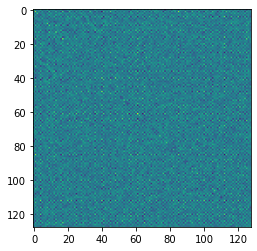

   0.240064  
   -0.33637  
    1.18145  
  -0.264501  
    0.24299  
 -0.0600559  
  -0.172034  
  -0.303268  
   0.250911  
  -0.378814  
   0.442841  
  -0.107237  
   0.127951  
  -0.415723  
   0.195296  
  -0.116575  
   0.403959  
  -0.293179  
   0.657475  
   -0.33577  
   0.269845  
 -0.0978195  
   0.374422  
  -0.334817  
   0.308617  
   -0.33487  
   0.514074  
    0.14215  
   0.286822  
  -0.227136  
   0.292571  
  -0.272239  
   0.250948  
   -0.20888  
   0.556502  
  -0.543667  
   0.286415  
  -0.284835  
   0.205975  
  -0.373927  
   0.231097  
  -0.348657  
   0.228879  
  -0.265362  
   0.175517  
  -0.408531  
   0.124924  
    0.20045  
   0.452955  
  -0.288159  
   0.264118  
  -0.201498  
   0.297129  
  -0.301909  
   0.168958  
  -0.344266  
  0.0567184  
  0.0196693  
   0.516266  
  -0.378781  
   0.261535  
  -0.515393  
   0.453482  
   -0.10482  
   0.337063  
  -0.341669  
   0.338953  
  -0.139303  
   0.301318  
  -0.264727  
  0.0542925  
  -0.5

  0.00540916    -0.0019608    0.00898937   -0.00908025    0.00586902   -0.00513587    -0.0259369    -0.0191691    0.00406532   -0.00747386    -0.0129525    -0.0113202    0.00536989   -0.00142902    -0.0138731    0.00379443    0.00442584  -0.000386179    -0.0108106     0.0031374   -0.00113165  -0.000485668    0.00982001     -0.013249    0.00740855   -0.00877621    0.00586018    -0.0193292  -0.000925724    0.00176083    0.00448914   -0.00954047    0.00377963   -0.00634277    0.00106612     0.0135489    0.00593816   -0.00222784   -0.00457132   -0.00452585    0.00194981  -0.00591065   0.000719512   -0.00682602    0.00599364  -0.00763298    -0.0010639    0.00264819   -0.00399662   -0.00704146    0.00920823     0.0136692   0.00528958   -0.00403307     0.0100983   -0.00934923     0.0014389   -0.00732888   -0.00521823  -0.000779709  -0.00013153   -0.00209518    0.00968857   -0.00620656    0.00492249   -0.00539023    0.00883597    -0.0109236    0.00118666   -0.00225443   -0.00652923   0.0008584

  0.00565584   -0.00523662   0.000385165   0.000646064    0.00187617   -0.00470704    0.00536989   -0.00719669     0.0070662   -0.00493468    0.00764165   -0.00857933     0.0045596   -0.00560305   -0.00175685   -0.00254677    0.00614605   -0.00482841    0.00206243   -0.00215337     0.0078124   -0.00619933    0.00268881   -0.00556129    0.00948093   -0.00657262    0.00195416   -0.00263865    0.00421601   -0.00917623    0.00537816   -0.00672585    0.00681947    -0.0071766   -0.00126088   -0.00811464    0.00631474   -0.00586255   0.000243726   -0.00489278    0.00481617  -0.00423548     0.0120651   -0.00902024    0.00448196  -0.00432062   -0.00157872   -0.00884387    0.00814678   -0.00760889     0.0101956   -0.00135686   0.00506551   -0.00541693    0.00308396   -0.00822198    0.00365706   -0.00526009    0.00252239   -0.00379243   0.00585688  -0.000746304   -0.00178191   -0.00662006    0.00493112    -0.0059786     0.0101439   -0.00727782    0.00543598   -0.00438575    0.00653138   -0.006689

  0.00915775   -0.00382697    0.00416273   -0.00245476    0.00638042    -0.0081333    0.00442584   -0.00338673    0.00366842   -0.00999532    0.00629285   -0.00695538    0.00614605   -0.00787872    0.00109143     -0.007076    0.00754364   -0.00734844    0.00635946   -0.00630716    0.00754868    -0.0108604    0.00914776   -0.00888989     0.0105731   -0.00717009    0.00203588   7.90604e-05    0.00755714   -0.00720574     0.0070636    -0.0155697    0.00900711   -0.00608511     0.0112957  -0.000622784    0.00623604    -0.0059782    0.00876302    -0.0127026    0.00678005  -0.00832308    0.00836941   -0.00584367     0.0044111  -0.00446659    0.00109439   -0.00842161     0.0053671   -0.00721455    0.00181709   0.000227401   0.00452496   -0.00553326    0.00651231    -0.0117042      0.004622   -0.00526714    0.00161282   -0.00817905   0.00815999   -0.00673128     0.0087619     -0.014199    0.00568861   -0.00777835     0.0129111    -0.0135685    0.00661398   -0.00554429    0.00955763     -0.0100

 -0.00576567    0.00975832    0.00178926    0.00813176    -0.0059822    0.00489112     -0.013249    0.00239038   -0.00492819    0.00272738    -0.0110777     0.0117269   -0.00556129     0.0094341  -0.000641611     0.0127228   -0.00888989    0.00485445    -0.0131393    0.00990556   0.000484977     0.0105598     -0.003644    -0.0257059    -0.0137168    0.00998042    -0.0136595    -0.0040813   -0.00583312    0.00644737   -0.00410156    0.00695434   -0.00436282   -0.00092971    -0.0139658    0.00604897   -0.00661364    0.00517386    -0.0059365    0.00456362    -0.0130041   0.00948174    -0.0112816    0.00519736   -0.00515505    0.0117542   -0.00861021   -0.00405712     -0.010293    0.00504229    0.00109035    0.00856929  -0.00808788    0.00888717    -0.0110437     0.0106566    0.00358655    0.00386354    -0.0026778     0.0061664   -0.0124801    0.00144586   0.000268219     0.0188919   -0.00699555    0.00933964   -0.00688414    0.00395362    -0.0114801    0.00527046   -0.00621198    0.008886

   0.0057554   -0.00420656    0.00884697   -0.00214242    0.00301442   -0.00711859    0.00377963   -0.00784801    0.00328468   -0.00641293    0.00724898   -0.00350386    0.00681947   -0.00866816    0.00262365  -0.000153855    0.00900711   -0.00782554    0.00374416   -0.00488382    0.00810457   -0.00827176     0.0116401   -0.00436282    0.00864028   -0.00891442    0.00854379   -0.00509731    0.00356857   -0.00604361    0.00817398   -0.00781425    0.00480735   -0.00906619     0.0091967   -0.00345765    0.00728991   -0.00645342    0.00163597   -0.00325613    0.00784149  -0.00789009     0.0135507   -0.00305931    0.00481093  -0.00998844    0.00427013   0.000860216    0.00796794   -0.00592859    0.00380518    -0.0104846   0.00659405    -0.0095553     0.0072427    -0.0105445    0.00564666   -0.00340109  -0.000302534   -0.00501292   0.00673349   -0.00786368    0.00456375    -0.0040216    0.00465516   -0.00590562     0.0129289    -0.0101344    0.00490652   -0.00546706    0.00482319   -0.006616

  0.00717086   -0.00777531    0.00100251   -0.00773979    0.00629144   -0.00557959    0.00194981    -0.0132391    0.00726423   -0.00628264     0.0155178   -0.00312663    0.00481617   -0.00534646     0.0129704   -0.00534614    0.00678005   -0.00394552     0.0101752   -0.00164191    0.00764981   -0.00803366  -0.000249749    -0.0130041    0.00802502   -0.00247754   0.000243938   -0.00451239    0.00444317    -0.0047709    0.00757272   0.000289247    0.00784149   -0.00218717    0.00693315   -0.00511676    0.00641777   -0.00365801    0.00734283   0.000755699     0.0102277  -0.00603764      0.010979    0.00145856    0.00615061  -0.00553954    0.00272364   -0.00557896    0.00438892   -0.00517982    0.00397109   -0.00428648   0.00556868   -0.00663083    0.00543263   -0.00611226     0.0055147   -0.00439748    0.00903862    0.00470033    0.0055318   -0.00306897    0.00864875    -0.0112119    0.00301537   -0.00152447     0.0168871    -0.0100805     0.0089768   -0.00732714    0.00998316   -0.004491

  0.00682734    -0.0046622  -0.000118866   -0.00751942    0.00866595    -0.0093918   -0.00399662   -0.00331735    0.00795941   -0.00641803     0.0114164   -0.00398271    0.00814678   -0.00718056     0.0093724   -0.00855639     0.0053671   -0.00816283    0.00366685   -0.00936465    0.00709377   -0.00984542    0.00185063     -0.010293     0.0120987   -0.00773269    -0.0010899   -0.00325944     0.0101296   -0.00880711    0.00897251   -0.00324791    0.00796794   -0.00428123     0.0101889   -0.00871957    0.00718402   -0.00652916    0.00835284   -0.00608351    0.00438892  -0.00876695    0.00918156   -0.00197504    0.00652783  -0.00658218    0.00628024      -0.01721    0.00794695    -0.0068541     0.0095511    -0.0103568   0.00766819   -0.00685696    0.00529485    -0.0102467    0.00738885   -0.00542847     0.0160502   -0.00412018   0.00672545   -0.00514178     0.0070995   -0.00475988    0.00805674   -0.00602067     0.0120091   -0.00116748    0.00895935   -0.00586194     0.0102671    -0.01246

   -0.013557    0.00665925    -0.0125487    0.00703852  -0.000537428     0.0110949   -0.00934923    0.00383575   -0.00840016    0.00942747    -0.0183854    0.00728892   -0.00822198    0.00837275   -0.00641005   -0.00472823    -0.0117042     0.0123403   -0.00715102     0.0066255   -0.00499294   0.000983732   -0.00542685     0.0106566   -0.00530755    0.00977643    -0.0142814   -0.00325104    -0.0127702    0.00830936   -0.00336764   -0.00395526    -0.0105445    0.00579301    -0.0136266    0.00651596   -0.00633219    0.00922299    -0.0246138    -0.0043542   -0.00611226   0.00549946    -0.0139168    0.00965913   -0.00254875    0.0112708      -0.01138   -0.00365721    -0.0102467     0.0120467   -0.00714479    0.00765629  -0.00522409     0.0102871    -0.0218049     0.0240642   -0.00337467    0.00666222    0.00199931  -0.000960472  -0.00796322      0.008349   0.000496494    0.00445643   -0.00705767    0.00224855   -0.00996928    0.00432699   -0.00536501     0.0045217   -0.00784674     0.01734

  0.00832878   -0.00358619     0.0108432    -0.0104967    0.00415391   -0.00701232    0.00492249   -0.00136781    0.00532932   -0.00581884    0.00767864   -0.00112096    0.00493112   -0.00478263    0.00342212   -0.00362506    0.00568861   -0.00718241    0.00562066   -0.00145832    0.00422196   -0.00533388    0.00207969   -0.00699555    0.00469797   -0.00336213   5.57594e-05    0.00520271    0.00553714   -0.00689286   0.000376594    -0.0080631    0.00465516   -0.00286558    0.00572884  -0.000744769    0.00640305   -0.00573824    0.00577705  -0.000244164    0.00301537  -0.00488922    0.00365962   -0.00253225   0.000715596  -0.00347719  -0.000643757   -0.00655643    0.00805674   -0.00597445    0.00264837    2.2908e-05   0.00608756   -0.00475595     0.0045702   -0.00705767    0.00457374    -0.0066736    0.00775065   -0.00992362   0.00623228   -0.00290555    0.00318315   -0.00339983    0.00554197   -0.00516507    0.00992277   -0.00565484    0.00411964   -0.00334224    0.00552032   -0.003352

  -0.0113414    0.00454375    0.00314011   -0.00316028   -0.00790426    0.00675081   0.000858447   -0.00281808    -0.0034255    0.00719845    -0.0112776    0.00717268   -0.00668969    0.00432541    0.00258682     0.0102089     -0.010047     0.0105449     0.0114444    0.00786607   -0.00358329     0.0107212    0.00533782    0.00888638   -0.00658016    0.00909803   -0.00554163    0.00408485   -0.00328049    0.00830568    0.00420746    0.00718926   -0.00661679     0.0110066    -0.0145608    0.00141331    -0.0065752    0.00926034     0.0002946    0.00597448   -0.00449105    0.0115833   -0.00640897     0.0135248    0.00061247    0.0061816     0.0141688       0.01491    -0.0124696     0.0163723  -0.000403489    0.00440975  -0.00541848     0.0045094    -0.0164397     0.0173496   -0.00736047    0.00389392    -0.0074234    -0.0175638  -0.00691848     0.0059662    -0.0165029     0.0199262   -0.00335281     0.0063226    -0.0257481  -8.78477e-07   -0.00916119    0.00427008   -0.00730237     0.02009

  -0.0126996   -0.00306121    -0.0126634    0.00168697  -0.000356837   0.000684339    0.00910303    -0.0124931   -0.00475799    0.00902824     -0.011451     0.0122228   -0.00363318    0.00850804     -0.012422   -0.00257032   -0.00805371     0.0117368    -0.0193693     0.0155478    -0.0092284    0.00993022   -0.00609952    0.00717189     -0.011441     0.0132069     0.0171899    0.00684426   -0.00398498      0.011563    -0.0115436    0.00431252   -0.00431731    0.00788737    -0.0146789     0.0181546   -0.00196155     0.0065024   -0.00910838   -0.00204176   -0.00794476   0.00475333   -0.00196593     0.0101855   -0.00321743  0.000408852   -0.00502815     0.0143359   -0.00616562    0.00901189    -0.0133377    0.00501992  -0.00266877    0.00188791    -0.0141946   -0.00581771   -0.00480447    0.00398388    -0.0225843   -0.00145631  -0.00871538    0.00239165     -0.023451    0.00513961   -0.00233653    0.00373831    -0.0385151     0.0100078   -0.00594231    0.00864057    -0.0122536    0.006670

 -0.00565021   0.000182413   -0.00816751    0.00359593   -0.00268191   -0.00129494    -0.0182037     0.0253449   -0.00566533    0.00477512   0.000375349     0.0179578   -0.00434096    0.00611719   -0.00495697     -0.012262   -0.00825454    0.00736459   -0.00292991    -0.0112807    -0.0066974    0.00799762   -0.00915219  -0.000579859   -0.00448861     0.0104306   -0.00767477     0.0130776   -0.00115307    0.00341587    -0.0153659    0.00357487   -0.00500377     0.0108099     -0.025337     0.0024728   -0.00983247     0.0100735    0.00898128    0.00228812   -0.00630464   0.00869727    0.00940377    0.00207733  -0.000214618  0.000224288     -0.010779     -0.010024   -0.00177474     0.0124249   -0.00783522   -0.00467031  -0.00557486    0.00792669    -0.0169748     0.0141016   -0.00501721    0.00579952   -0.00509222    0.00489296  -0.00268334    0.00633971    -0.0109837     0.0161673   -0.00441364    0.00615031    -0.0134918     0.0138354    0.00137728    0.00976596     0.0100211     0.01174

  0.00692086   -0.00440666    0.00547015   -0.00541536    0.00583624   -0.00538741    0.00463685   -0.00666084    0.00492258   -0.00793163    0.00734605   -0.00545591    0.00660778   -0.00627167   -0.00381707   0.000492638     0.0086328    -0.0104656    0.00665181   -0.00737932    0.00723277   -0.00784674   0.000192025   -0.00932757    0.00997347   -0.00723574  -0.000246917    -0.0065458    0.00429501   -0.00578215    0.00386641    -0.0144614    0.00840281   -0.00724269    0.00847021    -0.0031556    0.00490923   -0.00510054     0.0021125   -0.00350272     0.0048508  -0.00914596     0.0112778   -0.00376732    0.00866255  -0.00488406    -0.0025048   -0.00440702    0.00892997   -0.00686035    0.00424436   -0.00195635   0.00942886   -0.00695116    0.00247973   0.000160917    0.00416416   -0.00458013    0.00927584   -0.00173524   0.00461115   -0.00910477    0.00577294    -0.0146419    0.00254021   -0.00974456      0.010796   -0.00199522    0.00870367   -0.00604315     0.0157808    -0.01258

 -0.00578184    0.00505707   -0.00286372    0.00541677   -0.00470341    0.00789761   -0.00461934   0.000919427   -0.00815765       0.00684   -0.00843186    0.00985069   -0.00797336    0.00827517   -0.00289719     0.0122544   -0.00791235    0.00679129   -0.00588758   -0.00437509   -0.00802981    0.00564818   -0.00164013    0.00513096   -0.00691104    0.00716215    -0.0059759    0.00334398   -0.00341797    0.00965743   -0.00108444    0.00332409   -0.00609021    0.00332448   -0.00197032   -0.00165682    -0.0051219     0.0069291   -0.00187134    0.00259497   -0.00562174   0.00514469   -0.00960841   -0.00156509   -0.00429107   0.00455276   -0.00910823    0.00893752   -0.00864399    0.00521034    -0.0114984    0.00367272  -0.00501986    0.00737383   -0.00330058     0.0145601   -0.00158011    0.00434536   -0.00424623    0.00595835  -0.00363888    0.00724926    -0.0074772    0.00326321   -0.00518069     0.0057965   -0.00412945     0.0061396   -0.00408198     0.0037995   -0.00680019    0.002153

 -0.00857308    0.00423233    -0.0108324    0.00541052   -0.00887251    0.00827667   -0.00325776    0.00929793   -0.00589687    0.00683301    -0.0108651    0.00804051   -0.00453128      0.008679    -0.0045046    0.00655746   -0.00588008    0.00612634  -0.000335532     0.0104657   -0.00318544    0.00884161   -0.00288261     0.0106029   -0.00687635    0.00754858    -0.0100986    0.00663561    -0.0078426    0.00860712   0.000292717    0.00656103   -0.00772693    0.00680156   -0.00629863   0.000834767   -0.00540013    0.00790291   -0.00194578    0.00165994    -0.0104852    0.0101021    -0.0150422    0.00904343   -0.00472302   0.00696828   -0.00366871    0.00440395   -0.00751187    0.00782917   -0.00926264    0.00768625  -0.00793769     0.0065444    -0.0110264    0.00518169   -0.00351813    0.00831398   -0.00353307    0.00721882   -0.0106642    0.00697267   -0.00391591  -0.000276302   -0.00579877    0.00903676   -0.00975334     0.0155578   -0.00717763     0.0101965   -0.00601877     0.01109

  0.00306302   -0.00951504      0.016563    0.00120647    0.00143671   -0.00868465    0.00490304    -0.0168348    0.00242376    -0.0103534    0.00523235   -0.00985915    0.00412271   -0.00406053   -0.00500936     -0.025538    0.00487603    -0.0115561   0.000519812    0.00754355    0.00582776   -0.00838955    0.00991665    -0.0049408     0.0131764   -0.00586336   -0.00755415      -0.02003     0.0102075   -0.00941139    -0.0123898     -0.027218    0.00129396   -0.00378828    -0.0147431   -0.00923127    0.00813206   -0.00756478     0.0156325   0.000753431    0.00437437  -0.00460986     0.0187713   -0.00195207    0.00274958  -0.00856773    0.00466993    -0.0187738     0.0079653    -0.0109695   -0.00141534   0.000255784   0.00760961   -0.00704169    0.00243103    -0.0014885   -0.00147527    -0.0128172    0.00375501   -0.00876422   0.00985295   -0.00700119     0.0157204    -0.0242179    0.00792096   -0.00749126   -0.00106591    -0.0151839     0.0112618   -0.00476655     0.0155143   -0.009735

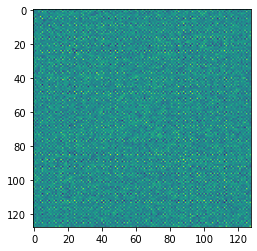

   0.0260516  
   -0.283764  
   0.0893556  
    0.218184  
   0.0887119  
   -0.117274  
    0.332448  
  -0.0496984  
   0.0719795  
   -0.226732  
    0.519663  
    0.144894  
  -0.0245228  
-0.000122015  
    0.335052  
   -0.354492  
    0.100502  
   -0.269417  
   -0.264195  
  -0.0807925  
    0.213929  
   -0.275922  
    0.399887  
  -0.0960916  
    0.180111  
    0.018242  
    0.212286  
   -0.219356  
    0.391442  
   -0.253578  
  -0.0555549  
   -0.438832  
    0.186952  
  -0.0207905  
    0.435355  
 0.000738646  
    0.113262  
    -0.48223  
    0.132441  
   -0.198557  
    0.146236  
   -0.209628  
    0.525906  
   -0.122505  
    0.114157  
   -0.333053  
    0.188343  
    0.235346  
       0.117  
   -0.343287  
    0.134671  
   0.0511553  
      0.2009  
    -0.25925  
     0.10973  
   -0.347935  
   0.0512631  
   -0.294299  
   0.0913948  
   -0.291012  
  -0.0198613  
   -0.159687  
    0.321786  
   -0.331758  
    0.391473  
   -0.397281  
    0.6180

 0.00569667   -0.00598177     0.0091741   -0.00823549    0.00808637   -0.00582792     0.0126279   -0.00921854     0.0044165   -0.00614717  -0.000516708   -0.00513918   0.00398467   -0.00718729    0.00482139    -0.0141914    0.00466879   -0.00639323    0.00123436   -0.00191185   0.00651047   -0.00330093    0.00263472   -0.00264804    0.00725914   -0.00696559    0.00415071    -0.0048412    0.00729646   -0.00773079    0.00843762    -0.0162902    0.00644673   -0.00832641    0.00479477    0.00245145    0.00620863   -0.00660747     0.0028583   -0.00315875    0.00810426   -0.00769282    0.00789195   -0.00384405     0.0078804   -0.00708352   0.000620287   -0.00623017    0.0104885   -0.00737713     0.0131469   -0.0082006    0.00631311   -0.00760925     0.0134973   -0.00396817    0.00453815   -0.00832475     0.0103893   -0.00875807    0.00623892   -0.00640249    0.00659288   -0.00942026    0.00494191    -0.0115812    0.00693771   -0.00269519    0.00738586   -0.00822934   -0.00605013   -0.0058123

-0.00251129     0.0066615   -0.00429382    0.00695846   -0.00614717    0.00462998   -0.00771232    0.00476753   -0.00300172    0.00553238   -0.00327704    0.00127334  -0.00369689    0.00597846   -0.00246975    0.00915428   -0.00537867    0.00459227   -0.00420865     0.0045036  -0.00568493    0.00260144   -0.00394538     0.0168185   -0.00254833    0.00304511  -0.000438485    0.00434736   -0.00692609    0.00397008   -0.00732863      0.007228   -0.00630881    0.00973826  -0.000191024    0.00419754   -0.00435472    0.00331216   -0.00531137    0.00871381    -0.0012891   0.000291247   -0.00386188   0.000860178   -0.00629733     0.0053714   -0.00385682     0.0067353  -0.00607967    0.00714011   -0.00555842   0.00876615   -0.00889359    0.00645935   -0.00858535     0.0101321   -0.00304878    0.00389187    0.00158866    0.00702065   -0.00456923    0.00647834   -0.00896004   8.09064e-05   -0.00707651    0.00865686   -0.00728327   -0.00339936   -0.00396487    0.00581921    -0.0112994    0.0062340

 0.00265083   -0.00668114  -0.000205279     -0.005112    0.00466879   -0.00329971      0.010243    -0.0107165    0.00498816   -0.00537867    0.00202534   -0.00524721    0.0071716   -0.00529848     0.0105498    -0.0132007    0.00588685   -0.00458253    0.00704257   -0.00620466   0.00979433   -0.00610628   0.000371087   -0.00911627    0.00823351   -0.00391656    0.00716357   -0.00590338    0.00188357   -0.00765619     0.0125369     -0.012602    0.00767488   -0.00693052     0.0114757   -0.00145228    0.00433809    -0.0044634    0.00480363   -0.00887651    0.00685872   -0.00459564     0.0105016   -0.00110839    0.00706765   -0.00983077    0.00991079   -0.00231942   0.00525581   -0.00654675   0.000892508  -0.00505204    0.00587591   -0.00118637    0.00235665   -0.00299643    0.00681943   -0.00450008    0.00528359   -0.00373856    0.00537303   -0.00507824    0.00726396   -0.00467942    0.00768744   -0.00580394     0.0085257   0.000311925    0.00344754   -0.00714631    0.00794384   -0.0031001

-0.00643798    0.00921104    -0.0191426     0.0135597   -0.00264804     0.0116895    -0.0137103     0.0160622    -0.0105912     0.0168185   -0.00829007    0.00921872    -0.019536    0.00895992    -0.0152735      0.027924   -0.00911627     0.0111675   -0.00629914     0.0140543  -0.00676008     0.0157461   -0.00105949    -0.0139733    -0.0067743     0.0050985  -0.000596494    0.00551757   -0.00823806     0.0103006   -0.00171113     0.0138972   -0.00729269    0.00346211    -0.0103803     0.0118793   -0.00986532      0.011928   -0.00412153     0.0141932   -0.00602038     0.0048916    -0.0192814     0.0106093    -0.0138903    0.00360926   -0.00476346    0.00334216  -0.00676299    0.00863527    -0.0118548   0.00560673     -0.012078    0.00677149   -0.00856706     0.0130001   -0.00821757    0.00386687    0.00317336    0.00341671   -0.00751014     0.0188134   -0.00593297   -0.00275212    -0.0171459     0.0111578    -0.0232967   0.000773114   -0.00563561     0.0150593   -0.00791975   0.00086132

-0.00330391    0.00632675   -0.00506858    0.00966987   -0.00773079    0.00474203    -0.0113902    0.00718016   -0.00617331    0.00397008    0.00160687   -0.00123368  -0.00712811    0.00336326   -0.00757869    0.00621409   -0.00765619    0.00635251    0.00150484    0.00960951  -0.00409382     0.0039562   -0.00288589     0.0103006   -0.00757945    0.00514235    -0.0112003    0.00647861   -0.00304076    0.00730501    -0.0191308     0.0170473   -0.00487221    0.00678423   -0.00271338    0.00286346   -0.00104489    0.00521353   -0.00274432   0.000414894   -0.00700454    0.00605059    -0.0113828  -0.000643423   -0.00266522    0.00628009    -0.0129795    0.00593227   -0.0075533    0.00568557   -0.00699201   0.00384579   -0.00697536    0.00773577    -0.0086405   -0.00225636   -0.00364311    0.00713931   -0.00526482    0.00201825   -0.00232325    0.00570857   0.000738079    0.00243093   -0.00926162    0.00836237    -0.0117758    0.00992282   -0.00607159    0.00768094   -0.00786871    0.0088906

  0.0032078   -0.00650458    0.00564507   -0.00564709    0.00620863   -0.00576423    0.00136107   -0.00459618    0.00567527   -0.00435472    0.00341534   -0.00559579   0.00710525   -0.00616955    0.00513309   -0.00348225    0.00433809    -0.0051418   0.000542085   -0.00769012   0.00926254   -0.00207013  -0.000136162   -0.00986532    0.00272042   -0.00380478    0.00408045    0.00745907     0.0024524   -0.00104489    0.00407031   -0.00555532    0.00529653   -0.00454599   -0.00236403    -0.0042155    0.00626947   -0.00480736    0.00579862   -0.00779055    0.00605442   -0.00314075     0.0112897   -0.00748453     0.0071242   -0.00636052    0.00497894   -0.00657484   0.00511163   -0.00170338     0.0108947  -0.00638264    0.00422842   -0.00429725   6.71591e-05   -0.00976741    0.00380214   -0.00201779     0.0123991   -0.00410285    0.00658162   -0.00322149    0.00285342  -0.000401177    0.00424718   -0.00724475    0.00352488   -0.00262411    0.00462356    -0.0051255    0.00256044   0.00096968

0.000670999    0.00737142  -0.000829665    0.00611254   -0.00384405   -0.00175953      0.020284     0.0103772    0.00514353   0.000860178    0.00863554    0.00211895  -0.00450477    0.00214536    0.00836824     0.0112806   -0.00110839    0.00259063    0.00381933    0.00531021  -0.00300702    0.00287889     0.0196964     0.0106093   -0.00629753    0.00154837    -0.0221207   -0.00339473   -0.00490605  -0.000643423    0.00327746     0.0108028    0.00315895  -0.000382231   -0.00229133    0.00572664   -0.00748453    0.00867524    0.00255029    0.00465608   -0.00166987    0.00201792   -0.00162537     0.0265233   -0.00334229    0.00585739    0.00283901   -0.00652826  -0.00358914   -0.00212073    -0.0182543    0.0148173   -0.00670741   0.000445598   -0.00362438    0.00927649    0.00261262    0.00459461    -0.0141436   -0.00789695   -0.00893389   -0.00135704   -0.00295318     0.0012163   -0.00220587    0.00631545     0.0103768     0.0099758   -0.00695749    0.00223759    -0.0178935   -0.0035699

-0.00715457    0.00700499   -0.00890083     0.0125715    -0.0082006     0.0150038   -0.00455559    0.00945211   -0.00425218    0.00876615   -0.00977173      0.009185  -0.00639492     0.0108011    0.00256917     0.0054885   -0.00505204    0.00731491   -0.00333056    0.00884771  -0.00821261    0.00897648   -0.00739661    0.00560673   -0.00383854    0.00713946    -0.0072598   0.000668026   -0.00998808    0.00384579   -0.00691575     0.0148085   -0.00952901    0.00827178      0.012748    0.00751888   -0.00638264    0.00425453    -0.0113074    0.00106693   -0.00849489     0.0123857    -0.0218818     0.0148173   -0.00393103    0.00738839   -0.00128804     0.0103546   -0.0122093     0.0118072     -0.016696    0.0140707   -0.00819537    0.00462658   -0.00243508   -0.00489253   -0.00361936    0.00515478   -0.00990082    0.00970876    -0.0107679    0.00447738   0.000473219    0.00473457   -0.00423895    0.00795616   -0.00412294    -0.0079609   -0.00544738     0.0144204     -0.018622     0.013155

 -0.0108736    0.00344148   -0.00690739     0.0104993   -0.00875807    0.00532644   -0.00887799    0.00398693    -0.0100153    0.00702065    -0.0132772    0.00941574  -0.00590227     0.0108565   0.000690916    0.00982717   -0.00373856     0.0138962   -0.00702319    0.00538474  -0.00330127    0.00517619   -0.00342451    0.00341671   -0.00729528     0.0149438    0.00567792    0.00863873   -0.00481879    0.00201825    -0.0262021    0.00993035   -0.00463671     0.0111575    -0.0086583    0.00373021   -0.00410285   0.000952678   -0.00786328    -0.0126371   -0.00861071    0.00184735    -0.0165799   -0.00789695    -0.0110361     0.0142595   0.000635441     0.0119379  -0.00737455     0.0108131    -0.0104151   0.00970876    -0.0096038    0.00299355    0.00264211   0.000218776   -0.00513017    0.00799226   -0.00681299     0.0273975    -0.0100758    0.00923524   0.000534799     0.0083344   -0.00761803     0.0100752    -0.0240358    0.00880809   -0.00638702    0.00215259   0.000374712    0.0040591

  0.0065591      -0.01224      0.014891    -0.0361326    0.00693771   -0.00650445     0.0018592  -0.000269644     0.0120458   -0.00728327    0.00898548   -0.00241204   0.00906379    -0.0130294     0.0181146   -0.00663138     0.0085257   -0.00415164    0.00872462   -0.00696125   0.00779402    -0.0087005     0.0102962    -0.0232967     0.0114612   -0.00384936     0.0141729   0.000233509    0.00658293    -0.0117758      0.022506   -0.00829747    0.00960914   -0.00149338      0.025023   -0.00336988    0.00352488   -0.00542695     0.0130045    0.00456385    0.00303954   -0.00612598     0.0111809     0.0103768     0.0126861   -0.00535077    0.00314046   -0.00814903    0.0207276   -0.00920703    0.00315016  -0.00412294    0.00493962   -0.00354083     0.0130542   -0.00418577    0.00494396   -0.00457503   -0.00439232    -0.0240358    0.00411914    -0.0137073    0.00838825    0.00249631      0.015488    -0.0145009    0.00368563   -0.00598466      0.010638    -0.0111048  -0.000680391    -0.015530

-0.00862919      0.006915   -0.00502217    0.00622654   -0.00865626    0.00864927   -0.00172989    0.00363827   -0.00445917     0.0080833   -0.00332591    0.00196906  -0.00726543    0.00895154   -0.00631162    0.00590077   -0.00634652    0.00506901   -0.00723356    0.00675351  -0.00439477    0.00616822    -0.0018965    0.00709324   -0.00755954    0.00291984   -0.00656107    0.00949855   -0.00576683    0.00716483   -0.00698397     0.0154839   -0.00606085    0.00873093    0.00307414    0.00572815   -0.00596883    0.00225133    -0.0100261   0.000224192   -0.00712631    0.00465916    -0.0153868    0.00584276   -0.00739814    0.00424729   -0.00847383    0.00760526   -0.0071373    0.00776392    -0.0116849    0.0180403   -0.00925349    0.00478397   -0.00858391   -0.00123844   -0.00566405     0.0080998   -0.00921161    0.00913039    -0.0113117    0.00762518   -0.00955735     0.0105979   -0.00897694    0.00685263   -0.00662119    0.00278322   -0.00703987    0.00745967   -0.00441674    0.0060805

-0.00405578    0.00618582    -0.0027701    0.00474492   -0.00696388    0.00632446    -0.0115804    0.00434795   -0.00207135     0.0030369   -0.00266435    0.00423542  -0.00632528    0.00280629   -0.00278501    0.00791884   -0.00418035    0.00390124   -0.00664165    0.00836175  -0.00359852    0.00553582   0.000631777    0.00693949   -0.00525374    0.00195384   -0.00515498    0.00320122   -0.00530114    0.00376893   -0.00878454     0.0106779   -0.00404427    0.00754216      0.002123    0.00338566   -0.00328078    0.00404964    -0.0116837    0.00748216   -0.00622078    0.00505838   -0.00919219    0.00668179   -0.00739633    0.00536057   -0.00283721    0.00460943  -0.00443966    0.00495658   -0.00439791    0.0141095   -0.00522633    0.00642889   -0.00212514    0.00416485    -0.0084415    0.00418385    -0.0109976    0.00767393   -0.00829152    0.00520056   -0.00609515    0.00807343   -0.00635623     0.0050809   0.000693999    0.00123997   -0.00337112    0.00589552   -0.00591829    0.0071700

-0.00254086    0.00633827  -7.44961e-05    0.00983977   -0.00761439    0.00355588    -0.0102902    0.00789724   -0.00583361    0.00560982   -0.00254712    0.00345559  -0.00373235    0.00915553    -0.0100103    0.00685935   -0.00945561    0.00783252  -0.000517697    0.00140755  -0.00717259    0.00611853   -0.00449216    0.00834486   -0.00660065    0.00932999    -0.0035728    0.00424323   -0.00291067     0.0066964    -0.0175259    0.00367191     -0.008497    0.00688917   -0.00863949    0.00357875   -0.00526969    0.00865401   -0.00350546    0.00798455   -0.00809849    0.00576081    -0.0092693    0.00644502   -0.00726742    0.00581161    -0.0135668    0.00832452  -0.00751951    0.00686656   -0.00263073    0.0050666   -0.00668452    0.00686313   -0.00840989    0.00563933   -0.00612449    0.00352904   -0.00400323    0.00831407   -0.00559368    0.00693722   -0.00845076    0.00540581    -0.0103543     0.0108946   -0.00751827    0.00842268   -0.00328044    0.00272581   -0.00770567    0.0067130

 0.00488407   -0.00387495    0.00547038  -0.000925204    0.00647159   -0.00446127     0.0108707   -0.00586626   0.000901156   -0.00463173  -0.000908676    0.00238539   0.00223275   -0.00250048    -0.0024744   -0.00818001    0.00291021   -0.00365081   -0.00462465   -0.00406701   0.00470484   -0.00381132    0.00560339   -0.00877703    0.00429362     -0.006594    0.00811997   -0.00911896    0.00518683   -0.00423996     0.0121917   -0.00326408     0.0063423   -0.00547765   -0.00061424   -0.00513335    0.00294054   -0.00664148   -0.00156442   -0.00142349    0.00511841   -0.00278071    0.00744107   -0.00328972    0.00576205   -0.00375413    0.00214116     -0.010259    0.0043804   -0.00508049    0.00965018  -0.00457465    0.00333713   -0.00656623     0.0036682    -0.0113712     0.0038891   -0.00248057   0.000895619   -0.00379278    0.00421736   -0.00549264    0.00409345   -0.00347987    0.00273784   -0.00784935     0.0107315   -0.00440577    0.00450815   -0.00638046    0.00658427   -0.0098641

 0.00691562    -0.0069985    0.00469577    -0.0062894    0.00887513   -0.00495324     0.0116261   -0.00619327    0.00682575   -0.00617926    0.00163871    0.00844003   0.00386334   -0.00548358    0.00103939   -0.00435739    0.00306331   -0.00641598  -0.000217442   -0.00181682   0.00630189   -0.00227362  -8.62153e-05   -0.00722974    0.00299217   -0.00520352   0.000357784   -0.00682701    0.00656438   -0.00651126     0.0100648  -0.000441701    0.00521354   -0.00740783   8.18202e-05   -0.00410844    0.00411624   -0.00305921    0.00372494    -0.0101629    0.00275817   -0.00492541     0.0126344   -0.00247978    0.00644573   -0.00566486   -0.00233711   -0.00571593   0.00524571   -0.00713211    0.00406185   -0.0051135    0.00256156   -0.00450012    0.00397246   -0.00193736    0.00412357   -0.00278754    0.00144035    -0.0104831    0.00511718   -0.00588422    0.00453575   -0.00343002    0.00596422   -0.00737254   0.000656995  -0.000206706    0.00571341   -0.00465534    0.00418311   -0.0061110

  0.0026497    0.00690662     0.0116619   -0.00332971    0.00112067   0.000223455  -4.73342e-05      0.013679    -0.0104866  -0.000668293     0.0101562    0.00155022  -0.00425943   -0.00261758   -0.00860718   -0.00301686   -0.00831048    0.00306935   -0.00467545    0.00346731  -0.00225901    0.00164007   -0.00510173     0.0116144   -0.00396376   -0.00277533   -0.00576327    0.00105194   0.000228804    0.00445095    0.00797506   -0.00174179   -0.00363751     0.0148243    0.00643144     0.0076506   -0.00533355    0.00567931    -0.0173188    0.00851484    -0.0063062     0.0114723    0.00449422     0.0164756    0.00304907    0.00288808   -0.00938663    -0.0217086   -0.0112683    0.00128062    -0.0110409  -0.00813747   -0.00400811   -0.00185764   -0.00266484    0.00509819   -0.00209072    0.00334945     -9.42e-05   -0.00381305   -0.00742152     0.0123711   -0.00115204    -0.0155483   -0.00391744     0.0032723    -0.0156961     0.0123332   -0.00110441    0.00271033   -0.00455491    0.0033361

0.000712336   -0.00453169     0.0130259   -0.00805932     0.0091335   0.000668785     0.0162838   -0.00874707    0.00418749   -0.00640499   0.000621372   -0.00839928   0.00200093   -0.00630175    0.00524887    0.00230267    0.00494976   -0.00638611    0.00463379     0.0001296   0.00760477  -0.000795273     0.0272505    0.00493998    0.00405989   -0.00358618   -0.00639895   -0.00531028    0.00277128  -0.000300785    0.00957992     -0.016456    0.00299626    -0.0023035    0.00762648   -0.00439182  -0.000591785   -0.00628165    0.00917226    0.00236438    0.00308671  -0.000490579   -0.00234876   -0.00659238    0.00906633  -0.000244697    -0.0104896    0.00462765   0.00516379   -0.00326528       0.01239   -0.0130396    0.00307993  -0.000899113     0.0185361    0.00352681    0.00462351   -0.00472086    0.00837952   -0.00301217    0.00395376   -0.00465906   0.000210009  -0.000902299    0.00734457   -0.00771817      0.013715    0.00598794    0.00484537  -0.000325286   0.000164893   -0.0079497

-0.00754948    0.00294694   -0.00379075    0.00965739   -0.00715652    0.00835696   -0.00879065    0.00902107   -0.00216128    0.00542512   -0.00207972    0.00351826   -0.0076311    0.00723568   -0.00613804    0.00858162   -0.00512891    0.00893692   -0.00193808     -0.001877  -0.00484413    0.00559277   -0.00394833     0.0106503   -0.00696702    0.00228386  -7.41712e-06    0.00909543   -0.00401401    0.00546235   -0.00505444    0.00306529   -0.00376147    0.00523433  -0.000835348    0.00312456   -0.00422332    0.00351732    -0.0055858    0.00567054   -0.00731604    0.00458376    -0.0131636    0.00269741   -0.00577141    0.00330809    -0.0029305    0.00191799  -0.00432418    0.00871204   0.000564505   0.00807693   -0.00586885    0.00605035   -0.00166284    0.00785226   -0.00286187     0.0049132   -0.00766449    0.00189076   -0.00715774    0.00520851   -0.00612843    0.00967691   -0.00647387    0.00898408   -0.00423644    0.00710177   -0.00563204    0.00281884    -0.0013896    0.0090656

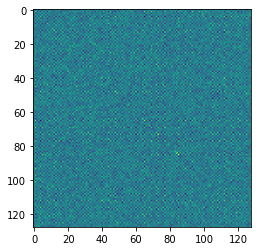

  0.472431  
 -0.300334  
  0.115552  
 -0.305385  
  0.302255  
 -0.274508  
  0.531676  
 -0.168217  
  0.296261  
 -0.189983  
-0.0225559  
 -0.375791  
  0.370938  
 -0.276925  
  0.294893  
 -0.537744  
 0.0668903  
 -0.151137  
  0.621157  
-0.0850165  
  0.355313  
 -0.202687  
 0.0397056  
   -0.5821  
  0.299939  
 -0.280964  
-0.0397009  
 -0.307384  
  0.187751  
 -0.256801  
  0.172622  
 -0.216273  
   0.30551  
 -0.215574  
  0.262538  
 -0.484052  
  0.195195  
 -0.198001  
  0.553785  
  -0.15504  
 0.0541481  
 -0.391608  
  0.114964  
 -0.123874  
  0.454563  
 -0.189177  
-0.0609919  
-0.0660292  
  0.365069  
 -0.136608  
  -0.01818  
 -0.372512  
  0.233419  
 -0.179366  
  0.511215  
  0.142802  
   0.13343  
 -0.217813  
  0.257081  
 -0.299865  
  0.216184  
 -0.293315  
  0.336864  
  -0.80873  
 0.0231773  
 -0.420471  
   0.93964  
-0.0106994  
  0.218809  
 -0.362259  
  0.237375  
 -0.215115  
  0.223414  
 -0.183772  
  0.232898  
-0.0274381  
  0.213822  

 0.000627162   -0.00537659  -0.000808409    0.00550041     0.0058043   -0.00373133    0.00957823    -0.0064981   0.000534942   -0.00239526     0.0116164   -0.00422488    0.00162963   -0.00660912   -0.00120572    -0.0142994    0.00246058   -0.00125734    -0.0124634   -0.00226725    0.00638953   -0.00491479   0.000378984    0.00246471    0.00625242   -0.00546031     0.0212241     0.0135427    0.00824708   -0.00517054    0.00538207     -0.010464    0.00506384   -0.00659142    0.00174448    0.00369846    0.00172247  -6.71049e-05   0.000460242   0.000147897    0.00223688   -0.00189101    0.00964812   -0.00400434    0.0112102   -0.00812892     0.0103594   -0.00752101    0.00847643   -0.00110729     0.0109705    0.00520096   0.00773319   -0.00944527    0.00313174   -0.00245722    0.00297953  -0.00370062    0.00125719   -0.00425772    0.00240202    0.00275169    0.00556008    -0.0123175   0.00718533  -0.00431239  -0.000816919   -0.00458583    0.00599721   -0.00193187    0.00405739   -0.0031042

 -0.00976999    0.00683032    0.00118515     0.0106453   -0.00936084    0.00826611    -0.0142994     0.0278922   -0.00921031    0.00603377    0.00848081   0.000336776    -0.0047879    0.00762772    0.00387745    0.00982941   -0.00808657    0.00728601    -0.0118851     0.0105419   -0.00467573     0.0104651  -8.97071e-05    0.00887798   -0.00424513   3.72992e-06    -0.0151198   -0.00677808   -0.00673177     0.0052893    -0.0171956    0.00134949   -0.00498285  -0.000452053    -0.0164234    0.00577552    -0.0098287  -0.000565529    -0.0116472    0.00382253   -0.00613595    8.5692e-05    -0.0102709    0.00860819  -0.00520287     0.0093247    -0.0208612     0.0160508   -0.00292055     0.0117532    -0.0141022    0.00819873   -0.0112784    0.00819859   -0.00116881  -0.000590914   -0.00770347    0.0072543    0.00264252    0.00659402   -0.00685469    0.00420397   -0.00710254     0.0180325  -0.00218193   0.00726739  -7.46051e-05     0.0057379   -0.00895471      0.005834    0.00751815    0.0029251

 -0.00427932    0.00625753   -0.00643021  -7.14445e-05    -0.0109174    0.00435359    0.00246471    0.00910601   -0.00260947    0.00860771  -0.000654681    0.00986188   -0.00364514    0.00344653  -0.000811741    0.00887798   -0.00149082    0.00966359    -0.0176492   -0.00138358   -0.00570234   0.000344471   -0.00174305    -0.0235326    0.00117865    0.00689048     -0.012067   -0.00453815   -0.00677568     0.0064161    0.00631484    0.00788406     0.0008884   -0.00221042    -0.0111525   0.000526772   -0.00320704     0.0082645   -0.00299341    0.00977343    -0.0058734    0.00786983     0.0012799   -0.00130981  -0.00310473    0.00367334   -0.00775112   -0.00792203    -0.0053123     0.0117032   -0.00976819   -0.00582617   -0.0102055    0.00328677    0.00234174  -0.000751095    -0.0078294  -0.00123931    -0.0139347   0.000120527    0.00254828    0.00236084   -0.00418692     0.0104235  -0.00288385  -0.00188661   -0.00564011     0.0119025   -0.00343813    0.00597856   -0.00767867     0.010416

  0.00387027   -0.00369167    0.00618322  -0.000306136     0.0053312   -0.00413903    0.00506384    0.00523603    0.00436501   -0.00532673    0.00424649   -0.00151585    0.00548533    -0.0069395    0.00829704   -0.00498285     0.0022582   -0.00562789   -0.00383989   -0.00883385    0.00765173   -0.00662623    0.00644077     0.0008884    0.00449543   -0.00554274   -0.00163397   -0.00556157    0.00386585    -0.0131265    0.00774052   -0.00283563    0.00802046   -0.00317206    0.00340869    0.00126157    0.00890168   -0.00397719     0.0117172   -0.00754928    0.00724757   -0.00137315  -5.02768e-05  -0.000379253   0.00443589   -0.00367766    0.00359521   -0.00960678    0.00325421   -0.00451793    0.00917139   -0.00682291   0.00602202   -0.00846367   0.000173359   -0.00640387     0.0040335  -0.00590951      0.007476   -0.00095455    0.00749183   -0.00269748    0.00509773   -0.00496013   0.00466135  -0.00466899    0.00682187    0.00284569    0.00286438   -0.00212591    0.00294875    0.0019217

   0.0048846   -0.00869547    0.00695203   -0.00244467    0.00978558     -0.011103    0.00223688    -0.0067115    0.00823812   -0.00462952     0.0106908   -0.00620869    0.00754364   -0.00810579   -0.00275873   -0.00613595    0.00998555   -0.00789357    0.00621218    0.00158365    0.00582901   -0.00841853    0.00591826    -0.0058734    0.00565192   -0.00497089    0.00716581    -0.0134613    0.00779387   -0.00707399     0.0135116    -0.0108851    0.00724757   -0.00495807    0.00906761   -0.00739082    0.00289188   -0.00653667    0.00623982    -0.0085951     0.0137086   -0.00681981    0.00253584   -0.00393718   0.00658218   -0.00508831    0.00309837   -0.00114043    0.00555116   -0.00555696    0.00508443   -0.00284795   0.00572871    -0.0101613  -0.000778265   -0.00286788    0.00575901  -0.00769676     0.0112784    -0.0100256     0.0100254   -0.00694634    0.00901343    0.00124829   0.00705468  -0.00382561    0.00111242   -0.00942357    0.00636674   -0.00376942  -0.000853313  -4.65763e-0

 -0.00205037    0.00109346    0.00608878    0.00937948   -0.00360193   0.000719289   -0.00752101     0.0108236    -0.0105769     0.0104373     0.0045314    0.00724694   -0.00687911    0.00314483   -0.00596456     0.0160508   -0.00449661    0.00602329   0.000208498    0.00040326    -0.0067794     0.0145343   -0.00701499   -0.00792203   -0.00563703    0.00419694   -0.00117797     0.0015492    -0.0035048    0.00691449   0.000954802      0.017198   -0.00960678    0.00293225   -0.00880442     0.0087705   -0.00691637    0.00499644   -0.00672089    0.00243748   -0.00114043    0.00385172  -0.000835935   -0.00518198  -0.00266617    0.00743766   -0.00470892    0.00209187   -0.00634034     0.0122278    0.00573318   -0.00941847  -0.00555941    0.00616356      0.017637    0.00173612   -0.00133546    0.0112897   -0.00297939     0.0111831   -0.00504143    0.00613963   -0.00165137     0.0132449  -0.00500529    0.0117736    -0.0102204    0.00512779   -0.00155932    0.00821957    0.00332555    0.0087133

 -0.00580675    0.00353972    0.00191536     0.0152476  -0.000924558    0.00543008   -0.00245722    -0.0109907    -0.0091794    0.00438991     -0.023655    0.00268471     0.0025585    0.00480849    0.00541162  -0.000590914   -0.00684751    0.00321701   -0.00383863    0.00627008   -0.00375795  -0.000996225    -0.0123578  -0.000751095   -0.00436078    0.00915552    0.00680245     0.0130802   -0.00143473     0.0063853    0.00466823     0.0132536   -0.00640387     0.0053383    -0.0172156    0.00252766   -0.00240866    0.00383377   -0.00816236   -0.00585519   -0.00286788   -0.00548064   -0.00688906    0.00630094   0.00104121    0.00536541    -0.0117499    0.00173612   -0.00200428    0.00538376    0.00508665     0.0152533  -0.00858703    0.00680267   0.000265065    -0.0119367   -0.00635655   0.00432255    -0.0190177     0.0165737   -0.00593231    0.00639885    -0.0239686    0.00866122  -0.00490023    0.0110403   -0.00170139   -0.00176683   -0.00350788    0.00857955    0.00262154    0.0082549

 -0.00257303    0.00156745    -0.0127386   -0.00145403    -0.0106404    0.00467773    -0.0123175    -0.0043429   -0.00747295    0.00206841   -0.00910286   0.000463147   -0.00346758    0.00640168     0.0116443     0.0180325   -0.00641568    0.00711883  -0.000568577    0.00594346   -0.00346962    0.00353549     -0.015912     0.0104235   0.000348097    0.00477002   -0.00579114    -0.0069727   -0.00451855     0.0106575   -0.00613233    0.00842739   -0.00496013    0.00516708    0.00989767    0.00243174     -0.002602    0.00144247    -0.0081423     0.0177797    0.00124829     0.0106378    0.00595847      0.004575  -0.00362378     0.0098104    -0.0155223     0.0132449   -0.00743558    0.00221787    -0.0158881    0.00802023  -0.00587456     0.0111748  -0.000524291    0.00866122   0.000598057   0.00638882    0.00185066    0.00445505   -0.00688939    0.00228732   -0.00848067    -0.0199719  -0.00312598   0.00419998     0.0093285   -0.00223793   -0.00397102    0.00743254  -0.000643539      0.01431

   0.0140005   -0.00450987    0.00593426    0.00629014     0.0142864   -0.00891117    0.00405739     0.0135685   0.000430113   -0.00508332     0.0136896   -0.00955108    0.00390178    -0.0122415    0.00488844    0.00751815     0.0055236    -0.0126646    -0.0140131   -0.00948615     0.0128499   -0.00513236    0.00881228   -0.00767867     0.0128864    -0.0042789   -0.00294084   -0.00967917    0.00993206   -0.00294325    0.00818652   -0.00435015    0.00294875    -0.0103162    0.00012415   -0.00189678    0.00312571    -0.0110137    0.00456107    0.00931392  -0.000853313   -0.00946659    0.00509298   -0.00115794    0.0115601    -0.0100952    -0.0104706    0.00332555    0.00135875    -0.0106155     0.0156621    0.00642066    0.0117779   -0.00544387   -0.00347549    0.00262154    0.00664906   -0.0105573     0.0131966     -0.028417    0.00860643   -0.00315395    0.00823439  -0.000643539    0.0117467  -0.00488156     0.0073165     -0.012873    0.00741563   -0.00601611      0.050755  -0.00051871

  0.00391176   -0.00456201    0.00340464     -0.010465    0.00773847    -0.0106952  -0.000178651   -0.00825688     0.0123885    -0.0070629    0.00135498   -0.00465644     0.0185779    -0.0134342    0.00172491   -0.00738431    0.00801029    -0.0096331     0.0115939   -0.00380014    0.00904722   -0.00577359     0.0191123  -0.000586385     0.0123453   -0.00294809    0.00817904    -0.0086093    0.00903256    -0.0104281     0.0138465    -0.0262091    0.00395409   -0.00954208     0.0200293   -0.00499805    0.00659863   -0.00698404     0.0125283    -0.0120676     0.0115085    -0.0070101    0.00196286    0.00625475    0.0108528    -0.0045233     0.0101507    -0.0106156    0.00639112   -0.00403539     0.0107388    0.00854221    0.0136144     -0.011916    -0.0131106   -0.00903117     0.0128962   -0.0130731     0.0051341   -0.00310124     0.0135791    -0.0175089    0.00455093    -0.0104901    0.0122363  -0.00903257   -0.00514095   -0.00548675    0.00469857    -0.0149394  -0.000627266    0.0018755

  0.00022296   -0.00947341  -0.000939338   -0.00558815    0.00658207    -0.0106301    0.00385389    -0.0205682    0.00771124   -0.00733229    0.00661194   -0.00891618    0.00687343   -0.00537106    -0.0134216   -0.00669369    0.00736168   -0.00801317    0.00451938   -0.00390844    0.00532011   -0.00332215    0.00447821    -0.0118691    0.00316527   -0.00605367    0.00838279  -0.000464097   -0.00238038   -0.00373167     0.0134621   -0.00592145    0.00664098    -0.0101213    0.00487506    -0.0103202    0.00294863    -0.0114958   0.000684831    0.00491431     0.0127488   -0.00866129      0.016031     -0.013433     0.013914   -0.00192104     0.0116509    0.00278975     0.0112549    -0.0087112     0.0128387    0.00052275   0.00817427  -0.000734349     0.0126654    0.00824888   0.000611621   -0.0127744   -0.00682168  -0.000877086    0.00871775   -0.00179824    0.00253807    -0.0159275   0.00560834  -0.00318763    0.00473503     0.0031262     0.0131969   -0.00615671   -0.00110742    -0.015655

  0.00716961   -0.00587707    -0.0100537    -0.0189252     0.0104381   -0.00459606    0.00238014    -0.0119973     0.0100958     -0.010738   -0.00214249   -0.00349684    0.00475196    -0.0102104   8.16995e-05    -0.0115204    0.00293597     -0.003665     -0.015231  -0.000551874    0.00731324    -0.0109113    0.00800998    -0.0156352     0.0113921   -0.00493143     0.0146095    -0.0121817   -0.00199541  -0.000327623       0.01308   -0.00914533    0.00346003    0.00241518   -0.00026216    0.00153147    0.00702163   -0.00716663    0.00756258    -0.0121797    0.00489696   -0.00179801    0.00616312    0.00488412    0.0133451   -0.00355489    0.00298839   -0.00178285    0.00913833   -0.00334358    0.00879227   -0.00422388     0.010137    -0.0108311    0.00295903   -0.00875444    0.00774426  5.94962e-05     0.0113308   -0.00968182    0.00177431  -7.04917e-05    0.00943367   -0.00222829    0.0121959  -0.00290983    0.00979316    -0.0090743    0.00999407   -0.00312372     0.0055371    -0.010678

 -0.00620291    0.00117209   -0.00276489    0.00475458   -0.00995918    0.00754429   -0.00211923    0.00979093   -0.00756096    0.00784492   -0.00468671    0.00589335   -0.00554765    0.00699806     -0.010411     0.0117892   -0.00859753    0.00717481    0.00227977   -0.00256635   -0.00594135     0.0100701   -0.00721931      0.012455   -0.00682882    0.00680772    -0.0123902    0.00030427   -0.00709768    0.00930631   -0.00735561     0.0105088   -0.00706378    0.00551932    -0.0127245    0.00313198   -0.00754221     0.0029316    -0.0117196    0.00777558   -0.00505407    0.00611066   -0.00413033   -0.00804726  -0.00878607     0.0074065   -0.00789683    0.00812545   -0.00569927    0.00605664   -0.00577747     0.0116536  -0.00659704     0.0062799    0.00703018     0.0061574    -0.0032025   0.00893885    -0.0143925     0.0135176   -0.00896476    0.00448843    -0.0128689    0.00659189  -0.00582321   0.00558639  -0.000144875    0.00491704   -0.00148947   0.000993046    -0.0130788    0.0055188

 -0.00439806    0.00970349  -0.000676967    0.00449376    -0.0107167    0.00631862   -0.00490071   0.000739835   -0.00932878    0.00600445   -0.00253955    0.00834447   -0.00905472    0.00435377     -0.012055  -6.20855e-05   -0.00495209    0.00487802   -0.00481766    0.00790161   -0.00666868    0.00762676   -0.00831205     0.0035099   -0.00673966    0.00549826   -0.00152305    0.00444474    -0.0093637     0.0078682   -0.00897706    0.00945396    -0.0071046    0.00535123    -0.0031553  -0.000913219    -0.0066532    0.00636597   -0.00526533    0.00466118   -0.00923309    0.00603185   -0.00151359     0.0023774   -0.0070361    0.00724828  -0.000453481    0.00683713    -0.0080246    0.00427838  -0.000875627      0.004909   -0.0071432    0.00750711    -0.0037121    0.00240554   -0.00514079   0.00629039    -0.0042855    0.00369101    -0.0102656    0.00720982    -0.0101948    0.00350432  -0.00494645   0.00496762   0.000115371    0.00723706   -0.00480095    0.00657517   -0.00229546   0.00074352

   0.0033977   -0.00588005  -0.000530497   -0.00800426     0.0105436   -0.00596353    0.00567856   -0.00800453    0.00468473   -0.00819823   -0.00209355    0.00124227    0.00272482   -0.00233899    0.00762463   -0.00216357    0.00254979   -0.00267269     0.0065281   -0.00420508    0.00419356   -0.00380616    0.00219837   -0.00455151    0.00791285   -0.00517295    0.00620811   -0.00102728     0.0031079   -0.00438236    0.00602238   -0.00416209    0.00170008   -0.00559424    0.00653365   -0.00716082    0.00373459   -0.00498813   -1.1007e-06    0.00224579    0.00565488   -0.00383017    0.00193604    -0.0078704   0.00499313   -0.00512712    0.00321612   -0.00305479    0.00579313   -0.00468679   0.000370072   -0.00966691    0.0053939   -0.00328533    0.00209636   -0.00795595    0.00495342  -0.00607163    0.00854604   -0.00624547    0.00669949   -0.00856764    0.00182993    0.00206942   0.00746242  -0.00348102    0.00330213   -0.00221484    0.00604841   -0.00315934   0.000770454   0.00096274

  0.00362557   -0.00599083     0.0033386    -0.0118995    0.00840689   -0.00727864    0.00639133   -0.00755757     0.0104535   -0.00470636     0.0028473   -0.00453395    0.00803916   -0.00707482    0.00817698   -0.00958655    0.00612579   -0.00795697   -0.00116267   -0.00457663    0.00346934   -0.00988199  -0.000935494   -0.00652944    0.00595995   -0.00275536    0.00316471    -0.0018769    0.00292268   -0.00796304    0.00363815   -0.00804171    0.00832939   -0.00465273     0.0064188    -0.0018856    0.00884591   -0.00306695    0.00137698   -0.00781766    0.00750931   -0.00535051    0.00636011    -0.0025324   0.00587388    -0.0050706    0.00265181   -0.00125528    0.00539438   -0.00444665   0.000750753  -0.000116387   0.00378828   -0.00544334    0.00321535   -0.00227156     0.0046263  -0.00599379     0.0133812   -0.00103148    0.00672073   -0.00668478     0.0108642    -0.0059019   0.00749274  -0.00412349   -0.00466624   -0.00825831    0.00394677    -0.0035297    0.00103609   0.00069163

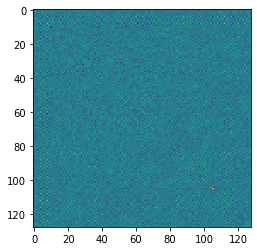

    0.05467  
 -0.0638316  
   0.244611  
  -0.444923  
    0.24189  
 -0.0493268  
  -0.129656  
  -0.191283  
   0.300362  
  -0.139862  
   0.195957  
   0.200248  
   0.341161  
  -0.157886  
   0.168317  
  -0.165025  
  0.0186605  
  -0.271295  
 -0.0827516  
   0.203105  
   0.120748  
  -0.144616  
  -0.162291  
  -0.111107  
  0.0424424  
 -0.0136225  
  -0.514659  
  -0.171679  
 -0.0796358  
  -0.151973  
   0.231872  
  -0.497929  
   0.110908  
  -0.207074  
  0.0499679  
  0.0041596  
   0.285817  
  0.0724754  
   0.198833  
   -0.06043  
   0.163391  
   -0.21871  
  0.0872062  
  -0.149984  
   0.119917  
  -0.176858  
  -0.155784  
 -0.0465603  
 -0.0227281  
 -0.0931802  
  0.0200106  
  -0.336331  
-0.00287331  
  -0.268781  
   0.100434  
  -0.244666  
  0.0851543  
  -0.168238  
  0.0718539  
 -0.0518269  
   0.170479  
 -0.0885634  
   0.120103  
  -0.203632  
 0.00620449  
 -0.0301664  
   0.136151  
   0.287648  
  0.0824918  
  0.0183286  
 -0.0221804  
  -0.2

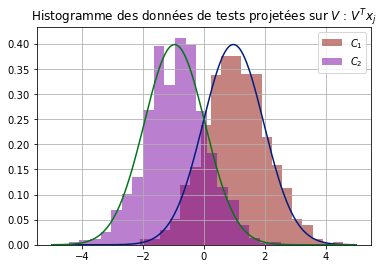

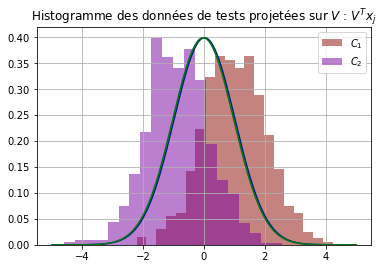

In [131]:
# %%prun -s cumulative
%matplotlib inline
# profiling
p = 200
m = 2

nb_tasks = 5
step = 10
t = [2**i for i in range(1,7)]
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])

emp_rate, th_rate, var, relative_error_rate = [], [], [], []
task_target = 1

betat = np.random.uniform(low=0.8, high=1, size=(t[-1]))
beta = 0
X = []
X_test = []
M = []
n_t = []
n=0
# print(f"beta = {betat[task_target]}")
mean = mean_matrix(p, beta=betat[task_target], k=2)
M.append(mean[0])
M.append(mean[1])
# print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]])
X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)

for idx,b in enumerate(t):
    if idx==0:
        boucle=b
    else:
        boucle = b-t[idx-1]
    print(f"boucle = {boucle}")
    to_add = ([50, 50], [10, 10])*boucle
    for i in range(boucle):
#         print(f"beta = {betat[beta]}")
        mean = mean_matrix(p, beta=betat[beta], k=1, starting=0)
        M.append(mean[0])
        n_t.append(to_add[i])
        n += sum(to_add[i])
        beta+=1
    err=[]
    print(b)
        
    print(n_t)
    print("n = ", n)
    # on crée les données synthétiques 
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    print("c0 : ",c0)
    Dc = np.diag(c)
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc,MM_true, c0)
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    J = create_J(m, b, n, n_t)
    for l in range(5):
        X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M)
        MM = []
        diag = []

        for i in range(b):
            MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
#             print(f"task 1 empirical mean = {np.mean(MM1[0])}")
            MM.append(MM1)
            diag.append(diag1)

        V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, b, m, p, n, n_t, task_target, True) 
        X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
        X_train_aggregated = aggregate_array(X, p, nt, b, m)
        print("c0 : ",c0)
        m_t = create_mt(b, m, y, Dc, correlation_matrix, c0)
        V_true = compute_V_old(y_true, X_train_aggregated, J)
        V_true = np.reshape(V_true, p)
        
        erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
        err.append(erreur_empirique)
    print(MM_true)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
    plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
    debug_histogram(V_true, X_test_aggregated, n_t_test)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t[1][0], 1))
    plt.plot(x, norm.pdf(x, m_t[1][1], 1))
    debug_histogram(V, X_test_aggregated, n_t_test)
    erreur_th = optimal_rate(xx, rho1, rho2)
    emp_rate.append(np.mean(err))
    var.append(np.std(err))
    th_rate.append(erreur_th)

%matplotlib qt
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.plot(t, emp_rate, "-o", label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

In [51]:
%matplotlib qt
x = np.linspace(-10,10, 500)
plt.plot(x, norm.pdf(x, m_t[1][0], 1))
plt.plot(x, norm.pdf(x, m_t[1][1], 1))
debug_histogram(V, X_test_aggregated, n_t_test)
plt.show()

/home/sami/anaconda3/lib/python3.7/site-packages/ipykernel/eventloops.py:106: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.exec_()


In [52]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.plot(t, emp_rate, "-o", label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

# Real Data

In [105]:
def normalisation(X, p, z=False):
    """
    si z: z-score normalisation par tâche
    sinon: divsion par sqrt(p)
    """
    if not z:
        for i in range(len(X)):
            for j in range(len(X[i])):
                X[i][j] *= 1/np.sqrt(p)
    else:
        for i in range(len(X)):
            task = np.concatenate((X[i][0], X[i][1]), axis=1)
            mean = np.mean(task, axis=1)
            mean = np.reshape(mean, (p, 1))
            X[i][0] = (X[i][0] - mean)/np.std(task)
            X[i][1] = (X[i][1] - mean)/np.std(task)
    return X

In [106]:
from sklearn import preprocessing

def divide_array(X,y,k,m=2):
    """
    Divide a data ndarray in an array of k arrays of m ndarrays each.
    Return the divided array and the number of elements in each classes of each tasks
    """
    X_data = []
    n_t = []
    for task in range(k):
        n_t.append([])
        X_data.append([])
        n_t1 = np.count_nonzero(y)
        n_t[task].append(n_t1)
        n_t[task].append(len(y) - n_t1)
        X_data[task].append(X[:n_t1].T)
        X_data[task].append(X[n_t1:].T)
        
    return X_data, n_t

def preprocess(X, p):
    """
    Centre et réduit les données X
    """
    tiled = np.tile(np.reshape(np.sum(X, axis=0), (p, 1)), (1, X.shape[0])).T
    X_t = np.true_divide(X, tiled, where=(tiled!=0))
    return preprocessing.scale(X, axis=0)
    

(400, 999) (400, 1000)
[[999, 1000]]
[[100, 100], [50, 50]]
n :  300
lenMM : 2
MM_gathered : 
   1.60213    -1.75708    0.0870623   -0.0534118  
  -1.75708    0.990439   -0.0735183    0.0892792  
 0.0870623  -0.0735183   0.00210996  -0.00558952  
-0.0534118   0.0892792  -0.00558952   0.00265257  


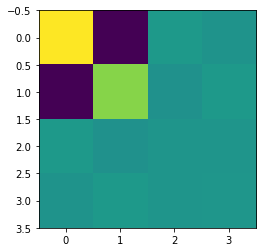

  0.0500304  
 -0.0801936  
  0.0032083  
-0.00372013  
0.333333         0         0         0  
       0  0.333333         0         0  
       0         0  0.166667         0  
       0         0         0  0.166667  


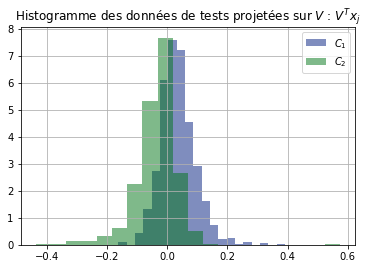

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
[[100, 100], [50, 50], [100, 100]]
n :  500
lenMM : 3
MM_gathered : 
   1.60213    -1.75708    0.0870623   -0.0534118      1.3032    -1.34203  
  -1.75708    0.990439   -0.0735183    0.0892792    -1.51219      1.1387  
 0.0870623  -0.0735183   0.00210996  -0.00558952   0.0381222  -0.0663015  
-0.0534118   0.0892792  -0.00558952   0.00265257  -0.0684269   0.0596341  
    1.3032    -1.51219    0.0381222   -0.0684269      1.5948    -1.52378  
  -1.34203      1.1387   -0.0663015    0.0596341    -1.52378     1.23845  


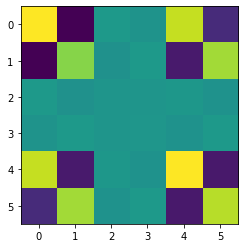

   0.065621  
  -0.114988  
 0.00463874  
-0.00530596  
  0.0298366  
 -0.0696579  
0.2    0    0    0    0    0  
  0  0.2    0    0    0    0  
  0    0  0.1    0    0    0  
  0    0    0  0.1    0    0  
  0    0    0    0  0.2    0  
  0    0    0    0    0  0.2  


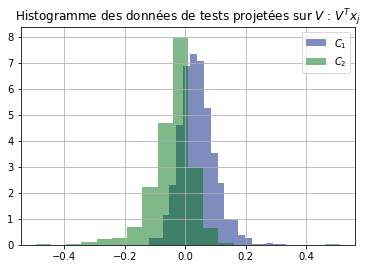

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
[[100, 100], [50, 50], [100, 100], [50, 50]]
n :  600
lenMM : 4
MM_gathered : 
   1.60213    -1.75708    0.0870623   -0.0534118      1.3032    -1.34203    1.38167    -1.53832  
  -1.75708    0.990439   -0.0735183    0.0892792    -1.51219      1.1387  -0.569931     1.91623  
 0.0870623  -0.0735183   0.00210996  -0.00558952   0.0381222  -0.0663015  0.0965628  -0.0178543  
-0.0534118   0.0892792  -0.00558952   0.00265257  -0.0684269   0.0596341  -0.114126     0.10026  
    1.3032    -1.51219    0.0381222   -0.0684269      1.5948    -1.52378   0.233073    -1.22929  
  -1.34203      1.1387   -0.0663015    0.0596341    -1.52378     1.23845   -1.67092     1.44257  
   1.38167   -0.569931    0.0965628    -0.114126    0.233073    -1.67092    4.38228    -1.77002  
  -1.53832     1.91623   -0.0178543      0.10026    -1.22929     1.44257   -1.77002   0.0686186  


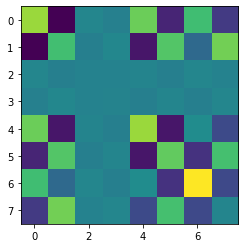

 0.0621237  
 -0.134934  
0.00439164  
-0.0044318  
  0.041802  
 -0.058982  
  0.157554  
-0.0194291  
0.166667         0          0          0         0         0          0          0  
       0  0.166667          0          0         0         0          0          0  
       0         0  0.0833333          0         0         0          0          0  
       0         0          0  0.0833333         0         0          0          0  
       0         0          0          0  0.166667         0          0          0  
       0         0          0          0         0  0.166667          0          0  
       0         0          0          0         0         0  0.0833333          0  
       0         0          0          0         0         0          0  0.0833333  


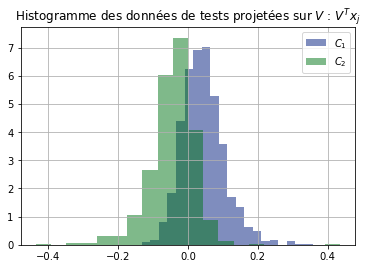

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 


In [108]:
from scipy.stats import zscore
from scipy.io import loadmat

dataset = "amazon"
%matplotlib inline
m=2
p=400
n11, n12, n21, n22 = 100, 100, 50, 50
var, emp_rate = [], []
if dataset == "amazon":
    k = 3
    mat = loadmat("books_400.mat")
    mat_test = loadmat("kitchen_400.mat")

    X_test_aggregated, y_test = mat_test['fts'], mat_test['labels']
    X_test_aggregated = preprocess(X_test_aggregated,p)
    X_test, n_t_test = divide_array(X_test_aggregated, y_test, 1)
    
    X_test = normalisation(X_test, p)
    # X1 contient toute la premiere tâche
    X1_aggregated, y = mat["fts"], mat["labels"]
    X1_aggregated = preprocess(X1_aggregated, p)
#     X1_aggregated = zscore(X1_aggregated, axis=None)
    
    X, n_t = divide_array(X1_aggregated, y, 1)
    X = [[X[0][0].T[:n11].T, X[0][1].T[:n12].T]]
    n_t = [[n11, n12]]
#     X = normalisation(X, p, True)
    X.append([X_test[:][0][0].T[:n21].T, X_test[:][0][1].T[:n22].T])
#     X_test = [[X_test[0][0].T[n21:n21+500].T, X_test[0][1].T[n22:n22+50].T]]
    print(X_test[0][0].shape, X_test[0][1].shape)
    print(n_t_test)
#     n_t_test = [[500, 500]]
    n_t.append([n21, n22])
    task_target = 1
    
for t in range(2, k+2):
#     nt = sum(n_t_test[0])
    # add tasks
    if t>2:
        if t==3:
            mat = loadmat("dvd_400.mat")
            X2_aggregated, y2 = mat["fts"], mat["labels"] 
#             X2_aggregated = zscore(X2_aggregated, axis=None)
            X2_aggregated = preprocess(X2_aggregated, p)
            X_tmp, n_t_tmp = divide_array(X2_aggregated, y2, 1)
            X_tmp = [[X_tmp[0][0].T[:n11].T, X_tmp[0][1].T[:n12].T]]
#             X_tmp = normalisation(X_tmp, p)
#             X_tmp = normalisation(X_tmp, p, True)
            X.append(X_tmp[0][:])
            n_t.append([n11, n12])
        elif t==4:
            mat = loadmat("elec_400.mat")
            X3_aggregated, y3 = mat["fts"], mat["labels"] 
#             X3_aggregated = zscore(X3_aggregated, axis=None)
            X3_aggregated = preprocess(X3_aggregated, p)
            X_tmp, n_t_tmp = divide_array(X3_aggregated, y3, 1)
            X_tmp = [[X_tmp[0][0].T[:n21].T, X_tmp[0][1].T[:n22].T]]
#             X_tmp = normalisation(X_tmp[:], p, True)
#             X_tmp = normalisation(X_tmp, p)
            X.append(X_tmp[0][:])
            n_t.append([n21, n22])
    print(n_t)
    n = sum(list(map(sum, (n_t[i] for i in range(t)))))
    print("n : ", n)
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        # chaque moyenne empirique calculée est un vecteur de taille p
#         sent+=1
#         t_MM.append(time()-t0)
        MM.append(MM1)
        diag.append(diag1)
    print(f"lenMM : {len(MM)}")
    # CENTRAL SERVER
#     t0 = time()
    # sending empirical means to central server
    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)
    matprint(Dc)
    # END CENTRAL SERVER
    VTX = V.T@X_test_aggregated.T
    debug_histogram(V, X_test_aggregated.T, n_t_test)
    var.append(np.var(VTX))
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix, c0)
    
#     erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0))
    
%matplotlib qt
plt.plot(list(range(k)), emp_rate, '-o')
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
ticks = ["Books", "DVDs", "Electronics"]
plt.xticks(range(len(ticks)), ticks, size='larger')
plt.xlabel("Added tasks")
# plt.ylim(0.18,0.24)
plt.ylabel("Empirical error rate")
plt.legend()
plt.grid()
plt.title("Real data")
plt.show()

In [72]:
print(emp_rate)

[0.27613806903451726, 0.23311655827913957, 0.22911455727863933]


# MNIST


In [100]:
pca = PCA(0.99).fit(X1)
pca.n_components_

176

100 composantes sont suffisantes


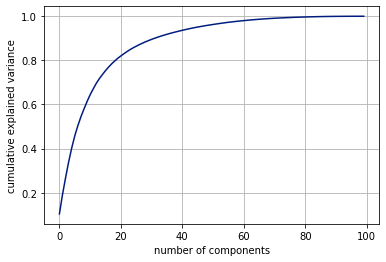

In [72]:
from sklearn.decomposition import PCA

pca = PCA().fit(X1)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print("100 composantes sont suffisantes")

In [183]:
from keras.datasets import mnist
from sklearn.decomposition import PCA
p=100
def mnist_prepocessing(p):
    (X_train,y_train), (X_t,y_test)=mnist.load_data()
    print(X_t.shape, X_train.shape)
    X_train, X_t = np.reshape(X_train, (60000, 784)), np.reshape(X_t, (10000, 784))
    X_train, X_t = PCA(n_components=100).fit(X_train).transform(X_train), PCA(n_components=100).fit(X_t).transform(X_t)
    X_train, X_t = X_train.T, X_t.T
    print(X_t.shape, X_train.shape)
    sigma=1
#     X_train = X_train+sigma*np.random.randn(X_train.shape[0], X_train.shape[1])
#     X_t = X_t+sigma*np.random.randn(X_t.shape[0], X_t.shape[1])
    
    
    X_train /= np.max(X_train)
    X_t /= np.max(X_t)
    # mean_data=mean(data,2);mean_test=mean(test,2);
    # norm2_data=0;norm2_test=0;
    # for i=1:init_n
    #     norm2_data=norm2_data+1/init_n*norm(data(:,i)-mean_data)^2;
    # end
    # for i=1:test_n
    #     norm2_test=norm2_test+1/test_n*norm(test(:,i)-mean_test)^2;
    # end
    #  data=(data-mean_data*ones(1,size(data,2)))/sqrt(norm2_data)*sqrt(p);
    #  test=(test-mean_test*ones(1,size(test,2)))/sqrt(norm2_test)*sqrt(p);
    mean_data = np.mean(X_train,axis=1); mean_test=np.mean(X_t, axis=1)
    mean_data = np.reshape(mean_data, (p,1)); mean_test = np.reshape(mean_test, (p,1))
    norm2_data=0;norm2_test=0;
    for i in range(len(X_train)):
        norm2_data += 1/len(X_train)*np.linalg.norm(X_train.T[i]-mean_data)**2
    for i in range(len(X_t)):
        norm2_test += 1/len(X_t)*np.linalg.norm(X_t.T[i]-mean_test)**2
    X_train = (X_train-mean_data@np.ones((1, X_train.shape[1])))/np.sqrt(norm2_data)*np.sqrt(p)
    X_t = (X_t-mean_test@np.ones((1, X_t.shape[1])))/np.sqrt(norm2_test)*np.sqrt(p)
    
    return X_train, X_t
    

In [184]:
X_train, X_t = mnist_prepocessing(p)
print(np.linalg.norm(X_t))

(10000, 28, 28) (60000, 28, 28)
(100, 10000) (100, 60000)
102.18950775573038


In [185]:
X0 = (X_train.T[y_train==0].T)
X1 = (X_train.T[y_train==1].T)
X2 = (X_train.T[y_train==2].T)
X3 = (X_train.T[y_train==3].T)
X4 = (X_train.T[y_train==4].T)
X5 = (X_train.T[y_train==5].T)
X6 = (X_train.T[y_train==6].T)
X7 = (X_train.T[y_train==7].T)
X8 = (X_train.T[y_train==8].T)
X9 = (X_train.T[y_train==9].T)

X0_test = (X_t.T[y_test==0].T)
X1_test = (X_t.T[y_test==1].T)
X2_test = (X_t.T[y_test==2].T)
X3_test = (X_t.T[y_test==3].T)
X4_test = (X_t.T[y_test==4].T)
X5_test = (X_t.T[y_test==5].T)
X6_test = (X_t.T[y_test==6].T)
X7_test = (X_t.T[y_test==7].T)
X8_test = (X_t.T[y_test==8].T)
X9_test = (X_t.T[y_test==9].T)

In [31]:
%matplotlib inline
n1, n2 = 100, 50
X_test = [[X1_test.T[:250].T, X4_test.T[:250].T]]
n_t_test = [[250, 250]]
X = [[X7.T[:n2].T, X9.T[:n2].T]]
n_t = [[n2,n2]]
m, k = 2, 5
var, emp_rate = [], []
task_target = 1

# X_test = normalisation(X_test, p, True)
n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
X_test_aggregated = aggregate_array(X_test, p, n, 1, 2)

# X = normalisation(X, p, True)

for t in range(2, k+2):
#     nt = sum(n_t_test[0])
    
    # add tasks
    if t==2:
        X_tmp = [[X1.T[:n2].T, X4.T[:n2].T]]
#         X_tmp = normalisation(X_tmp,p,True)
        X.append(X_tmp[:][0])
        n_t.append([n2, n2])
    elif t==3:
        X_tmp = [[X3.T[:n1].T, X8.T[:n1].T]]
        X.append(X_tmp[:][0])
        n_t.append([n1, n1])
    elif t==4:
        X_tmp = [[X5.T[:n2].T, X6.T[:n2].T]]
        X.append(X_tmp[:][0])
        n_t.append([n2, n2])
    elif t==5:
        X_tmp = [[X2.T[:n1].T, X9.T[:n1].T]]
        X.append(X_tmp[:][0])
        n_t.append([n1, n1])
    elif t==6:
        X_tmp = [[X3.T[:n2].T, X5.T[:n2].T]]
        X.append(X_tmp[:][0])
        X.append([X3.T[:n2].T, X5.T[:n2].T])
        n_t.append([n2, n2])
    
    n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
    print("n : ", n)
            
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        MM.append(MM1)
        diag.append(diag1)

    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)
    
    VTX = V.T@X_test_aggregated
    debug_histogram(V, X_test_aggregated, n_t_test)
    var.append(np.var(VTX))
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix)
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))

%matplotlib qt
plt.plot(list(range(k)), emp_rate, '-o')
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
plt.legend()
ticks = ["(7-9)", "(3-8)", "(5-6)", "(2-9)", "(3-5)"]
plt.xticks(range(len(ticks)), ticks, size='larger')
plt.xlabel("Added tasks")
plt.ylabel("Empirical error rate")
plt.grid()
plt.title("MNIST data")
plt.show()

NameError: name 'X1_test' is not defined

In [178]:
print(X0.shape)

(100, 5923)


# Optimalité

In [29]:
# print((MM-MM*(np.identity(2*t)+1/sigma**2*np.identity(2*t)*MM)).shape)
from scipy.stats import norm
def bayes_risk(rho, gamma):
    """
    Compute minimal Bayes error rate of label estimation for task t
    """
    if rho==0.5:
        return 1-norm.cdf(np.sqrt(gamma))

    return 1-rho*norm.cdf(np.sqrt(gamma)-1/(2*np.sqrt(gamma))*np.log((1-rho)/rho))-(1-rho)*norm.cdf(np.sqrt(gamma)+1/(2*np.sqrt(gamma))*np.log((1-rho)/rho))
# r1s = [1-rho1*norm.cdf(np.sqrt(q1)-np.log((1-rho1)/rho1)/(2*np.sqrt(q1)))-(1-rho1)*norm.cdf(np.sqrt(q1)+np.log((1-rho1)/rho1)/(2*np.sqrt(q1))) for q1 in q1s]

In [30]:
print(1-norm.cdf(np.sqrt(2415/1598)))
print(qfunc(np.sqrt(2415/1598)))

0.10947315012664438
0.10947315012664433


task 1 empirical mean = -0.004323420559516561
1  0  
0  1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95238095 0.5       ]
[0.9523809523809523, 0.5]
task 1 empirical mean = 0.0038719236623862485
       1  0.111111  
0.111111         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95239503 0.50295683]
[0.952395032525133, 0.5029568302779421]
task 1 empirical mean = 0.008171682497862742
       1  0.222222  
0.222222         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95243829 0.51204094]
[0.9524382901866345, 0.512040939193257]
task 1 empirical mean = -0.005908188066033056
       1  0.333333  
0.333333         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95251397 0.52793296]
[0.952513966480447, 0.5279329608938548]
task 1 empirical mean = -0.009254025322539907
       1  0.444444  
0.444444         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95262816 0.55191434]
[0.9526281635301752, 0.5519143413367943]
task 1 empirical mean = -0.0129617168

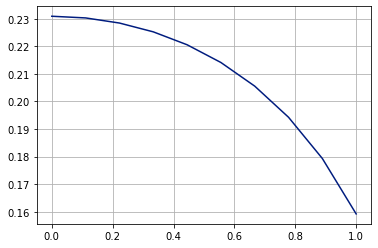

In [34]:
# T = 2, p_t = 1, lambda = 1, a1, a2 = 1 ?
# calcul de q_t
p = 100
m = 2
t = 2
beta = np.linspace(0,1,10)
n_t = [[1300, 700], [40, 60]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
random_state=100
sigma = 1
R1, R2 = [], []
for b in beta:
    qt = []
#     M = mean_matrix(p, b, t, random_seed=random_state)
    mu = np.random.multivariate_normal(np.zeros(p),np.eye(p))#/np.sqrt(p)
    mu /= np.linalg.norm(mu)
    mu_tilde = np.random.multivariate_normal(np.zeros(p),np.eye(p))
    mu_ortho = mu_tilde - np.dot(mu,mu_tilde)*mu
    mu_ortho /= np.linalg.norm(mu_ortho)
    M = [[-mu, mu], [-(b*mu+np.sqrt(1-b**2)*mu_ortho), b*mu+np.sqrt(1-b**2)*mu_ortho]]
#     M = [[]]
    print(f"task 1 empirical mean = {np.mean(M[1][0])}")
#     (Gam@inv(I + np.diag([al1*p1*snr, al2*p2*snr])@Gam))[0,0]
    C = np.array([[1, b],[b, 1]])
#     M_true = true_mean(M, p, t, m)
#     C = M_true.T@M_true
    matprint(C)
    r1, r2 = bayes_optimal(n_t, C, p)
    R1.append(r1)
    R2.append(r2)
    
plt.plot(beta, R2)
plt.grid()
plt.show()
    

In [30]:
def bayes_optimal(n_t, MM, p, sigma=1):
    """
    Renvoie R1, R2
    """
    qt = []
    a1, a2 = (n_t[0][0]+ n_t[0][1])/p, (n_t[1][0] + n_t[1][1])/p
    print(f"a1 = {a1}")
    D = np.diag([a1/sigma**2, a2/sigma**2])
    matprint(D)
#     matprint(MM)
#     print(np.linalg.inv(np.identity(4)+D*MM))
#     print(MM*np.linalg.inv(np.identity(4)+D*MM))
    print(np.identity(2)+D*MM)
    # gros con sami
    Q = np.diag((MM-MM@np.linalg.inv(np.identity(2)+D@MM)))
    print(Q)
    qt.append(Q[0])
    qt.append(Q[1])
    
    print(qt)
    if bayes_risk(n_t[0][1]/sum(n_t[0]), qt[0])>0.5:
        R1 = (1-bayes_risk(n_t[0][0]/sum(n_t[0]), qt[0]))
    else:
        R1 = (bayes_risk(n_t[0][1]/sum(n_t[0]), qt[0]))
        
    if bayes_risk(n_t[1][1]/sum(n_t[1]), qt[1])>0.5:
        R2 = (1-bayes_risk(n_t[1][0]/sum(n_t[1]), qt[1]))
    else:
        R2 = (bayes_risk(n_t[1][1]/sum(n_t[1]), qt[1]))  
    return R1, R2

[]


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

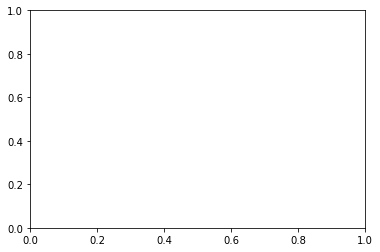

In [33]:
print(R1)
plt.plot(beta, R1, '-o', label="R1")
plt.plot(beta, R2, '-o', label="R2")
plt.legend()
plt.grid()
plt.show()

# Algorithme distribué k-tâches m classes
On se ramène à un cas 2-tâches 2-classes en fait

In [81]:
from scipy.stats import zscore

def z_normalize(X, k):
    """
    Normalise les données.
    k tâches, m classes
    X le tableau de données.
    """
    return zscore(X)

In [195]:
# Algorithme 1 du papier
k = 2
m = 10
n1 = [100 for i in range(m)]
n2 = [50 for i in range(m)]
p = 100
n_t = [n1, n2]
n_t_test = [[1000 for i in range(m)]]
nt = sum(n_t_test[0])
# faire quelque chose de généralisable
n = sum(list(map(sum, (n_t[i] for i in range(k)))))
c0 = p/n
var = []
emp_rate = []
scores = []
random_state=100
# si je peux essayer de faire plus dégeu pour le n 
M = mean_matrix(p, k=k, m=m, random_seed=random_state, random=True)
X, y_bs = gaussian_synthetic_data(n, p, m, k, n_t, M, random_state)

# choisir la tache que l'on veut tester
test_task = 1
X_test, y_test = gaussian_synthetic_data(n, p, m, 1, n_t_test, [M[test_task]], random_state)
X, X_test = z_normalize(X, k, m), z_normalize(X_test, 1, m)
# beta = []
# [[[],[]], [[], []]]

# inverser les boucles ?
for l in range(m):
    for t in range(k):
        if t==test_task:
            # how does it benefit from the other tasks?
            # pourquoi faire une boucle sur les tâches ?
    #         beta.append(l*k+t)
            X_data = []
            # on ajoute la premiere classe de la premiere tache
            X_data.append([X[t][l]])
            current_n_t = [[n_t[t][l]]]
            s = 0           

            tmp = np.empty((p, 0), float)
    #         print("tmp : ", tmp)
            for cl in range(m):
                if cl==l:
                    continue
    #             print("on ajoute : ", X[t][cl])
    #             print(X[t][cl].shape)
                tmp = np.concatenate((tmp, X[t][cl]), axis=1)
                s += n_t[t][cl]
    #         print("tmp : ", tmp)
            X_data[0].append(tmp)
    #         qui est la deuxieme tâche ? 
    #         X_data.append(X_test[0])
#             regrouper toutes les autres tâches
#             a reprendre
            temp = []
            tmp1 = np.empty((p, 0), float)
            s1 = 0
            sc = []
            for tp in range(k):
                if tp == test_task:
                    continue
                for l in range(m):
                    tmp1 = np.concatenate((tmp1, X[tp][l]), axis=1)
                    s1 += n_t[tp][l]
                temp.append(tmp1)
                sc.append(s2)
                sc.append(s1)
            X_data.append(temp)
    #         print("len(X) : ", len(X_data))
    #         print("len(X[0]) : ", len(X_data[1][0]))
            current_n_t[0].append(s)
            current_n_t.append(sc)
            print(f"current nt = {current_n_t}")
            MM = empirical_mean(2, 2, X_data, p, current_n_t)
            matprint(MM)
            c = estimate_c(current_n_t, n, 2, 2)
            Dc = np.diag(c)
            matprint(Dc)
            correlation_matrix = compute_M_cal(n, p, Dc, MM, 2, True)

            y = label_evaluation(2, 2, Dc, MM, c0)
            matprint(y)
            X_aggregated = aggregate_array(X_data, p, n, 2, 2)
            X_test_aggregated = aggregate_array(X_test, p, nt, 1, 2)

            # no need to compute V anymore
            J = create_J(2, 2, n, current_n_t)
            V = compute_V(y, X_aggregated, J, n)
            # On time le temps d'inférence

        #     debug_histogram(V_true, X_test_aggregated, n_t_test)
        #     print("V = ")
            VTX = V.T@X_test_aggregated
            var.append(np.var(VTX))
            debug_histogram(V, X_test_aggregated, n_t_test)

            # pour l'instant pas vraiment utilisé
            m_t = create_mt(2, 2, y, Dc, correlation_matrix)
            # gxt in R^1xn

            gxt = y.T@J.T@X_aggregated.T@X_test_aggregated/np.linalg.norm(y.T@J.T@X_aggregated.T)
            gxt = np.reshape(gxt, (nt))
            scores.append(gxt-m_t[0][0])

            erreur_empirique = compute_error_rate(X_test, V, m_t, 1, 2, n_t_test, Dc, c0)
    #         erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
            emp_rate.append(erreur_empirique)
    #         th_rate.append(erreur_theorique)
    #         relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)

estimated_class=[]
for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))

        
        
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.legend()
# plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
# plt.xlabel("Task relatedness (beta)")
# plt.ylabel("error rate")
# plt.grid()
# plt.show()
        

random
beta 0.5434049417909654


KeyboardInterrupt: 

In [162]:
print(X_data[1][1].shape)

(100, 1000)


In [168]:
estimated_class = []
erreur= []

for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))
    erreur.append(int(np.argmax(classes)==y_test[j]))
    
err = erreur.count(1)/len(scores[0])
if err>0.5:
    err = 1-err

print(err)
# estimated_class
# print(np.argmax(scores[l][0] for l in range(m)))
# print(np.argmax((scores[0][0], scores[1][0])))

0.5
800


In [165]:
ones=0
twos=0
for i in range(len(scores[0])):
    maxi = scores[0][i]
    indice = 0
    for idx, score in enumerate(scores):
        if score[i] > maxi:
            maxi = score[i]
            indice = idx
    l = indice%2+1
    if l == 1:
        ones+=1
    else:
        twos+=1
    
#     print(l)
print(f"Empirical proportions : \nC1 proportion : {ones/len(scores[0])*100} %, C2 proportion : {twos/len(scores[0])*100} %")
print(f"Theoritical proportions : \nC1 proportion : {round(sum(n1)/(sum(n1)+sum(n2))*100, 3)} %, C2 proportion : {round(sum(n2)/(sum(n1)+sum(n2))*100, 3)} %")

Empirical proportions : 
C1 proportion : 0.0 %, C2 proportion : 100.0 %
Theoritical proportions : 
C1 proportion : 66.667 %, C2 proportion : 33.333 %


In [98]:
print(current_n_t)
print(gxt.shape)
print(J.T.shape)
print(X_aggregated.T.shape)
print(X_test_aggregated.shape)

[[200, 600]]
(1, 800)
(2, 800)
(800, 100)
(100, 800)


In [102]:
print(tmp.shape)
print(s)
print(len(X_data))
print(np.ones((n_t[0][0], 1)).T.shape)
print((X_data[0][0].T.shape))
print((X_data[0][1].shape))
print(np.ones(n_t[0][1]).shape)
#1x240x50
print(X_data)
print(X[3][1])
print(X[3][0])

(2, 2)
2
2
(1, 4)
(2, 2)
(2, 2)
(4,)
[[array([[-0.88007943, -0.47482649],
       [-0.96586158,  0.2590587 ]]), array([[0.92226127, 0.38656715],
       [0.91331841, 0.40724621]])], [array([[0.36683514, 0.43040179, 0.0591088 , 0.82261317],
       [0.24975802, 0.77567657, 0.21940746, 0.53647661]]), array([[-0.34926064, -0.34675433, -0.05486188, -0.8687742 ],
       [-0.1093427 , -0.39596414, -0.807452  , -0.42341213]])]]
[[-0.88007943 -0.47482649]
 [-0.96586158  0.2590587 ]]
[[0.92226127 0.38656715]
 [0.91331841 0.40724621]]


In [65]:
print(n_t[0][0])
print(X[1][0].shape)
print(X_data[0][0].shape)
print(current_n_t)

50
(200, 10)
(200, 50)
[[50, 50], [500, 500]]


In [104]:
n_t = [[10,10], [4,4], [5,5]]
n = sum(list(map(sum, (n_t[i] for i in range(2)))))
print(list(n_t[i] for i in range(3) if i!=0))
current = [n_t[0], list(n_t[i] for i in range(2) if i!=0)[0]]
current

[[4, 4], [5, 5]]


[[10, 10], [[4, 4]]]

In [1]:
import pandas

In [6]:
help(pandas.DataFrame.sum)

Help on function sum in module pandas.core.generic:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values over the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will b